In [1]:
import os, sys
import torch as th
from sklearn.metrics import log_loss, accuracy_score
import openml
import optuna

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting import plot_roc, plot_losses
from src.modeling import (
    NumericEmbedding, train, data_split, decision_tree_encoding, decision_tree_encoding_multi,
    FeedForwardMLPResidual
)
from src.experiments import RFExperiment, XGBExperiment, NNRawExperiment, DTEExperiment

In [5]:
SUITE_ID = 297 # Regression on numerical features

In [6]:
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

In [7]:
task_id = 361060 # electricity

In [8]:
task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

In [9]:
df, y, categorical_indicator, features = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)
y = (y==y[0]).astype(int).values

In [10]:
df.head()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.898987,0.957447,0.068632,0.568283,0.004456,0.456499,0.644737
1,0.867616,0.234043,0.033716,0.337102,0.001672,0.329622,0.846930
2,0.009159,0.255319,0.059175,0.185808,0.003467,0.422915,0.414912
3,0.898987,0.531915,0.087577,0.539572,0.004936,0.637752,0.491667
4,0.868280,0.085106,0.027021,0.165129,0.001271,0.265924,0.748246


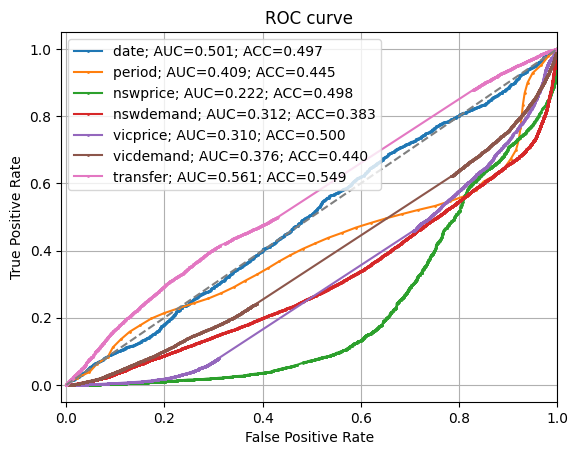

In [11]:
plot_roc(y, [df[c].values for c in features], features, x_max=1.0)

## Data splitting

In [12]:
Xs, ys = data_split(df.values, y, 0.7, 0.09)

In [13]:
{k: v.shape for k, v in Xs.items()}

{'train': torch.Size([26931, 7]),
 'valid': torch.Size([3462, 7]),
 'test': torch.Size([8081, 7])}

In [14]:
{k: v.shape for k, v in ys.items()}

{'train': torch.Size([26931]),
 'valid': torch.Size([3462]),
 'test': torch.Size([8081])}

## Modeling

In [16]:
base_exp_name = 'electricity'
suffix_exp_name = 'v2'
N_trials = 30

### Random Forest

In [17]:
exp_rf = RFExperiment(Xs, ys)

In [18]:
study_rf = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name=f"{base_exp_name}-rf-{suffix_exp_name}",
    direction='maximize',
)  # Create a new study.
study_rf.optimize(exp_rf.objective_(), n_trials=N_trials)  # Invoke optimization of the objective function.

[I 2023-01-27 11:49:12,764] A new study created in RDB with name: electricity-rf-v2
[I 2023-01-27 11:49:17,633] Trial 0 finished with value: 0.8004043905257077 and parameters: {'n_estimators': 369, 'max_depth': 7}. Best is trial 0 with value: 0.8004043905257077.
[I 2023-01-27 11:49:19,370] Trial 1 finished with value: 0.804159445407279 and parameters: {'n_estimators': 132, 'max_depth': 7}. Best is trial 1 with value: 0.804159445407279.
[I 2023-01-27 11:49:27,903] Trial 2 finished with value: 0.8353552859618717 and parameters: {'n_estimators': 498, 'max_depth': 10}. Best is trial 2 with value: 0.8353552859618717.
[I 2023-01-27 11:49:33,339] Trial 3 finished with value: 0.8249566724436742 and parameters: {'n_estimators': 342, 'max_depth': 9}. Best is trial 2 with value: 0.8353552859618717.
[I 2023-01-27 11:49:37,791] Trial 4 finished with value: 0.755632582322357 and parameters: {'n_estimators': 439, 'max_depth': 5}. Best is trial 2 with value: 0.8353552859618717.
[I 2023-01-27 11:49:42,

In [19]:
best_params_rf = study_rf.best_params
best_params_rf

{'max_depth': 12, 'n_estimators': 125}

In [20]:
y_hat_rf = exp_rf.get_best_y_test(study_rf.best_trial)

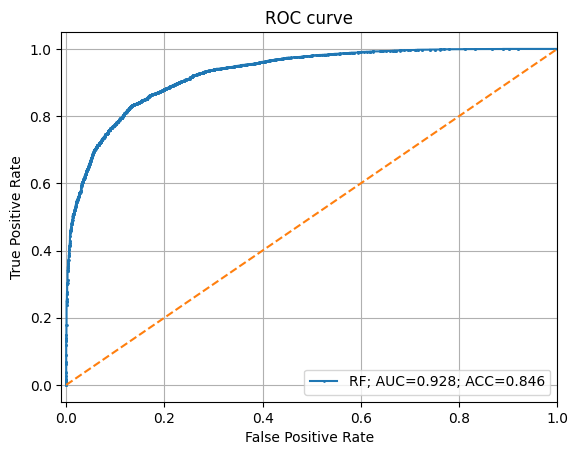

In [21]:
plot_roc(ys['test'],[y_hat_rf], ['RF'])

### XGBoost

In [22]:
exp_xgb = XGBExperiment(Xs, ys)

In [23]:
study_xgb = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name=f"{base_exp_name}-xgb-{suffix_exp_name}",
    direction='maximize',
)  # Create a new study.
study_xgb.optimize(exp_xgb.objective_(), n_trials=N_trials)

[I 2023-01-27 11:50:54,956] A new study created in RDB with name: electricity-xgb-v2


[0]	validation_0-logloss:0.64192	validation_1-logloss:0.64539
[1]	validation_0-logloss:0.59913	validation_1-logloss:0.60542
[2]	validation_0-logloss:0.56147	validation_1-logloss:0.57116
[3]	validation_0-logloss:0.52980	validation_1-logloss:0.54214
[4]	validation_0-logloss:0.50148	validation_1-logloss:0.51632
[5]	validation_0-logloss:0.47660	validation_1-logloss:0.49383
[6]	validation_0-logloss:0.45517	validation_1-logloss:0.47502
[7]	validation_0-logloss:0.43599	validation_1-logloss:0.45841
[8]	validation_0-logloss:0.41862	validation_1-logloss:0.44369
[9]	validation_0-logloss:0.40209	validation_1-logloss:0.42999
[10]	validation_0-logloss:0.38682	validation_1-logloss:0.41749
[11]	validation_0-logloss:0.37453	validation_1-logloss:0.40715
[12]	validation_0-logloss:0.36168	validation_1-logloss:0.39718
[13]	validation_0-logloss:0.34952	validation_1-logloss:0.38798
[14]	validation_0-logloss:0.33844	validation_1-logloss:0.37917
[15]	validation_0-logloss:0.32753	validation_1-logloss:0.37082
[1

[130]	validation_0-logloss:0.11729	validation_1-logloss:0.22712
[131]	validation_0-logloss:0.11689	validation_1-logloss:0.22700
[132]	validation_0-logloss:0.11616	validation_1-logloss:0.22664
[133]	validation_0-logloss:0.11540	validation_1-logloss:0.22622
[134]	validation_0-logloss:0.11501	validation_1-logloss:0.22599
[135]	validation_0-logloss:0.11442	validation_1-logloss:0.22562
[136]	validation_0-logloss:0.11391	validation_1-logloss:0.22557
[137]	validation_0-logloss:0.11341	validation_1-logloss:0.22531
[138]	validation_0-logloss:0.11306	validation_1-logloss:0.22522
[139]	validation_0-logloss:0.11228	validation_1-logloss:0.22483
[140]	validation_0-logloss:0.11181	validation_1-logloss:0.22445
[141]	validation_0-logloss:0.11127	validation_1-logloss:0.22422
[142]	validation_0-logloss:0.11115	validation_1-logloss:0.22408
[143]	validation_0-logloss:0.11068	validation_1-logloss:0.22390
[144]	validation_0-logloss:0.10998	validation_1-logloss:0.22364
[145]	validation_0-logloss:0.10945	valid

[259]	validation_0-logloss:0.07421	validation_1-logloss:0.20803
[260]	validation_0-logloss:0.07400	validation_1-logloss:0.20792
[261]	validation_0-logloss:0.07380	validation_1-logloss:0.20796
[262]	validation_0-logloss:0.07361	validation_1-logloss:0.20792
[263]	validation_0-logloss:0.07345	validation_1-logloss:0.20792
[264]	validation_0-logloss:0.07316	validation_1-logloss:0.20795
[265]	validation_0-logloss:0.07296	validation_1-logloss:0.20782
[266]	validation_0-logloss:0.07273	validation_1-logloss:0.20789
[267]	validation_0-logloss:0.07248	validation_1-logloss:0.20789
[268]	validation_0-logloss:0.07225	validation_1-logloss:0.20785
[269]	validation_0-logloss:0.07202	validation_1-logloss:0.20759
[270]	validation_0-logloss:0.07178	validation_1-logloss:0.20761
[271]	validation_0-logloss:0.07159	validation_1-logloss:0.20757
[272]	validation_0-logloss:0.07140	validation_1-logloss:0.20742
[273]	validation_0-logloss:0.07120	validation_1-logloss:0.20718
[274]	validation_0-logloss:0.07097	valid

[388]	validation_0-logloss:0.05649	validation_1-logloss:0.20456
[389]	validation_0-logloss:0.05637	validation_1-logloss:0.20445
[390]	validation_0-logloss:0.05628	validation_1-logloss:0.20448
[391]	validation_0-logloss:0.05620	validation_1-logloss:0.20450
[392]	validation_0-logloss:0.05612	validation_1-logloss:0.20459
[393]	validation_0-logloss:0.05602	validation_1-logloss:0.20464
[394]	validation_0-logloss:0.05595	validation_1-logloss:0.20468
[395]	validation_0-logloss:0.05585	validation_1-logloss:0.20472
[396]	validation_0-logloss:0.05576	validation_1-logloss:0.20464
[397]	validation_0-logloss:0.05570	validation_1-logloss:0.20464
[398]	validation_0-logloss:0.05562	validation_1-logloss:0.20459
[399]	validation_0-logloss:0.05553	validation_1-logloss:0.20447
[400]	validation_0-logloss:0.05543	validation_1-logloss:0.20449
[401]	validation_0-logloss:0.05536	validation_1-logloss:0.20452
[402]	validation_0-logloss:0.05525	validation_1-logloss:0.20446
[403]	validation_0-logloss:0.05516	valid

[I 2023-01-27 11:51:07,133] Trial 0 finished with value: 0.9196995956094743 and parameters: {'n_estimators': 603, 'max_depth': 12, 'learning_rate': 0.0954336165034509}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.66924	validation_1-logloss:0.67048
[1]	validation_0-logloss:0.64736	validation_1-logloss:0.64950
[2]	validation_0-logloss:0.62725	validation_1-logloss:0.63061
[3]	validation_0-logloss:0.60859	validation_1-logloss:0.61317
[4]	validation_0-logloss:0.59125	validation_1-logloss:0.59700
[5]	validation_0-logloss:0.57512	validation_1-logloss:0.58209
[6]	validation_0-logloss:0.55999	validation_1-logloss:0.56787
[7]	validation_0-logloss:0.54598	validation_1-logloss:0.55513
[8]	validation_0-logloss:0.53280	validation_1-logloss:0.54314
[9]	validation_0-logloss:0.52046	validation_1-logloss:0.53166
[10]	validation_0-logloss:0.50903	validation_1-logloss:0.52136
[11]	validation_0-logloss:0.49797	validation_1-logloss:0.51129
[12]	validation_0-logloss:0.48805	validation_1-logloss:0.50240
[13]	validation_0-logloss:0.47865	validation_1-logloss:0.49389
[14]	validation_0-logloss:0.46975	validation_1-logloss:0.48586
[15]	validation_0-logloss:0.46154	validation_1-logloss:0.47847
[1

[130]	validation_0-logloss:0.21426	validation_1-logloss:0.28386
[131]	validation_0-logloss:0.21335	validation_1-logloss:0.28324
[132]	validation_0-logloss:0.21291	validation_1-logloss:0.28281
[133]	validation_0-logloss:0.21204	validation_1-logloss:0.28252
[134]	validation_0-logloss:0.21109	validation_1-logloss:0.28173
[135]	validation_0-logloss:0.21045	validation_1-logloss:0.28125
[136]	validation_0-logloss:0.21002	validation_1-logloss:0.28094
[137]	validation_0-logloss:0.20968	validation_1-logloss:0.28067
[138]	validation_0-logloss:0.20912	validation_1-logloss:0.28025
[139]	validation_0-logloss:0.20864	validation_1-logloss:0.27990
[140]	validation_0-logloss:0.20783	validation_1-logloss:0.27942
[141]	validation_0-logloss:0.20727	validation_1-logloss:0.27903
[142]	validation_0-logloss:0.20665	validation_1-logloss:0.27852
[143]	validation_0-logloss:0.20624	validation_1-logloss:0.27826
[144]	validation_0-logloss:0.20552	validation_1-logloss:0.27807
[145]	validation_0-logloss:0.20498	valid

[259]	validation_0-logloss:0.15792	validation_1-logloss:0.24850
[260]	validation_0-logloss:0.15725	validation_1-logloss:0.24799
[261]	validation_0-logloss:0.15710	validation_1-logloss:0.24788
[262]	validation_0-logloss:0.15676	validation_1-logloss:0.24776
[263]	validation_0-logloss:0.15657	validation_1-logloss:0.24768
[264]	validation_0-logloss:0.15612	validation_1-logloss:0.24733
[265]	validation_0-logloss:0.15602	validation_1-logloss:0.24720
[266]	validation_0-logloss:0.15573	validation_1-logloss:0.24704
[267]	validation_0-logloss:0.15547	validation_1-logloss:0.24689
[268]	validation_0-logloss:0.15517	validation_1-logloss:0.24675
[269]	validation_0-logloss:0.15481	validation_1-logloss:0.24645
[270]	validation_0-logloss:0.15452	validation_1-logloss:0.24630
[271]	validation_0-logloss:0.15426	validation_1-logloss:0.24617
[272]	validation_0-logloss:0.15386	validation_1-logloss:0.24590
[273]	validation_0-logloss:0.15369	validation_1-logloss:0.24586
[274]	validation_0-logloss:0.15343	valid

[I 2023-01-27 11:51:16,355] Trial 1 finished with value: 0.9110340843443097 and parameters: {'n_estimators': 375, 'max_depth': 10, 'learning_rate': 0.046543897505078535}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.66409	validation_1-logloss:0.66600
[1]	validation_0-logloss:0.63846	validation_1-logloss:0.64118
[2]	validation_0-logloss:0.61605	validation_1-logloss:0.62029
[3]	validation_0-logloss:0.59630	validation_1-logloss:0.60125
[4]	validation_0-logloss:0.57846	validation_1-logloss:0.58371
[5]	validation_0-logloss:0.56242	validation_1-logloss:0.56823
[6]	validation_0-logloss:0.54683	validation_1-logloss:0.55309
[7]	validation_0-logloss:0.53399	validation_1-logloss:0.54127
[8]	validation_0-logloss:0.52263	validation_1-logloss:0.53112
[9]	validation_0-logloss:0.51056	validation_1-logloss:0.51988
[10]	validation_0-logloss:0.50087	validation_1-logloss:0.51074
[11]	validation_0-logloss:0.49091	validation_1-logloss:0.50137
[12]	validation_0-logloss:0.48141	validation_1-logloss:0.49222
[13]	validation_0-logloss:0.47415	validation_1-logloss:0.48580
[14]	validation_0-logloss:0.46731	validation_1-logloss:0.48024
[15]	validation_0-logloss:0.46053	validation_1-logloss:0.47416
[1

[I 2023-01-27 11:51:17,643] Trial 2 finished with value: 0.8593298671288273 and parameters: {'n_estimators': 96, 'max_depth': 6, 'learning_rate': 0.07382271173114326}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.66795	validation_1-logloss:0.66962
[1]	validation_0-logloss:0.64479	validation_1-logloss:0.64787
[2]	validation_0-logloss:0.62356	validation_1-logloss:0.62829
[3]	validation_0-logloss:0.60379	validation_1-logloss:0.60991
[4]	validation_0-logloss:0.58513	validation_1-logloss:0.59291
[5]	validation_0-logloss:0.56804	validation_1-logloss:0.57715
[6]	validation_0-logloss:0.55176	validation_1-logloss:0.56248
[7]	validation_0-logloss:0.53693	validation_1-logloss:0.54907
[8]	validation_0-logloss:0.52262	validation_1-logloss:0.53605
[9]	validation_0-logloss:0.50926	validation_1-logloss:0.52392
[10]	validation_0-logloss:0.49707	validation_1-logloss:0.51273
[11]	validation_0-logloss:0.48517	validation_1-logloss:0.50194
[12]	validation_0-logloss:0.47380	validation_1-logloss:0.49184
[13]	validation_0-logloss:0.46311	validation_1-logloss:0.48238
[14]	validation_0-logloss:0.45311	validation_1-logloss:0.47371
[15]	validation_0-logloss:0.44365	validation_1-logloss:0.46541
[1

[130]	validation_0-logloss:0.17275	validation_1-logloss:0.26018
[131]	validation_0-logloss:0.17223	validation_1-logloss:0.25979
[132]	validation_0-logloss:0.17192	validation_1-logloss:0.25954
[133]	validation_0-logloss:0.17160	validation_1-logloss:0.25925
[134]	validation_0-logloss:0.17099	validation_1-logloss:0.25901
[135]	validation_0-logloss:0.17044	validation_1-logloss:0.25847
[136]	validation_0-logloss:0.17004	validation_1-logloss:0.25819
[137]	validation_0-logloss:0.16951	validation_1-logloss:0.25788
[138]	validation_0-logloss:0.16929	validation_1-logloss:0.25770
[139]	validation_0-logloss:0.16843	validation_1-logloss:0.25722
[140]	validation_0-logloss:0.16788	validation_1-logloss:0.25690
[141]	validation_0-logloss:0.16706	validation_1-logloss:0.25662
[142]	validation_0-logloss:0.16652	validation_1-logloss:0.25626
[143]	validation_0-logloss:0.16616	validation_1-logloss:0.25602
[144]	validation_0-logloss:0.16577	validation_1-logloss:0.25571
[145]	validation_0-logloss:0.16527	valid

[259]	validation_0-logloss:0.12315	validation_1-logloss:0.23032
[260]	validation_0-logloss:0.12297	validation_1-logloss:0.23021
[261]	validation_0-logloss:0.12268	validation_1-logloss:0.23006
[262]	validation_0-logloss:0.12234	validation_1-logloss:0.22980
[263]	validation_0-logloss:0.12187	validation_1-logloss:0.22966
[264]	validation_0-logloss:0.12163	validation_1-logloss:0.22953
[265]	validation_0-logloss:0.12124	validation_1-logloss:0.22936
[266]	validation_0-logloss:0.12104	validation_1-logloss:0.22925
[267]	validation_0-logloss:0.12070	validation_1-logloss:0.22919
[268]	validation_0-logloss:0.12039	validation_1-logloss:0.22912
[269]	validation_0-logloss:0.12010	validation_1-logloss:0.22900
[270]	validation_0-logloss:0.11977	validation_1-logloss:0.22871
[271]	validation_0-logloss:0.11941	validation_1-logloss:0.22860
[272]	validation_0-logloss:0.11893	validation_1-logloss:0.22817
[273]	validation_0-logloss:0.11853	validation_1-logloss:0.22799
[274]	validation_0-logloss:0.11821	valid

[388]	validation_0-logloss:0.09356	validation_1-logloss:0.21657
[389]	validation_0-logloss:0.09341	validation_1-logloss:0.21642


[I 2023-01-27 11:51:28,535] Trial 3 finished with value: 0.914789139225881 and parameters: {'n_estimators': 390, 'max_depth': 12, 'learning_rate': 0.0458138845448615}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.68753	validation_1-logloss:0.68781
[1]	validation_0-logloss:0.68203	validation_1-logloss:0.68258
[2]	validation_0-logloss:0.67670	validation_1-logloss:0.67751
[3]	validation_0-logloss:0.67146	validation_1-logloss:0.67252
[4]	validation_0-logloss:0.66638	validation_1-logloss:0.66770
[5]	validation_0-logloss:0.66141	validation_1-logloss:0.66299
[6]	validation_0-logloss:0.65654	validation_1-logloss:0.65840
[7]	validation_0-logloss:0.65179	validation_1-logloss:0.65390
[8]	validation_0-logloss:0.64712	validation_1-logloss:0.64948
[9]	validation_0-logloss:0.64249	validation_1-logloss:0.64502
[10]	validation_0-logloss:0.63806	validation_1-logloss:0.64085
[11]	validation_0-logloss:0.63364	validation_1-logloss:0.63662
[12]	validation_0-logloss:0.62932	validation_1-logloss:0.63252
[13]	validation_0-logloss:0.62517	validation_1-logloss:0.62858
[14]	validation_0-logloss:0.62103	validation_1-logloss:0.62464
[15]	validation_0-logloss:0.61696	validation_1-logloss:0.62077
[1

[130]	validation_0-logloss:0.40466	validation_1-logloss:0.42476
[131]	validation_0-logloss:0.40388	validation_1-logloss:0.42402
[132]	validation_0-logloss:0.40314	validation_1-logloss:0.42344
[133]	validation_0-logloss:0.40237	validation_1-logloss:0.42281
[134]	validation_0-logloss:0.40166	validation_1-logloss:0.42228
[135]	validation_0-logloss:0.40084	validation_1-logloss:0.42153
[136]	validation_0-logloss:0.39993	validation_1-logloss:0.42072
[137]	validation_0-logloss:0.39924	validation_1-logloss:0.42020
[138]	validation_0-logloss:0.39857	validation_1-logloss:0.41971
[139]	validation_0-logloss:0.39776	validation_1-logloss:0.41890
[140]	validation_0-logloss:0.39712	validation_1-logloss:0.41843
[141]	validation_0-logloss:0.39647	validation_1-logloss:0.41797
[142]	validation_0-logloss:0.39573	validation_1-logloss:0.41725
[143]	validation_0-logloss:0.39498	validation_1-logloss:0.41659
[144]	validation_0-logloss:0.39414	validation_1-logloss:0.41583
[145]	validation_0-logloss:0.39355	valid

[259]	validation_0-logloss:0.34154	validation_1-logloss:0.37149
[260]	validation_0-logloss:0.34130	validation_1-logloss:0.37131
[261]	validation_0-logloss:0.34087	validation_1-logloss:0.37088
[262]	validation_0-logloss:0.34064	validation_1-logloss:0.37069
[263]	validation_0-logloss:0.34036	validation_1-logloss:0.37044
[264]	validation_0-logloss:0.34013	validation_1-logloss:0.37025
[265]	validation_0-logloss:0.33984	validation_1-logloss:0.37003
[266]	validation_0-logloss:0.33945	validation_1-logloss:0.36970
[267]	validation_0-logloss:0.33919	validation_1-logloss:0.36949
[268]	validation_0-logloss:0.33895	validation_1-logloss:0.36927
[269]	validation_0-logloss:0.33854	validation_1-logloss:0.36890
[270]	validation_0-logloss:0.33810	validation_1-logloss:0.36846
[271]	validation_0-logloss:0.33785	validation_1-logloss:0.36827
[272]	validation_0-logloss:0.33762	validation_1-logloss:0.36809
[273]	validation_0-logloss:0.33735	validation_1-logloss:0.36792
[274]	validation_0-logloss:0.33693	valid

[388]	validation_0-logloss:0.31126	validation_1-logloss:0.34610
[389]	validation_0-logloss:0.31104	validation_1-logloss:0.34596
[390]	validation_0-logloss:0.31095	validation_1-logloss:0.34589
[391]	validation_0-logloss:0.31075	validation_1-logloss:0.34574
[392]	validation_0-logloss:0.31062	validation_1-logloss:0.34563
[393]	validation_0-logloss:0.31030	validation_1-logloss:0.34536
[394]	validation_0-logloss:0.31018	validation_1-logloss:0.34527
[395]	validation_0-logloss:0.31009	validation_1-logloss:0.34520
[396]	validation_0-logloss:0.30976	validation_1-logloss:0.34491
[397]	validation_0-logloss:0.30960	validation_1-logloss:0.34480
[398]	validation_0-logloss:0.30948	validation_1-logloss:0.34470
[399]	validation_0-logloss:0.30940	validation_1-logloss:0.34463
[400]	validation_0-logloss:0.30920	validation_1-logloss:0.34446
[401]	validation_0-logloss:0.30893	validation_1-logloss:0.34422
[402]	validation_0-logloss:0.30886	validation_1-logloss:0.34416
[403]	validation_0-logloss:0.30866	valid

[517]	validation_0-logloss:0.29022	validation_1-logloss:0.32884
[518]	validation_0-logloss:0.29006	validation_1-logloss:0.32870
[519]	validation_0-logloss:0.28997	validation_1-logloss:0.32862
[520]	validation_0-logloss:0.28989	validation_1-logloss:0.32855
[521]	validation_0-logloss:0.28976	validation_1-logloss:0.32846
[522]	validation_0-logloss:0.28964	validation_1-logloss:0.32837
[523]	validation_0-logloss:0.28951	validation_1-logloss:0.32829
[524]	validation_0-logloss:0.28942	validation_1-logloss:0.32825
[525]	validation_0-logloss:0.28934	validation_1-logloss:0.32818
[526]	validation_0-logloss:0.28923	validation_1-logloss:0.32812
[527]	validation_0-logloss:0.28917	validation_1-logloss:0.32808
[528]	validation_0-logloss:0.28908	validation_1-logloss:0.32800
[529]	validation_0-logloss:0.28894	validation_1-logloss:0.32789
[530]	validation_0-logloss:0.28878	validation_1-logloss:0.32779
[531]	validation_0-logloss:0.28860	validation_1-logloss:0.32764
[532]	validation_0-logloss:0.28847	valid

[646]	validation_0-logloss:0.27338	validation_1-logloss:0.31605
[647]	validation_0-logloss:0.27321	validation_1-logloss:0.31590
[648]	validation_0-logloss:0.27308	validation_1-logloss:0.31579
[649]	validation_0-logloss:0.27302	validation_1-logloss:0.31574
[650]	validation_0-logloss:0.27291	validation_1-logloss:0.31568
[651]	validation_0-logloss:0.27283	validation_1-logloss:0.31559
[652]	validation_0-logloss:0.27270	validation_1-logloss:0.31547
[653]	validation_0-logloss:0.27257	validation_1-logloss:0.31541
[654]	validation_0-logloss:0.27242	validation_1-logloss:0.31529
[655]	validation_0-logloss:0.27224	validation_1-logloss:0.31515
[656]	validation_0-logloss:0.27211	validation_1-logloss:0.31506
[657]	validation_0-logloss:0.27205	validation_1-logloss:0.31500
[658]	validation_0-logloss:0.27193	validation_1-logloss:0.31491
[659]	validation_0-logloss:0.27170	validation_1-logloss:0.31470
[660]	validation_0-logloss:0.27158	validation_1-logloss:0.31458
[661]	validation_0-logloss:0.27152	valid

[775]	validation_0-logloss:0.25749	validation_1-logloss:0.30368
[776]	validation_0-logloss:0.25733	validation_1-logloss:0.30354
[777]	validation_0-logloss:0.25721	validation_1-logloss:0.30343
[778]	validation_0-logloss:0.25703	validation_1-logloss:0.30327
[779]	validation_0-logloss:0.25700	validation_1-logloss:0.30325
[780]	validation_0-logloss:0.25682	validation_1-logloss:0.30313
[781]	validation_0-logloss:0.25668	validation_1-logloss:0.30298
[782]	validation_0-logloss:0.25653	validation_1-logloss:0.30286
[783]	validation_0-logloss:0.25637	validation_1-logloss:0.30272
[784]	validation_0-logloss:0.25626	validation_1-logloss:0.30264
[785]	validation_0-logloss:0.25612	validation_1-logloss:0.30257
[786]	validation_0-logloss:0.25599	validation_1-logloss:0.30244
[787]	validation_0-logloss:0.25588	validation_1-logloss:0.30236
[788]	validation_0-logloss:0.25582	validation_1-logloss:0.30228
[789]	validation_0-logloss:0.25574	validation_1-logloss:0.30222
[790]	validation_0-logloss:0.25560	valid

[904]	validation_0-logloss:0.24439	validation_1-logloss:0.29427
[905]	validation_0-logloss:0.24427	validation_1-logloss:0.29418
[906]	validation_0-logloss:0.24417	validation_1-logloss:0.29412
[907]	validation_0-logloss:0.24413	validation_1-logloss:0.29411
[908]	validation_0-logloss:0.24404	validation_1-logloss:0.29400
[909]	validation_0-logloss:0.24394	validation_1-logloss:0.29395
[910]	validation_0-logloss:0.24379	validation_1-logloss:0.29382


[I 2023-01-27 11:51:42,157] Trial 4 finished with value: 0.8844598497978048 and parameters: {'n_estimators': 911, 'max_depth': 7, 'learning_rate': 0.012807986668912308}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.67391	validation_1-logloss:0.67518
[1]	validation_0-logloss:0.65584	validation_1-logloss:0.65823
[2]	validation_0-logloss:0.63894	validation_1-logloss:0.64255
[3]	validation_0-logloss:0.62310	validation_1-logloss:0.62787
[4]	validation_0-logloss:0.60806	validation_1-logloss:0.61403
[5]	validation_0-logloss:0.59378	validation_1-logloss:0.60088
[6]	validation_0-logloss:0.58025	validation_1-logloss:0.58851
[7]	validation_0-logloss:0.56747	validation_1-logloss:0.57672
[8]	validation_0-logloss:0.55502	validation_1-logloss:0.56551
[9]	validation_0-logloss:0.54332	validation_1-logloss:0.55489
[10]	validation_0-logloss:0.53211	validation_1-logloss:0.54474
[11]	validation_0-logloss:0.52151	validation_1-logloss:0.53523
[12]	validation_0-logloss:0.51176	validation_1-logloss:0.52647
[13]	validation_0-logloss:0.50232	validation_1-logloss:0.51790
[14]	validation_0-logloss:0.49316	validation_1-logloss:0.50958
[15]	validation_0-logloss:0.48430	validation_1-logloss:0.50157
[1

[130]	validation_0-logloss:0.19678	validation_1-logloss:0.27689
[131]	validation_0-logloss:0.19577	validation_1-logloss:0.27633
[132]	validation_0-logloss:0.19550	validation_1-logloss:0.27610
[133]	validation_0-logloss:0.19471	validation_1-logloss:0.27551
[134]	validation_0-logloss:0.19430	validation_1-logloss:0.27525
[135]	validation_0-logloss:0.19404	validation_1-logloss:0.27506
[136]	validation_0-logloss:0.19341	validation_1-logloss:0.27469
[137]	validation_0-logloss:0.19261	validation_1-logloss:0.27411
[138]	validation_0-logloss:0.19177	validation_1-logloss:0.27356
[139]	validation_0-logloss:0.19120	validation_1-logloss:0.27307
[140]	validation_0-logloss:0.19034	validation_1-logloss:0.27253
[141]	validation_0-logloss:0.18981	validation_1-logloss:0.27228
[142]	validation_0-logloss:0.18895	validation_1-logloss:0.27170
[143]	validation_0-logloss:0.18843	validation_1-logloss:0.27133
[144]	validation_0-logloss:0.18775	validation_1-logloss:0.27079
[145]	validation_0-logloss:0.18717	valid

[259]	validation_0-logloss:0.14696	validation_1-logloss:0.24365
[260]	validation_0-logloss:0.14672	validation_1-logloss:0.24353
[261]	validation_0-logloss:0.14633	validation_1-logloss:0.24334
[262]	validation_0-logloss:0.14608	validation_1-logloss:0.24325
[263]	validation_0-logloss:0.14571	validation_1-logloss:0.24308
[264]	validation_0-logloss:0.14535	validation_1-logloss:0.24287
[265]	validation_0-logloss:0.14512	validation_1-logloss:0.24274
[266]	validation_0-logloss:0.14489	validation_1-logloss:0.24263
[267]	validation_0-logloss:0.14466	validation_1-logloss:0.24256
[268]	validation_0-logloss:0.14444	validation_1-logloss:0.24243
[269]	validation_0-logloss:0.14422	validation_1-logloss:0.24239
[270]	validation_0-logloss:0.14407	validation_1-logloss:0.24227
[271]	validation_0-logloss:0.14378	validation_1-logloss:0.24218
[272]	validation_0-logloss:0.14338	validation_1-logloss:0.24194
[273]	validation_0-logloss:0.14317	validation_1-logloss:0.24185
[274]	validation_0-logloss:0.14273	valid

[I 2023-01-27 11:51:50,215] Trial 5 finished with value: 0.9069901790872328 and parameters: {'n_estimators': 304, 'max_depth': 12, 'learning_rate': 0.034787114210348156}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.64883	validation_1-logloss:0.65091
[1]	validation_0-logloss:0.61156	validation_1-logloss:0.61521
[2]	validation_0-logloss:0.57958	validation_1-logloss:0.58521
[3]	validation_0-logloss:0.55198	validation_1-logloss:0.55948
[4]	validation_0-logloss:0.52779	validation_1-logloss:0.53706
[5]	validation_0-logloss:0.50666	validation_1-logloss:0.51789
[6]	validation_0-logloss:0.48834	validation_1-logloss:0.50098
[7]	validation_0-logloss:0.47270	validation_1-logloss:0.48656
[8]	validation_0-logloss:0.45703	validation_1-logloss:0.47216
[9]	validation_0-logloss:0.44185	validation_1-logloss:0.45936
[10]	validation_0-logloss:0.42969	validation_1-logloss:0.44869
[11]	validation_0-logloss:0.41775	validation_1-logloss:0.43872
[12]	validation_0-logloss:0.40817	validation_1-logloss:0.43053
[13]	validation_0-logloss:0.39804	validation_1-logloss:0.42228
[14]	validation_0-logloss:0.38939	validation_1-logloss:0.41527
[15]	validation_0-logloss:0.38085	validation_1-logloss:0.40839
[1

[I 2023-01-27 11:51:52,177] Trial 6 finished with value: 0.8870595031773542 and parameters: {'n_estimators': 83, 'max_depth': 9, 'learning_rate': 0.09258835519431796}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.67054	validation_1-logloss:0.67158
[1]	validation_0-logloss:0.65071	validation_1-logloss:0.65267
[2]	validation_0-logloss:0.63313	validation_1-logloss:0.63620
[3]	validation_0-logloss:0.61759	validation_1-logloss:0.62129
[4]	validation_0-logloss:0.60355	validation_1-logloss:0.60817
[5]	validation_0-logloss:0.58999	validation_1-logloss:0.59536
[6]	validation_0-logloss:0.57870	validation_1-logloss:0.58510
[7]	validation_0-logloss:0.56812	validation_1-logloss:0.57529
[8]	validation_0-logloss:0.55659	validation_1-logloss:0.56418
[9]	validation_0-logloss:0.54791	validation_1-logloss:0.55592
[10]	validation_0-logloss:0.53811	validation_1-logloss:0.54652
[11]	validation_0-logloss:0.53092	validation_1-logloss:0.53998
[12]	validation_0-logloss:0.52236	validation_1-logloss:0.53178
[13]	validation_0-logloss:0.51625	validation_1-logloss:0.52631
[14]	validation_0-logloss:0.51075	validation_1-logloss:0.52119
[15]	validation_0-logloss:0.50405	validation_1-logloss:0.51482
[1

[130]	validation_0-logloss:0.36780	validation_1-logloss:0.38643
[131]	validation_0-logloss:0.36730	validation_1-logloss:0.38603
[132]	validation_0-logloss:0.36710	validation_1-logloss:0.38585
[133]	validation_0-logloss:0.36680	validation_1-logloss:0.38565
[134]	validation_0-logloss:0.36639	validation_1-logloss:0.38525
[135]	validation_0-logloss:0.36567	validation_1-logloss:0.38463
[136]	validation_0-logloss:0.36503	validation_1-logloss:0.38403
[137]	validation_0-logloss:0.36484	validation_1-logloss:0.38401
[138]	validation_0-logloss:0.36412	validation_1-logloss:0.38333
[139]	validation_0-logloss:0.36394	validation_1-logloss:0.38316
[140]	validation_0-logloss:0.36329	validation_1-logloss:0.38241
[141]	validation_0-logloss:0.36263	validation_1-logloss:0.38185
[142]	validation_0-logloss:0.36237	validation_1-logloss:0.38156
[143]	validation_0-logloss:0.36175	validation_1-logloss:0.38097
[144]	validation_0-logloss:0.36154	validation_1-logloss:0.38078
[145]	validation_0-logloss:0.36082	valid

[259]	validation_0-logloss:0.32144	validation_1-logloss:0.34598
[260]	validation_0-logloss:0.32127	validation_1-logloss:0.34587
[261]	validation_0-logloss:0.32113	validation_1-logloss:0.34579
[262]	validation_0-logloss:0.32076	validation_1-logloss:0.34533
[263]	validation_0-logloss:0.32061	validation_1-logloss:0.34520
[264]	validation_0-logloss:0.32039	validation_1-logloss:0.34499
[265]	validation_0-logloss:0.31989	validation_1-logloss:0.34463
[266]	validation_0-logloss:0.31966	validation_1-logloss:0.34436
[267]	validation_0-logloss:0.31954	validation_1-logloss:0.34428
[268]	validation_0-logloss:0.31934	validation_1-logloss:0.34413
[269]	validation_0-logloss:0.31918	validation_1-logloss:0.34401
[270]	validation_0-logloss:0.31902	validation_1-logloss:0.34393
[271]	validation_0-logloss:0.31867	validation_1-logloss:0.34362
[272]	validation_0-logloss:0.31835	validation_1-logloss:0.34341
[273]	validation_0-logloss:0.31808	validation_1-logloss:0.34313
[274]	validation_0-logloss:0.31793	valid

[388]	validation_0-logloss:0.29323	validation_1-logloss:0.32304
[389]	validation_0-logloss:0.29302	validation_1-logloss:0.32282
[390]	validation_0-logloss:0.29292	validation_1-logloss:0.32269
[391]	validation_0-logloss:0.29275	validation_1-logloss:0.32246
[392]	validation_0-logloss:0.29268	validation_1-logloss:0.32244
[393]	validation_0-logloss:0.29244	validation_1-logloss:0.32221
[394]	validation_0-logloss:0.29225	validation_1-logloss:0.32214
[395]	validation_0-logloss:0.29205	validation_1-logloss:0.32197
[396]	validation_0-logloss:0.29179	validation_1-logloss:0.32177
[397]	validation_0-logloss:0.29174	validation_1-logloss:0.32174
[398]	validation_0-logloss:0.29158	validation_1-logloss:0.32171
[399]	validation_0-logloss:0.29127	validation_1-logloss:0.32143
[400]	validation_0-logloss:0.29113	validation_1-logloss:0.32136
[401]	validation_0-logloss:0.29094	validation_1-logloss:0.32133
[402]	validation_0-logloss:0.29068	validation_1-logloss:0.32118
[403]	validation_0-logloss:0.29037	valid

[517]	validation_0-logloss:0.27201	validation_1-logloss:0.30680
[518]	validation_0-logloss:0.27185	validation_1-logloss:0.30672
[519]	validation_0-logloss:0.27170	validation_1-logloss:0.30664
[520]	validation_0-logloss:0.27138	validation_1-logloss:0.30639
[521]	validation_0-logloss:0.27122	validation_1-logloss:0.30632
[522]	validation_0-logloss:0.27117	validation_1-logloss:0.30629
[523]	validation_0-logloss:0.27100	validation_1-logloss:0.30614
[524]	validation_0-logloss:0.27094	validation_1-logloss:0.30604
[525]	validation_0-logloss:0.27086	validation_1-logloss:0.30604
[526]	validation_0-logloss:0.27069	validation_1-logloss:0.30590
[527]	validation_0-logloss:0.27043	validation_1-logloss:0.30580
[528]	validation_0-logloss:0.27032	validation_1-logloss:0.30573
[529]	validation_0-logloss:0.27000	validation_1-logloss:0.30547
[530]	validation_0-logloss:0.26978	validation_1-logloss:0.30534
[531]	validation_0-logloss:0.26963	validation_1-logloss:0.30521
[532]	validation_0-logloss:0.26956	valid

[646]	validation_0-logloss:0.25481	validation_1-logloss:0.29390
[647]	validation_0-logloss:0.25470	validation_1-logloss:0.29386
[648]	validation_0-logloss:0.25450	validation_1-logloss:0.29372
[649]	validation_0-logloss:0.25438	validation_1-logloss:0.29364
[650]	validation_0-logloss:0.25418	validation_1-logloss:0.29344
[651]	validation_0-logloss:0.25410	validation_1-logloss:0.29337
[652]	validation_0-logloss:0.25403	validation_1-logloss:0.29333
[653]	validation_0-logloss:0.25392	validation_1-logloss:0.29330
[654]	validation_0-logloss:0.25378	validation_1-logloss:0.29318
[655]	validation_0-logloss:0.25351	validation_1-logloss:0.29297
[656]	validation_0-logloss:0.25345	validation_1-logloss:0.29296
[657]	validation_0-logloss:0.25333	validation_1-logloss:0.29289
[658]	validation_0-logloss:0.25328	validation_1-logloss:0.29283
[659]	validation_0-logloss:0.25324	validation_1-logloss:0.29281
[660]	validation_0-logloss:0.25312	validation_1-logloss:0.29268
[661]	validation_0-logloss:0.25307	valid

[775]	validation_0-logloss:0.23943	validation_1-logloss:0.28260
[776]	validation_0-logloss:0.23932	validation_1-logloss:0.28253
[777]	validation_0-logloss:0.23926	validation_1-logloss:0.28248
[778]	validation_0-logloss:0.23919	validation_1-logloss:0.28241
[779]	validation_0-logloss:0.23900	validation_1-logloss:0.28226
[780]	validation_0-logloss:0.23878	validation_1-logloss:0.28208
[781]	validation_0-logloss:0.23867	validation_1-logloss:0.28205
[782]	validation_0-logloss:0.23847	validation_1-logloss:0.28192
[783]	validation_0-logloss:0.23842	validation_1-logloss:0.28190
[784]	validation_0-logloss:0.23817	validation_1-logloss:0.28166
[785]	validation_0-logloss:0.23811	validation_1-logloss:0.28161
[786]	validation_0-logloss:0.23801	validation_1-logloss:0.28157
[787]	validation_0-logloss:0.23793	validation_1-logloss:0.28152
[788]	validation_0-logloss:0.23791	validation_1-logloss:0.28151
[789]	validation_0-logloss:0.23783	validation_1-logloss:0.28147
[790]	validation_0-logloss:0.23774	valid

[904]	validation_0-logloss:0.22603	validation_1-logloss:0.27282
[905]	validation_0-logloss:0.22593	validation_1-logloss:0.27282
[906]	validation_0-logloss:0.22584	validation_1-logloss:0.27274
[907]	validation_0-logloss:0.22575	validation_1-logloss:0.27269
[908]	validation_0-logloss:0.22565	validation_1-logloss:0.27262
[909]	validation_0-logloss:0.22559	validation_1-logloss:0.27261
[910]	validation_0-logloss:0.22551	validation_1-logloss:0.27259
[911]	validation_0-logloss:0.22547	validation_1-logloss:0.27253
[912]	validation_0-logloss:0.22542	validation_1-logloss:0.27246
[913]	validation_0-logloss:0.22534	validation_1-logloss:0.27244
[914]	validation_0-logloss:0.22525	validation_1-logloss:0.27242
[915]	validation_0-logloss:0.22522	validation_1-logloss:0.27244
[916]	validation_0-logloss:0.22519	validation_1-logloss:0.27243
[917]	validation_0-logloss:0.22511	validation_1-logloss:0.27239
[918]	validation_0-logloss:0.22504	validation_1-logloss:0.27230


[I 2023-01-27 11:51:59,784] Trial 7 finished with value: 0.8856152512998267 and parameters: {'n_estimators': 919, 'max_depth': 4, 'learning_rate': 0.06572020101328463}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.67599	validation_1-logloss:0.67678
[1]	validation_0-logloss:0.66045	validation_1-logloss:0.66196
[2]	validation_0-logloss:0.64629	validation_1-logloss:0.64867
[3]	validation_0-logloss:0.63336	validation_1-logloss:0.63632
[4]	validation_0-logloss:0.62154	validation_1-logloss:0.62521
[5]	validation_0-logloss:0.61062	validation_1-logloss:0.61472
[6]	validation_0-logloss:0.60053	validation_1-logloss:0.60553
[7]	validation_0-logloss:0.59130	validation_1-logloss:0.59704
[8]	validation_0-logloss:0.58185	validation_1-logloss:0.58814
[9]	validation_0-logloss:0.57396	validation_1-logloss:0.58096
[10]	validation_0-logloss:0.56624	validation_1-logloss:0.57366
[11]	validation_0-logloss:0.55761	validation_1-logloss:0.56534
[12]	validation_0-logloss:0.54952	validation_1-logloss:0.55760
[13]	validation_0-logloss:0.54342	validation_1-logloss:0.55193
[14]	validation_0-logloss:0.53646	validation_1-logloss:0.54521
[15]	validation_0-logloss:0.53109	validation_1-logloss:0.54045
[1

[130]	validation_0-logloss:0.38355	validation_1-logloss:0.40053
[131]	validation_0-logloss:0.38309	validation_1-logloss:0.40017
[132]	validation_0-logloss:0.38277	validation_1-logloss:0.39994
[133]	validation_0-logloss:0.38260	validation_1-logloss:0.39977
[134]	validation_0-logloss:0.38241	validation_1-logloss:0.39964
[135]	validation_0-logloss:0.38189	validation_1-logloss:0.39913
[136]	validation_0-logloss:0.38135	validation_1-logloss:0.39859
[137]	validation_0-logloss:0.38104	validation_1-logloss:0.39839
[138]	validation_0-logloss:0.38084	validation_1-logloss:0.39821
[139]	validation_0-logloss:0.38049	validation_1-logloss:0.39785
[140]	validation_0-logloss:0.38003	validation_1-logloss:0.39739
[141]	validation_0-logloss:0.37980	validation_1-logloss:0.39718
[142]	validation_0-logloss:0.37943	validation_1-logloss:0.39686
[143]	validation_0-logloss:0.37903	validation_1-logloss:0.39659
[144]	validation_0-logloss:0.37882	validation_1-logloss:0.39643
[145]	validation_0-logloss:0.37833	valid

[259]	validation_0-logloss:0.34169	validation_1-logloss:0.36291
[260]	validation_0-logloss:0.34154	validation_1-logloss:0.36278
[261]	validation_0-logloss:0.34137	validation_1-logloss:0.36270
[262]	validation_0-logloss:0.34129	validation_1-logloss:0.36263
[263]	validation_0-logloss:0.34114	validation_1-logloss:0.36255
[264]	validation_0-logloss:0.34074	validation_1-logloss:0.36224
[265]	validation_0-logloss:0.34052	validation_1-logloss:0.36196
[266]	validation_0-logloss:0.34034	validation_1-logloss:0.36174
[267]	validation_0-logloss:0.34003	validation_1-logloss:0.36150
[268]	validation_0-logloss:0.33963	validation_1-logloss:0.36101
[269]	validation_0-logloss:0.33942	validation_1-logloss:0.36083
[270]	validation_0-logloss:0.33928	validation_1-logloss:0.36076
[271]	validation_0-logloss:0.33911	validation_1-logloss:0.36062
[272]	validation_0-logloss:0.33862	validation_1-logloss:0.36020
[273]	validation_0-logloss:0.33833	validation_1-logloss:0.35991
[274]	validation_0-logloss:0.33803	valid

[388]	validation_0-logloss:0.31354	validation_1-logloss:0.33876
[389]	validation_0-logloss:0.31339	validation_1-logloss:0.33864
[390]	validation_0-logloss:0.31305	validation_1-logloss:0.33840
[391]	validation_0-logloss:0.31274	validation_1-logloss:0.33817
[392]	validation_0-logloss:0.31251	validation_1-logloss:0.33788
[393]	validation_0-logloss:0.31239	validation_1-logloss:0.33779
[394]	validation_0-logloss:0.31231	validation_1-logloss:0.33774
[395]	validation_0-logloss:0.31221	validation_1-logloss:0.33768
[396]	validation_0-logloss:0.31201	validation_1-logloss:0.33745
[397]	validation_0-logloss:0.31179	validation_1-logloss:0.33731
[398]	validation_0-logloss:0.31160	validation_1-logloss:0.33713
[399]	validation_0-logloss:0.31135	validation_1-logloss:0.33693
[400]	validation_0-logloss:0.31109	validation_1-logloss:0.33672
[401]	validation_0-logloss:0.31094	validation_1-logloss:0.33666
[402]	validation_0-logloss:0.31070	validation_1-logloss:0.33647
[403]	validation_0-logloss:0.31054	valid

[517]	validation_0-logloss:0.29276	validation_1-logloss:0.32237
[518]	validation_0-logloss:0.29269	validation_1-logloss:0.32237
[519]	validation_0-logloss:0.29251	validation_1-logloss:0.32225
[520]	validation_0-logloss:0.29242	validation_1-logloss:0.32222
[521]	validation_0-logloss:0.29222	validation_1-logloss:0.32202
[522]	validation_0-logloss:0.29204	validation_1-logloss:0.32188
[523]	validation_0-logloss:0.29189	validation_1-logloss:0.32171
[524]	validation_0-logloss:0.29169	validation_1-logloss:0.32156
[525]	validation_0-logloss:0.29159	validation_1-logloss:0.32149
[526]	validation_0-logloss:0.29147	validation_1-logloss:0.32143
[527]	validation_0-logloss:0.29139	validation_1-logloss:0.32138
[528]	validation_0-logloss:0.29120	validation_1-logloss:0.32125
[529]	validation_0-logloss:0.29113	validation_1-logloss:0.32120
[530]	validation_0-logloss:0.29105	validation_1-logloss:0.32115
[531]	validation_0-logloss:0.29083	validation_1-logloss:0.32100
[532]	validation_0-logloss:0.29070	valid

[646]	validation_0-logloss:0.27654	validation_1-logloss:0.31034
[647]	validation_0-logloss:0.27649	validation_1-logloss:0.31030
[648]	validation_0-logloss:0.27628	validation_1-logloss:0.31015
[649]	validation_0-logloss:0.27619	validation_1-logloss:0.31004
[650]	validation_0-logloss:0.27612	validation_1-logloss:0.31000
[651]	validation_0-logloss:0.27605	validation_1-logloss:0.30996
[652]	validation_0-logloss:0.27596	validation_1-logloss:0.30986
[653]	validation_0-logloss:0.27587	validation_1-logloss:0.30980
[654]	validation_0-logloss:0.27569	validation_1-logloss:0.30968
[655]	validation_0-logloss:0.27552	validation_1-logloss:0.30957
[656]	validation_0-logloss:0.27543	validation_1-logloss:0.30952
[657]	validation_0-logloss:0.27533	validation_1-logloss:0.30941
[658]	validation_0-logloss:0.27518	validation_1-logloss:0.30932
[659]	validation_0-logloss:0.27513	validation_1-logloss:0.30928
[660]	validation_0-logloss:0.27503	validation_1-logloss:0.30923
[661]	validation_0-logloss:0.27497	valid

[775]	validation_0-logloss:0.26324	validation_1-logloss:0.30051
[776]	validation_0-logloss:0.26309	validation_1-logloss:0.30037
[777]	validation_0-logloss:0.26283	validation_1-logloss:0.30015
[778]	validation_0-logloss:0.26278	validation_1-logloss:0.30012
[779]	validation_0-logloss:0.26263	validation_1-logloss:0.29999
[780]	validation_0-logloss:0.26260	validation_1-logloss:0.29998
[781]	validation_0-logloss:0.26252	validation_1-logloss:0.29993
[782]	validation_0-logloss:0.26240	validation_1-logloss:0.29980
[783]	validation_0-logloss:0.26232	validation_1-logloss:0.29970
[784]	validation_0-logloss:0.26220	validation_1-logloss:0.29965
[785]	validation_0-logloss:0.26211	validation_1-logloss:0.29958
[786]	validation_0-logloss:0.26203	validation_1-logloss:0.29949
[787]	validation_0-logloss:0.26196	validation_1-logloss:0.29951
[788]	validation_0-logloss:0.26183	validation_1-logloss:0.29936
[789]	validation_0-logloss:0.26174	validation_1-logloss:0.29927
[790]	validation_0-logloss:0.26169	valid

[I 2023-01-27 11:52:06,608] Trial 8 finished with value: 0.8769497400346621 and parameters: {'n_estimators': 808, 'max_depth': 4, 'learning_rate': 0.04944976737426937}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.68547	validation_1-logloss:0.68586
[1]	validation_0-logloss:0.67804	validation_1-logloss:0.67878
[2]	validation_0-logloss:0.67087	validation_1-logloss:0.67197
[3]	validation_0-logloss:0.66392	validation_1-logloss:0.66536
[4]	validation_0-logloss:0.65718	validation_1-logloss:0.65897
[5]	validation_0-logloss:0.65068	validation_1-logloss:0.65286
[6]	validation_0-logloss:0.64420	validation_1-logloss:0.64660
[7]	validation_0-logloss:0.63807	validation_1-logloss:0.64081
[8]	validation_0-logloss:0.63203	validation_1-logloss:0.63504
[9]	validation_0-logloss:0.62629	validation_1-logloss:0.62967
[10]	validation_0-logloss:0.62060	validation_1-logloss:0.62426
[11]	validation_0-logloss:0.61505	validation_1-logloss:0.61896
[12]	validation_0-logloss:0.60973	validation_1-logloss:0.61392
[13]	validation_0-logloss:0.60454	validation_1-logloss:0.60903
[14]	validation_0-logloss:0.59945	validation_1-logloss:0.60413
[15]	validation_0-logloss:0.59439	validation_1-logloss:0.59925
[1

[130]	validation_0-logloss:0.37566	validation_1-logloss:0.40033
[131]	validation_0-logloss:0.37513	validation_1-logloss:0.39993
[132]	validation_0-logloss:0.37423	validation_1-logloss:0.39912
[133]	validation_0-logloss:0.37332	validation_1-logloss:0.39831
[134]	validation_0-logloss:0.37269	validation_1-logloss:0.39779
[135]	validation_0-logloss:0.37211	validation_1-logloss:0.39730
[136]	validation_0-logloss:0.37146	validation_1-logloss:0.39680
[137]	validation_0-logloss:0.37082	validation_1-logloss:0.39626
[138]	validation_0-logloss:0.36996	validation_1-logloss:0.39550
[139]	validation_0-logloss:0.36934	validation_1-logloss:0.39500
[140]	validation_0-logloss:0.36873	validation_1-logloss:0.39460
[141]	validation_0-logloss:0.36792	validation_1-logloss:0.39386
[142]	validation_0-logloss:0.36736	validation_1-logloss:0.39341
[143]	validation_0-logloss:0.36678	validation_1-logloss:0.39289
[144]	validation_0-logloss:0.36629	validation_1-logloss:0.39251
[145]	validation_0-logloss:0.36553	valid

[259]	validation_0-logloss:0.31688	validation_1-logloss:0.35057
[260]	validation_0-logloss:0.31641	validation_1-logloss:0.35016
[261]	validation_0-logloss:0.31612	validation_1-logloss:0.34986
[262]	validation_0-logloss:0.31583	validation_1-logloss:0.34958
[263]	validation_0-logloss:0.31561	validation_1-logloss:0.34935
[264]	validation_0-logloss:0.31545	validation_1-logloss:0.34923
[265]	validation_0-logloss:0.31512	validation_1-logloss:0.34885
[266]	validation_0-logloss:0.31483	validation_1-logloss:0.34858
[267]	validation_0-logloss:0.31470	validation_1-logloss:0.34847
[268]	validation_0-logloss:0.31423	validation_1-logloss:0.34807
[269]	validation_0-logloss:0.31392	validation_1-logloss:0.34786
[270]	validation_0-logloss:0.31351	validation_1-logloss:0.34751
[271]	validation_0-logloss:0.31334	validation_1-logloss:0.34741
[272]	validation_0-logloss:0.31321	validation_1-logloss:0.34730
[273]	validation_0-logloss:0.31291	validation_1-logloss:0.34703
[274]	validation_0-logloss:0.31266	valid

[388]	validation_0-logloss:0.28664	validation_1-logloss:0.32655
[389]	validation_0-logloss:0.28643	validation_1-logloss:0.32642
[390]	validation_0-logloss:0.28634	validation_1-logloss:0.32635
[391]	validation_0-logloss:0.28614	validation_1-logloss:0.32620
[392]	validation_0-logloss:0.28601	validation_1-logloss:0.32607
[393]	validation_0-logloss:0.28586	validation_1-logloss:0.32597
[394]	validation_0-logloss:0.28566	validation_1-logloss:0.32583
[395]	validation_0-logloss:0.28548	validation_1-logloss:0.32570
[396]	validation_0-logloss:0.28538	validation_1-logloss:0.32562
[397]	validation_0-logloss:0.28513	validation_1-logloss:0.32538
[398]	validation_0-logloss:0.28501	validation_1-logloss:0.32533


[I 2023-01-27 11:52:12,590] Trial 9 finished with value: 0.8677065280184865 and parameters: {'n_estimators': 399, 'max_depth': 7, 'learning_rate': 0.017539349709651528}. Best is trial 0 with value: 0.9196995956094743.


[0]	validation_0-logloss:0.64374	validation_1-logloss:0.64635
[1]	validation_0-logloss:0.60260	validation_1-logloss:0.60745
[2]	validation_0-logloss:0.56780	validation_1-logloss:0.57496
[3]	validation_0-logloss:0.53775	validation_1-logloss:0.54709
[4]	validation_0-logloss:0.51163	validation_1-logloss:0.52323
[5]	validation_0-logloss:0.48842	validation_1-logloss:0.50215
[6]	validation_0-logloss:0.46903	validation_1-logloss:0.48484
[7]	validation_0-logloss:0.45064	validation_1-logloss:0.46853
[8]	validation_0-logloss:0.43421	validation_1-logloss:0.45410
[9]	validation_0-logloss:0.41864	validation_1-logloss:0.44127
[10]	validation_0-logloss:0.40557	validation_1-logloss:0.42974
[11]	validation_0-logloss:0.39352	validation_1-logloss:0.42010
[12]	validation_0-logloss:0.38312	validation_1-logloss:0.41141
[13]	validation_0-logloss:0.37278	validation_1-logloss:0.40252
[14]	validation_0-logloss:0.36375	validation_1-logloss:0.39555
[15]	validation_0-logloss:0.35470	validation_1-logloss:0.38846
[1

[130]	validation_0-logloss:0.15227	validation_1-logloss:0.24322
[131]	validation_0-logloss:0.15181	validation_1-logloss:0.24300
[132]	validation_0-logloss:0.15099	validation_1-logloss:0.24294
[133]	validation_0-logloss:0.15013	validation_1-logloss:0.24243
[134]	validation_0-logloss:0.14960	validation_1-logloss:0.24204
[135]	validation_0-logloss:0.14880	validation_1-logloss:0.24153
[136]	validation_0-logloss:0.14860	validation_1-logloss:0.24133
[137]	validation_0-logloss:0.14810	validation_1-logloss:0.24118
[138]	validation_0-logloss:0.14704	validation_1-logloss:0.24049
[139]	validation_0-logloss:0.14664	validation_1-logloss:0.24018
[140]	validation_0-logloss:0.14596	validation_1-logloss:0.23983
[141]	validation_0-logloss:0.14554	validation_1-logloss:0.23961
[142]	validation_0-logloss:0.14492	validation_1-logloss:0.23932
[143]	validation_0-logloss:0.14400	validation_1-logloss:0.23849
[144]	validation_0-logloss:0.14331	validation_1-logloss:0.23828
[145]	validation_0-logloss:0.14251	valid

[259]	validation_0-logloss:0.09825	validation_1-logloss:0.21708
[260]	validation_0-logloss:0.09807	validation_1-logloss:0.21688
[261]	validation_0-logloss:0.09784	validation_1-logloss:0.21680
[262]	validation_0-logloss:0.09761	validation_1-logloss:0.21660
[263]	validation_0-logloss:0.09748	validation_1-logloss:0.21658
[264]	validation_0-logloss:0.09718	validation_1-logloss:0.21649
[265]	validation_0-logloss:0.09681	validation_1-logloss:0.21630
[266]	validation_0-logloss:0.09660	validation_1-logloss:0.21619
[267]	validation_0-logloss:0.09631	validation_1-logloss:0.21606
[268]	validation_0-logloss:0.09591	validation_1-logloss:0.21577
[269]	validation_0-logloss:0.09565	validation_1-logloss:0.21566
[270]	validation_0-logloss:0.09529	validation_1-logloss:0.21549
[271]	validation_0-logloss:0.09512	validation_1-logloss:0.21544
[272]	validation_0-logloss:0.09487	validation_1-logloss:0.21535
[273]	validation_0-logloss:0.09477	validation_1-logloss:0.21526
[274]	validation_0-logloss:0.09454	valid

[388]	validation_0-logloss:0.07245	validation_1-logloss:0.20741
[389]	validation_0-logloss:0.07230	validation_1-logloss:0.20737
[390]	validation_0-logloss:0.07220	validation_1-logloss:0.20735
[391]	validation_0-logloss:0.07200	validation_1-logloss:0.20719
[392]	validation_0-logloss:0.07182	validation_1-logloss:0.20710
[393]	validation_0-logloss:0.07171	validation_1-logloss:0.20720
[394]	validation_0-logloss:0.07155	validation_1-logloss:0.20720
[395]	validation_0-logloss:0.07142	validation_1-logloss:0.20711
[396]	validation_0-logloss:0.07132	validation_1-logloss:0.20710
[397]	validation_0-logloss:0.07114	validation_1-logloss:0.20703
[398]	validation_0-logloss:0.07096	validation_1-logloss:0.20687
[399]	validation_0-logloss:0.07085	validation_1-logloss:0.20694
[400]	validation_0-logloss:0.07072	validation_1-logloss:0.20683
[401]	validation_0-logloss:0.07050	validation_1-logloss:0.20679
[402]	validation_0-logloss:0.07035	validation_1-logloss:0.20676
[403]	validation_0-logloss:0.07028	valid

[517]	validation_0-logloss:0.05809	validation_1-logloss:0.20512
[518]	validation_0-logloss:0.05801	validation_1-logloss:0.20504
[519]	validation_0-logloss:0.05794	validation_1-logloss:0.20504
[520]	validation_0-logloss:0.05788	validation_1-logloss:0.20503
[521]	validation_0-logloss:0.05781	validation_1-logloss:0.20501
[522]	validation_0-logloss:0.05776	validation_1-logloss:0.20504
[523]	validation_0-logloss:0.05769	validation_1-logloss:0.20503
[524]	validation_0-logloss:0.05759	validation_1-logloss:0.20504
[525]	validation_0-logloss:0.05750	validation_1-logloss:0.20502


[I 2023-01-27 11:52:24,376] Trial 10 finished with value: 0.9211438474870017 and parameters: {'n_estimators': 658, 'max_depth': 10, 'learning_rate': 0.098701412866281}. Best is trial 10 with value: 0.9211438474870017.


[0]	validation_0-logloss:0.64406	validation_1-logloss:0.64665
[1]	validation_0-logloss:0.60313	validation_1-logloss:0.60795
[2]	validation_0-logloss:0.56848	validation_1-logloss:0.57559
[3]	validation_0-logloss:0.53853	validation_1-logloss:0.54782
[4]	validation_0-logloss:0.51243	validation_1-logloss:0.52409
[5]	validation_0-logloss:0.48918	validation_1-logloss:0.50300
[6]	validation_0-logloss:0.46988	validation_1-logloss:0.48565
[7]	validation_0-logloss:0.45147	validation_1-logloss:0.46936
[8]	validation_0-logloss:0.43494	validation_1-logloss:0.45486
[9]	validation_0-logloss:0.41915	validation_1-logloss:0.44182
[10]	validation_0-logloss:0.40632	validation_1-logloss:0.43051
[11]	validation_0-logloss:0.39454	validation_1-logloss:0.42101
[12]	validation_0-logloss:0.38409	validation_1-logloss:0.41228
[13]	validation_0-logloss:0.37385	validation_1-logloss:0.40355
[14]	validation_0-logloss:0.36498	validation_1-logloss:0.39680
[15]	validation_0-logloss:0.35567	validation_1-logloss:0.38946
[1

[130]	validation_0-logloss:0.15259	validation_1-logloss:0.24291
[131]	validation_0-logloss:0.15156	validation_1-logloss:0.24227
[132]	validation_0-logloss:0.15089	validation_1-logloss:0.24199
[133]	validation_0-logloss:0.14994	validation_1-logloss:0.24135
[134]	validation_0-logloss:0.14971	validation_1-logloss:0.24107
[135]	validation_0-logloss:0.14892	validation_1-logloss:0.24068
[136]	validation_0-logloss:0.14815	validation_1-logloss:0.24019
[137]	validation_0-logloss:0.14739	validation_1-logloss:0.23988
[138]	validation_0-logloss:0.14706	validation_1-logloss:0.23989
[139]	validation_0-logloss:0.14646	validation_1-logloss:0.23955
[140]	validation_0-logloss:0.14571	validation_1-logloss:0.23911
[141]	validation_0-logloss:0.14506	validation_1-logloss:0.23894
[142]	validation_0-logloss:0.14467	validation_1-logloss:0.23863
[143]	validation_0-logloss:0.14411	validation_1-logloss:0.23838
[144]	validation_0-logloss:0.14374	validation_1-logloss:0.23830
[145]	validation_0-logloss:0.14299	valid

[259]	validation_0-logloss:0.09747	validation_1-logloss:0.21653
[260]	validation_0-logloss:0.09713	validation_1-logloss:0.21636
[261]	validation_0-logloss:0.09674	validation_1-logloss:0.21626
[262]	validation_0-logloss:0.09638	validation_1-logloss:0.21601
[263]	validation_0-logloss:0.09617	validation_1-logloss:0.21593
[264]	validation_0-logloss:0.09587	validation_1-logloss:0.21586
[265]	validation_0-logloss:0.09574	validation_1-logloss:0.21577
[266]	validation_0-logloss:0.09548	validation_1-logloss:0.21554
[267]	validation_0-logloss:0.09529	validation_1-logloss:0.21536
[268]	validation_0-logloss:0.09511	validation_1-logloss:0.21532
[269]	validation_0-logloss:0.09490	validation_1-logloss:0.21528
[270]	validation_0-logloss:0.09471	validation_1-logloss:0.21528
[271]	validation_0-logloss:0.09446	validation_1-logloss:0.21527
[272]	validation_0-logloss:0.09415	validation_1-logloss:0.21506
[273]	validation_0-logloss:0.09396	validation_1-logloss:0.21502
[274]	validation_0-logloss:0.09366	valid

[388]	validation_0-logloss:0.07253	validation_1-logloss:0.20605
[389]	validation_0-logloss:0.07237	validation_1-logloss:0.20604
[390]	validation_0-logloss:0.07230	validation_1-logloss:0.20601
[391]	validation_0-logloss:0.07216	validation_1-logloss:0.20591
[392]	validation_0-logloss:0.07204	validation_1-logloss:0.20585
[393]	validation_0-logloss:0.07188	validation_1-logloss:0.20577
[394]	validation_0-logloss:0.07185	validation_1-logloss:0.20575
[395]	validation_0-logloss:0.07169	validation_1-logloss:0.20567
[396]	validation_0-logloss:0.07152	validation_1-logloss:0.20562
[397]	validation_0-logloss:0.07140	validation_1-logloss:0.20554
[398]	validation_0-logloss:0.07128	validation_1-logloss:0.20556
[399]	validation_0-logloss:0.07117	validation_1-logloss:0.20552
[400]	validation_0-logloss:0.07113	validation_1-logloss:0.20547
[401]	validation_0-logloss:0.07102	validation_1-logloss:0.20539
[402]	validation_0-logloss:0.07092	validation_1-logloss:0.20543
[403]	validation_0-logloss:0.07079	valid

[517]	validation_0-logloss:0.05941	validation_1-logloss:0.20291
[518]	validation_0-logloss:0.05937	validation_1-logloss:0.20290
[519]	validation_0-logloss:0.05928	validation_1-logloss:0.20284
[520]	validation_0-logloss:0.05916	validation_1-logloss:0.20293
[521]	validation_0-logloss:0.05903	validation_1-logloss:0.20292
[522]	validation_0-logloss:0.05893	validation_1-logloss:0.20291
[523]	validation_0-logloss:0.05884	validation_1-logloss:0.20294
[524]	validation_0-logloss:0.05875	validation_1-logloss:0.20293
[525]	validation_0-logloss:0.05867	validation_1-logloss:0.20287
[526]	validation_0-logloss:0.05858	validation_1-logloss:0.20278
[527]	validation_0-logloss:0.05848	validation_1-logloss:0.20269
[528]	validation_0-logloss:0.05838	validation_1-logloss:0.20270
[529]	validation_0-logloss:0.05828	validation_1-logloss:0.20265
[530]	validation_0-logloss:0.05818	validation_1-logloss:0.20263
[531]	validation_0-logloss:0.05810	validation_1-logloss:0.20267
[532]	validation_0-logloss:0.05799	valid

[I 2023-01-27 11:52:38,857] Trial 11 finished with value: 0.9202772963604853 and parameters: {'n_estimators': 684, 'max_depth': 10, 'learning_rate': 0.09802972763408876}. Best is trial 10 with value: 0.9211438474870017.


[0]	validation_0-logloss:0.64432	validation_1-logloss:0.64690
[1]	validation_0-logloss:0.60357	validation_1-logloss:0.60836
[2]	validation_0-logloss:0.56904	validation_1-logloss:0.57611
[3]	validation_0-logloss:0.53916	validation_1-logloss:0.54841
[4]	validation_0-logloss:0.51312	validation_1-logloss:0.52473
[5]	validation_0-logloss:0.48990	validation_1-logloss:0.50367
[6]	validation_0-logloss:0.47061	validation_1-logloss:0.48632
[7]	validation_0-logloss:0.45223	validation_1-logloss:0.47012
[8]	validation_0-logloss:0.43595	validation_1-logloss:0.45588
[9]	validation_0-logloss:0.42083	validation_1-logloss:0.44252
[10]	validation_0-logloss:0.40681	validation_1-logloss:0.43106
[11]	validation_0-logloss:0.39441	validation_1-logloss:0.42111
[12]	validation_0-logloss:0.38389	validation_1-logloss:0.41174
[13]	validation_0-logloss:0.37428	validation_1-logloss:0.40359
[14]	validation_0-logloss:0.36457	validation_1-logloss:0.39595
[15]	validation_0-logloss:0.35551	validation_1-logloss:0.38919
[1

[130]	validation_0-logloss:0.15283	validation_1-logloss:0.24352
[131]	validation_0-logloss:0.15237	validation_1-logloss:0.24337
[132]	validation_0-logloss:0.15151	validation_1-logloss:0.24265
[133]	validation_0-logloss:0.15070	validation_1-logloss:0.24220
[134]	validation_0-logloss:0.15053	validation_1-logloss:0.24197
[135]	validation_0-logloss:0.14957	validation_1-logloss:0.24109
[136]	validation_0-logloss:0.14921	validation_1-logloss:0.24073
[137]	validation_0-logloss:0.14870	validation_1-logloss:0.24038
[138]	validation_0-logloss:0.14768	validation_1-logloss:0.23956
[139]	validation_0-logloss:0.14686	validation_1-logloss:0.23909
[140]	validation_0-logloss:0.14602	validation_1-logloss:0.23902
[141]	validation_0-logloss:0.14544	validation_1-logloss:0.23876
[142]	validation_0-logloss:0.14458	validation_1-logloss:0.23840
[143]	validation_0-logloss:0.14441	validation_1-logloss:0.23818
[144]	validation_0-logloss:0.14371	validation_1-logloss:0.23797
[145]	validation_0-logloss:0.14288	valid

[259]	validation_0-logloss:0.09815	validation_1-logloss:0.21661
[260]	validation_0-logloss:0.09787	validation_1-logloss:0.21670
[261]	validation_0-logloss:0.09765	validation_1-logloss:0.21678
[262]	validation_0-logloss:0.09743	validation_1-logloss:0.21659
[263]	validation_0-logloss:0.09730	validation_1-logloss:0.21658
[264]	validation_0-logloss:0.09716	validation_1-logloss:0.21638
[265]	validation_0-logloss:0.09690	validation_1-logloss:0.21622
[266]	validation_0-logloss:0.09678	validation_1-logloss:0.21618
[267]	validation_0-logloss:0.09645	validation_1-logloss:0.21605
[268]	validation_0-logloss:0.09620	validation_1-logloss:0.21596
[269]	validation_0-logloss:0.09595	validation_1-logloss:0.21587
[270]	validation_0-logloss:0.09589	validation_1-logloss:0.21586
[271]	validation_0-logloss:0.09562	validation_1-logloss:0.21574
[272]	validation_0-logloss:0.09529	validation_1-logloss:0.21583
[273]	validation_0-logloss:0.09500	validation_1-logloss:0.21593
[274]	validation_0-logloss:0.09465	valid

[388]	validation_0-logloss:0.07346	validation_1-logloss:0.20657
[389]	validation_0-logloss:0.07340	validation_1-logloss:0.20650
[390]	validation_0-logloss:0.07321	validation_1-logloss:0.20646
[391]	validation_0-logloss:0.07311	validation_1-logloss:0.20651
[392]	validation_0-logloss:0.07291	validation_1-logloss:0.20649
[393]	validation_0-logloss:0.07278	validation_1-logloss:0.20645
[394]	validation_0-logloss:0.07264	validation_1-logloss:0.20640
[395]	validation_0-logloss:0.07247	validation_1-logloss:0.20636
[396]	validation_0-logloss:0.07233	validation_1-logloss:0.20624
[397]	validation_0-logloss:0.07221	validation_1-logloss:0.20624
[398]	validation_0-logloss:0.07211	validation_1-logloss:0.20621
[399]	validation_0-logloss:0.07196	validation_1-logloss:0.20615
[400]	validation_0-logloss:0.07184	validation_1-logloss:0.20611
[401]	validation_0-logloss:0.07165	validation_1-logloss:0.20600
[402]	validation_0-logloss:0.07154	validation_1-logloss:0.20588
[403]	validation_0-logloss:0.07140	valid

[517]	validation_0-logloss:0.05924	validation_1-logloss:0.20401
[518]	validation_0-logloss:0.05922	validation_1-logloss:0.20401
[519]	validation_0-logloss:0.05915	validation_1-logloss:0.20395
[520]	validation_0-logloss:0.05906	validation_1-logloss:0.20394
[521]	validation_0-logloss:0.05899	validation_1-logloss:0.20397
[522]	validation_0-logloss:0.05888	validation_1-logloss:0.20403
[523]	validation_0-logloss:0.05879	validation_1-logloss:0.20400
[524]	validation_0-logloss:0.05870	validation_1-logloss:0.20400
[525]	validation_0-logloss:0.05860	validation_1-logloss:0.20409
[526]	validation_0-logloss:0.05854	validation_1-logloss:0.20410
[527]	validation_0-logloss:0.05846	validation_1-logloss:0.20403
[528]	validation_0-logloss:0.05836	validation_1-logloss:0.20410
[529]	validation_0-logloss:0.05826	validation_1-logloss:0.20416
[530]	validation_0-logloss:0.05819	validation_1-logloss:0.20417
[531]	validation_0-logloss:0.05813	validation_1-logloss:0.20419
[532]	validation_0-logloss:0.05806	valid

[I 2023-01-27 11:52:51,661] Trial 12 finished with value: 0.9188330444829578 and parameters: {'n_estimators': 651, 'max_depth': 10, 'learning_rate': 0.0974811298616119}. Best is trial 10 with value: 0.9211438474870017.


[0]	validation_0-logloss:0.65471	validation_1-logloss:0.65651
[1]	validation_0-logloss:0.62156	validation_1-logloss:0.62471
[2]	validation_0-logloss:0.59272	validation_1-logloss:0.59740
[3]	validation_0-logloss:0.56725	validation_1-logloss:0.57372
[4]	validation_0-logloss:0.54501	validation_1-logloss:0.55310
[5]	validation_0-logloss:0.52489	validation_1-logloss:0.53447
[6]	validation_0-logloss:0.50709	validation_1-logloss:0.51800
[7]	validation_0-logloss:0.49047	validation_1-logloss:0.50303
[8]	validation_0-logloss:0.47602	validation_1-logloss:0.48984
[9]	validation_0-logloss:0.46227	validation_1-logloss:0.47712
[10]	validation_0-logloss:0.44882	validation_1-logloss:0.46577
[11]	validation_0-logloss:0.43801	validation_1-logloss:0.45623
[12]	validation_0-logloss:0.42745	validation_1-logloss:0.44757
[13]	validation_0-logloss:0.41798	validation_1-logloss:0.43904
[14]	validation_0-logloss:0.40853	validation_1-logloss:0.43093
[15]	validation_0-logloss:0.39977	validation_1-logloss:0.42344
[1

[130]	validation_0-logloss:0.19470	validation_1-logloss:0.26828
[131]	validation_0-logloss:0.19419	validation_1-logloss:0.26779
[132]	validation_0-logloss:0.19385	validation_1-logloss:0.26778
[133]	validation_0-logloss:0.19361	validation_1-logloss:0.26751
[134]	validation_0-logloss:0.19332	validation_1-logloss:0.26724
[135]	validation_0-logloss:0.19243	validation_1-logloss:0.26666
[136]	validation_0-logloss:0.19198	validation_1-logloss:0.26641
[137]	validation_0-logloss:0.19126	validation_1-logloss:0.26582
[138]	validation_0-logloss:0.19055	validation_1-logloss:0.26552
[139]	validation_0-logloss:0.18997	validation_1-logloss:0.26506
[140]	validation_0-logloss:0.18920	validation_1-logloss:0.26442
[141]	validation_0-logloss:0.18855	validation_1-logloss:0.26399
[142]	validation_0-logloss:0.18803	validation_1-logloss:0.26368
[143]	validation_0-logloss:0.18764	validation_1-logloss:0.26346
[144]	validation_0-logloss:0.18735	validation_1-logloss:0.26316
[145]	validation_0-logloss:0.18710	valid

[259]	validation_0-logloss:0.13720	validation_1-logloss:0.23527
[260]	validation_0-logloss:0.13710	validation_1-logloss:0.23524
[261]	validation_0-logloss:0.13700	validation_1-logloss:0.23516
[262]	validation_0-logloss:0.13664	validation_1-logloss:0.23474
[263]	validation_0-logloss:0.13624	validation_1-logloss:0.23447
[264]	validation_0-logloss:0.13589	validation_1-logloss:0.23430
[265]	validation_0-logloss:0.13564	validation_1-logloss:0.23407
[266]	validation_0-logloss:0.13533	validation_1-logloss:0.23381
[267]	validation_0-logloss:0.13500	validation_1-logloss:0.23365
[268]	validation_0-logloss:0.13470	validation_1-logloss:0.23327
[269]	validation_0-logloss:0.13435	validation_1-logloss:0.23311
[270]	validation_0-logloss:0.13401	validation_1-logloss:0.23301
[271]	validation_0-logloss:0.13380	validation_1-logloss:0.23297
[272]	validation_0-logloss:0.13367	validation_1-logloss:0.23285
[273]	validation_0-logloss:0.13333	validation_1-logloss:0.23257
[274]	validation_0-logloss:0.13293	valid

[388]	validation_0-logloss:0.10582	validation_1-logloss:0.22018
[389]	validation_0-logloss:0.10560	validation_1-logloss:0.22012
[390]	validation_0-logloss:0.10539	validation_1-logloss:0.22003
[391]	validation_0-logloss:0.10497	validation_1-logloss:0.21987
[392]	validation_0-logloss:0.10465	validation_1-logloss:0.21959
[393]	validation_0-logloss:0.10444	validation_1-logloss:0.21951
[394]	validation_0-logloss:0.10425	validation_1-logloss:0.21953
[395]	validation_0-logloss:0.10402	validation_1-logloss:0.21950
[396]	validation_0-logloss:0.10384	validation_1-logloss:0.21943
[397]	validation_0-logloss:0.10367	validation_1-logloss:0.21934
[398]	validation_0-logloss:0.10344	validation_1-logloss:0.21926
[399]	validation_0-logloss:0.10321	validation_1-logloss:0.21912
[400]	validation_0-logloss:0.10291	validation_1-logloss:0.21905
[401]	validation_0-logloss:0.10260	validation_1-logloss:0.21896
[402]	validation_0-logloss:0.10237	validation_1-logloss:0.21889
[403]	validation_0-logloss:0.10220	valid

[517]	validation_0-logloss:0.08481	validation_1-logloss:0.21264
[518]	validation_0-logloss:0.08472	validation_1-logloss:0.21264
[519]	validation_0-logloss:0.08457	validation_1-logloss:0.21250
[520]	validation_0-logloss:0.08449	validation_1-logloss:0.21247
[521]	validation_0-logloss:0.08433	validation_1-logloss:0.21240
[522]	validation_0-logloss:0.08424	validation_1-logloss:0.21242
[523]	validation_0-logloss:0.08409	validation_1-logloss:0.21238
[524]	validation_0-logloss:0.08399	validation_1-logloss:0.21241
[525]	validation_0-logloss:0.08385	validation_1-logloss:0.21233
[526]	validation_0-logloss:0.08370	validation_1-logloss:0.21221
[527]	validation_0-logloss:0.08363	validation_1-logloss:0.21214
[528]	validation_0-logloss:0.08350	validation_1-logloss:0.21205
[529]	validation_0-logloss:0.08342	validation_1-logloss:0.21207
[530]	validation_0-logloss:0.08327	validation_1-logloss:0.21207
[531]	validation_0-logloss:0.08318	validation_1-logloss:0.21204
[532]	validation_0-logloss:0.08309	valid

[646]	validation_0-logloss:0.07124	validation_1-logloss:0.20856
[647]	validation_0-logloss:0.07121	validation_1-logloss:0.20854
[648]	validation_0-logloss:0.07116	validation_1-logloss:0.20855
[649]	validation_0-logloss:0.07104	validation_1-logloss:0.20849
[650]	validation_0-logloss:0.07099	validation_1-logloss:0.20849
[651]	validation_0-logloss:0.07087	validation_1-logloss:0.20843
[652]	validation_0-logloss:0.07078	validation_1-logloss:0.20844
[653]	validation_0-logloss:0.07073	validation_1-logloss:0.20842
[654]	validation_0-logloss:0.07066	validation_1-logloss:0.20845
[655]	validation_0-logloss:0.07059	validation_1-logloss:0.20836
[656]	validation_0-logloss:0.07054	validation_1-logloss:0.20834
[657]	validation_0-logloss:0.07046	validation_1-logloss:0.20831
[658]	validation_0-logloss:0.07038	validation_1-logloss:0.20831
[659]	validation_0-logloss:0.07032	validation_1-logloss:0.20833
[660]	validation_0-logloss:0.07025	validation_1-logloss:0.20834
[661]	validation_0-logloss:0.07014	valid

[I 2023-01-27 11:53:05,892] Trial 13 finished with value: 0.9217215482380127 and parameters: {'n_estimators': 737, 'max_depth': 9, 'learning_rate': 0.07979337794356552}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65460	validation_1-logloss:0.65641
[1]	validation_0-logloss:0.62138	validation_1-logloss:0.62454
[2]	validation_0-logloss:0.59248	validation_1-logloss:0.59717
[3]	validation_0-logloss:0.56697	validation_1-logloss:0.57345
[4]	validation_0-logloss:0.54470	validation_1-logloss:0.55281
[5]	validation_0-logloss:0.52454	validation_1-logloss:0.53403
[6]	validation_0-logloss:0.50656	validation_1-logloss:0.51754
[7]	validation_0-logloss:0.49016	validation_1-logloss:0.50248
[8]	validation_0-logloss:0.47564	validation_1-logloss:0.48913
[9]	validation_0-logloss:0.46146	validation_1-logloss:0.47678
[10]	validation_0-logloss:0.44892	validation_1-logloss:0.46545
[11]	validation_0-logloss:0.43666	validation_1-logloss:0.45509
[12]	validation_0-logloss:0.42637	validation_1-logloss:0.44630
[13]	validation_0-logloss:0.41635	validation_1-logloss:0.43813
[14]	validation_0-logloss:0.40842	validation_1-logloss:0.43110
[15]	validation_0-logloss:0.40059	validation_1-logloss:0.42452
[1

[130]	validation_0-logloss:0.19245	validation_1-logloss:0.26624
[131]	validation_0-logloss:0.19211	validation_1-logloss:0.26591
[132]	validation_0-logloss:0.19166	validation_1-logloss:0.26576
[133]	validation_0-logloss:0.19104	validation_1-logloss:0.26511
[134]	validation_0-logloss:0.19061	validation_1-logloss:0.26493
[135]	validation_0-logloss:0.19031	validation_1-logloss:0.26481
[136]	validation_0-logloss:0.18958	validation_1-logloss:0.26435
[137]	validation_0-logloss:0.18938	validation_1-logloss:0.26419
[138]	validation_0-logloss:0.18879	validation_1-logloss:0.26379
[139]	validation_0-logloss:0.18850	validation_1-logloss:0.26370
[140]	validation_0-logloss:0.18781	validation_1-logloss:0.26343
[141]	validation_0-logloss:0.18748	validation_1-logloss:0.26330
[142]	validation_0-logloss:0.18698	validation_1-logloss:0.26301
[143]	validation_0-logloss:0.18638	validation_1-logloss:0.26274
[144]	validation_0-logloss:0.18600	validation_1-logloss:0.26271
[145]	validation_0-logloss:0.18570	valid

[259]	validation_0-logloss:0.13926	validation_1-logloss:0.23446
[260]	validation_0-logloss:0.13883	validation_1-logloss:0.23436
[261]	validation_0-logloss:0.13858	validation_1-logloss:0.23415
[262]	validation_0-logloss:0.13809	validation_1-logloss:0.23402
[263]	validation_0-logloss:0.13785	validation_1-logloss:0.23403
[264]	validation_0-logloss:0.13763	validation_1-logloss:0.23393
[265]	validation_0-logloss:0.13743	validation_1-logloss:0.23388
[266]	validation_0-logloss:0.13736	validation_1-logloss:0.23379
[267]	validation_0-logloss:0.13722	validation_1-logloss:0.23362
[268]	validation_0-logloss:0.13665	validation_1-logloss:0.23314
[269]	validation_0-logloss:0.13630	validation_1-logloss:0.23320
[270]	validation_0-logloss:0.13600	validation_1-logloss:0.23312
[271]	validation_0-logloss:0.13573	validation_1-logloss:0.23308
[272]	validation_0-logloss:0.13517	validation_1-logloss:0.23272
[273]	validation_0-logloss:0.13491	validation_1-logloss:0.23275
[274]	validation_0-logloss:0.13453	valid

[388]	validation_0-logloss:0.10442	validation_1-logloss:0.21778
[389]	validation_0-logloss:0.10424	validation_1-logloss:0.21764
[390]	validation_0-logloss:0.10397	validation_1-logloss:0.21753
[391]	validation_0-logloss:0.10372	validation_1-logloss:0.21751
[392]	validation_0-logloss:0.10349	validation_1-logloss:0.21736
[393]	validation_0-logloss:0.10320	validation_1-logloss:0.21732
[394]	validation_0-logloss:0.10311	validation_1-logloss:0.21734
[395]	validation_0-logloss:0.10291	validation_1-logloss:0.21713
[396]	validation_0-logloss:0.10262	validation_1-logloss:0.21701
[397]	validation_0-logloss:0.10248	validation_1-logloss:0.21691
[398]	validation_0-logloss:0.10230	validation_1-logloss:0.21683
[399]	validation_0-logloss:0.10216	validation_1-logloss:0.21673
[400]	validation_0-logloss:0.10196	validation_1-logloss:0.21655
[401]	validation_0-logloss:0.10178	validation_1-logloss:0.21653
[402]	validation_0-logloss:0.10160	validation_1-logloss:0.21640
[403]	validation_0-logloss:0.10145	valid

[517]	validation_0-logloss:0.08368	validation_1-logloss:0.21079
[518]	validation_0-logloss:0.08352	validation_1-logloss:0.21073
[519]	validation_0-logloss:0.08338	validation_1-logloss:0.21074
[520]	validation_0-logloss:0.08319	validation_1-logloss:0.21076
[521]	validation_0-logloss:0.08311	validation_1-logloss:0.21065
[522]	validation_0-logloss:0.08296	validation_1-logloss:0.21054
[523]	validation_0-logloss:0.08282	validation_1-logloss:0.21055
[524]	validation_0-logloss:0.08266	validation_1-logloss:0.21049
[525]	validation_0-logloss:0.08257	validation_1-logloss:0.21044
[526]	validation_0-logloss:0.08240	validation_1-logloss:0.21037
[527]	validation_0-logloss:0.08226	validation_1-logloss:0.21029
[528]	validation_0-logloss:0.08210	validation_1-logloss:0.21021
[529]	validation_0-logloss:0.08193	validation_1-logloss:0.21013
[530]	validation_0-logloss:0.08181	validation_1-logloss:0.21003
[531]	validation_0-logloss:0.08165	validation_1-logloss:0.21005
[532]	validation_0-logloss:0.08147	valid

[646]	validation_0-logloss:0.07017	validation_1-logloss:0.20569
[647]	validation_0-logloss:0.07008	validation_1-logloss:0.20566
[648]	validation_0-logloss:0.06998	validation_1-logloss:0.20561
[649]	validation_0-logloss:0.06989	validation_1-logloss:0.20559
[650]	validation_0-logloss:0.06977	validation_1-logloss:0.20550
[651]	validation_0-logloss:0.06969	validation_1-logloss:0.20543
[652]	validation_0-logloss:0.06962	validation_1-logloss:0.20538
[653]	validation_0-logloss:0.06950	validation_1-logloss:0.20533
[654]	validation_0-logloss:0.06942	validation_1-logloss:0.20525
[655]	validation_0-logloss:0.06932	validation_1-logloss:0.20523
[656]	validation_0-logloss:0.06927	validation_1-logloss:0.20524
[657]	validation_0-logloss:0.06918	validation_1-logloss:0.20519
[658]	validation_0-logloss:0.06910	validation_1-logloss:0.20518
[659]	validation_0-logloss:0.06902	validation_1-logloss:0.20519
[660]	validation_0-logloss:0.06895	validation_1-logloss:0.20511
[661]	validation_0-logloss:0.06890	valid

[I 2023-01-27 11:53:21,075] Trial 14 finished with value: 0.9217215482380127 and parameters: {'n_estimators': 756, 'max_depth': 9, 'learning_rate': 0.08002643123696215}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65654	validation_1-logloss:0.65825
[1]	validation_0-logloss:0.62453	validation_1-logloss:0.62771
[2]	validation_0-logloss:0.59678	validation_1-logloss:0.60147
[3]	validation_0-logloss:0.57254	validation_1-logloss:0.57889
[4]	validation_0-logloss:0.55132	validation_1-logloss:0.55919
[5]	validation_0-logloss:0.53138	validation_1-logloss:0.54009
[6]	validation_0-logloss:0.51450	validation_1-logloss:0.52424
[7]	validation_0-logloss:0.49944	validation_1-logloss:0.51010
[8]	validation_0-logloss:0.48465	validation_1-logloss:0.49650
[9]	validation_0-logloss:0.47179	validation_1-logloss:0.48483
[10]	validation_0-logloss:0.46001	validation_1-logloss:0.47386
[11]	validation_0-logloss:0.44935	validation_1-logloss:0.46449
[12]	validation_0-logloss:0.43912	validation_1-logloss:0.45531
[13]	validation_0-logloss:0.42986	validation_1-logloss:0.44747
[14]	validation_0-logloss:0.42148	validation_1-logloss:0.43978
[15]	validation_0-logloss:0.41360	validation_1-logloss:0.43298
[1

[130]	validation_0-logloss:0.22014	validation_1-logloss:0.28043
[131]	validation_0-logloss:0.21963	validation_1-logloss:0.28000
[132]	validation_0-logloss:0.21872	validation_1-logloss:0.27906
[133]	validation_0-logloss:0.21850	validation_1-logloss:0.27886
[134]	validation_0-logloss:0.21747	validation_1-logloss:0.27826
[135]	validation_0-logloss:0.21714	validation_1-logloss:0.27796
[136]	validation_0-logloss:0.21679	validation_1-logloss:0.27775
[137]	validation_0-logloss:0.21559	validation_1-logloss:0.27684
[138]	validation_0-logloss:0.21501	validation_1-logloss:0.27647
[139]	validation_0-logloss:0.21455	validation_1-logloss:0.27608
[140]	validation_0-logloss:0.21358	validation_1-logloss:0.27536
[141]	validation_0-logloss:0.21314	validation_1-logloss:0.27509
[142]	validation_0-logloss:0.21242	validation_1-logloss:0.27479
[143]	validation_0-logloss:0.21203	validation_1-logloss:0.27459
[144]	validation_0-logloss:0.21136	validation_1-logloss:0.27440
[145]	validation_0-logloss:0.21096	valid

[259]	validation_0-logloss:0.16206	validation_1-logloss:0.24429
[260]	validation_0-logloss:0.16170	validation_1-logloss:0.24419
[261]	validation_0-logloss:0.16129	validation_1-logloss:0.24395
[262]	validation_0-logloss:0.16117	validation_1-logloss:0.24401
[263]	validation_0-logloss:0.16059	validation_1-logloss:0.24354
[264]	validation_0-logloss:0.16047	validation_1-logloss:0.24342
[265]	validation_0-logloss:0.15994	validation_1-logloss:0.24321
[266]	validation_0-logloss:0.15952	validation_1-logloss:0.24264
[267]	validation_0-logloss:0.15884	validation_1-logloss:0.24245
[268]	validation_0-logloss:0.15858	validation_1-logloss:0.24235
[269]	validation_0-logloss:0.15833	validation_1-logloss:0.24216
[270]	validation_0-logloss:0.15809	validation_1-logloss:0.24197
[271]	validation_0-logloss:0.15796	validation_1-logloss:0.24186
[272]	validation_0-logloss:0.15767	validation_1-logloss:0.24167
[273]	validation_0-logloss:0.15753	validation_1-logloss:0.24157
[274]	validation_0-logloss:0.15721	valid

[388]	validation_0-logloss:0.12668	validation_1-logloss:0.22634
[389]	validation_0-logloss:0.12661	validation_1-logloss:0.22628
[390]	validation_0-logloss:0.12648	validation_1-logloss:0.22613
[391]	validation_0-logloss:0.12626	validation_1-logloss:0.22605
[392]	validation_0-logloss:0.12603	validation_1-logloss:0.22583
[393]	validation_0-logloss:0.12579	validation_1-logloss:0.22577
[394]	validation_0-logloss:0.12537	validation_1-logloss:0.22577
[395]	validation_0-logloss:0.12516	validation_1-logloss:0.22567
[396]	validation_0-logloss:0.12495	validation_1-logloss:0.22552
[397]	validation_0-logloss:0.12463	validation_1-logloss:0.22548
[398]	validation_0-logloss:0.12440	validation_1-logloss:0.22545
[399]	validation_0-logloss:0.12416	validation_1-logloss:0.22531
[400]	validation_0-logloss:0.12404	validation_1-logloss:0.22524
[401]	validation_0-logloss:0.12376	validation_1-logloss:0.22517
[402]	validation_0-logloss:0.12343	validation_1-logloss:0.22484
[403]	validation_0-logloss:0.12325	valid

[517]	validation_0-logloss:0.10380	validation_1-logloss:0.21726
[518]	validation_0-logloss:0.10367	validation_1-logloss:0.21719
[519]	validation_0-logloss:0.10352	validation_1-logloss:0.21707
[520]	validation_0-logloss:0.10328	validation_1-logloss:0.21697
[521]	validation_0-logloss:0.10322	validation_1-logloss:0.21694
[522]	validation_0-logloss:0.10297	validation_1-logloss:0.21676
[523]	validation_0-logloss:0.10268	validation_1-logloss:0.21658
[524]	validation_0-logloss:0.10262	validation_1-logloss:0.21648
[525]	validation_0-logloss:0.10242	validation_1-logloss:0.21637
[526]	validation_0-logloss:0.10225	validation_1-logloss:0.21633
[527]	validation_0-logloss:0.10212	validation_1-logloss:0.21630
[528]	validation_0-logloss:0.10203	validation_1-logloss:0.21629
[529]	validation_0-logloss:0.10198	validation_1-logloss:0.21629
[530]	validation_0-logloss:0.10187	validation_1-logloss:0.21636
[531]	validation_0-logloss:0.10176	validation_1-logloss:0.21636
[532]	validation_0-logloss:0.10162	valid

[646]	validation_0-logloss:0.08727	validation_1-logloss:0.21072
[647]	validation_0-logloss:0.08711	validation_1-logloss:0.21057
[648]	validation_0-logloss:0.08703	validation_1-logloss:0.21047
[649]	validation_0-logloss:0.08685	validation_1-logloss:0.21042
[650]	validation_0-logloss:0.08679	validation_1-logloss:0.21040
[651]	validation_0-logloss:0.08665	validation_1-logloss:0.21048
[652]	validation_0-logloss:0.08651	validation_1-logloss:0.21047
[653]	validation_0-logloss:0.08646	validation_1-logloss:0.21038
[654]	validation_0-logloss:0.08636	validation_1-logloss:0.21045
[655]	validation_0-logloss:0.08628	validation_1-logloss:0.21046
[656]	validation_0-logloss:0.08622	validation_1-logloss:0.21038
[657]	validation_0-logloss:0.08613	validation_1-logloss:0.21032
[658]	validation_0-logloss:0.08600	validation_1-logloss:0.21024
[659]	validation_0-logloss:0.08587	validation_1-logloss:0.21013
[660]	validation_0-logloss:0.08575	validation_1-logloss:0.21011
[661]	validation_0-logloss:0.08563	valid

[775]	validation_0-logloss:0.07568	validation_1-logloss:0.20639
[776]	validation_0-logloss:0.07562	validation_1-logloss:0.20638
[777]	validation_0-logloss:0.07549	validation_1-logloss:0.20632
[778]	validation_0-logloss:0.07539	validation_1-logloss:0.20638
[779]	validation_0-logloss:0.07531	validation_1-logloss:0.20635
[780]	validation_0-logloss:0.07527	validation_1-logloss:0.20630
[781]	validation_0-logloss:0.07517	validation_1-logloss:0.20631
[782]	validation_0-logloss:0.07509	validation_1-logloss:0.20624
[783]	validation_0-logloss:0.07499	validation_1-logloss:0.20629
[784]	validation_0-logloss:0.07491	validation_1-logloss:0.20628
[785]	validation_0-logloss:0.07487	validation_1-logloss:0.20627
[786]	validation_0-logloss:0.07479	validation_1-logloss:0.20623
[787]	validation_0-logloss:0.07475	validation_1-logloss:0.20624
[788]	validation_0-logloss:0.07465	validation_1-logloss:0.20620


[I 2023-01-27 11:53:34,099] Trial 15 finished with value: 0.9194107452339688 and parameters: {'n_estimators': 789, 'max_depth': 8, 'learning_rate': 0.08149136041748772}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.66789	validation_1-logloss:0.66955
[1]	validation_0-logloss:0.64550	validation_1-logloss:0.64840
[2]	validation_0-logloss:0.62528	validation_1-logloss:0.62885
[3]	validation_0-logloss:0.60703	validation_1-logloss:0.61131
[4]	validation_0-logloss:0.59049	validation_1-logloss:0.59506
[5]	validation_0-logloss:0.57556	validation_1-logloss:0.58061
[6]	validation_0-logloss:0.56202	validation_1-logloss:0.56799
[7]	validation_0-logloss:0.54940	validation_1-logloss:0.55592
[8]	validation_0-logloss:0.53750	validation_1-logloss:0.54523
[9]	validation_0-logloss:0.52729	validation_1-logloss:0.53586
[10]	validation_0-logloss:0.51600	validation_1-logloss:0.52494
[11]	validation_0-logloss:0.50677	validation_1-logloss:0.51668
[12]	validation_0-logloss:0.49878	validation_1-logloss:0.50959
[13]	validation_0-logloss:0.49090	validation_1-logloss:0.50212
[14]	validation_0-logloss:0.48202	validation_1-logloss:0.49369
[15]	validation_0-logloss:0.47578	validation_1-logloss:0.48804
[1

[130]	validation_0-logloss:0.29876	validation_1-logloss:0.33249
[131]	validation_0-logloss:0.29810	validation_1-logloss:0.33187
[132]	validation_0-logloss:0.29785	validation_1-logloss:0.33165
[133]	validation_0-logloss:0.29730	validation_1-logloss:0.33116
[134]	validation_0-logloss:0.29695	validation_1-logloss:0.33098
[135]	validation_0-logloss:0.29615	validation_1-logloss:0.33008
[136]	validation_0-logloss:0.29570	validation_1-logloss:0.32972
[137]	validation_0-logloss:0.29533	validation_1-logloss:0.32927
[138]	validation_0-logloss:0.29487	validation_1-logloss:0.32909
[139]	validation_0-logloss:0.29463	validation_1-logloss:0.32890
[140]	validation_0-logloss:0.29440	validation_1-logloss:0.32872
[141]	validation_0-logloss:0.29393	validation_1-logloss:0.32845
[142]	validation_0-logloss:0.29309	validation_1-logloss:0.32773
[143]	validation_0-logloss:0.29247	validation_1-logloss:0.32743
[144]	validation_0-logloss:0.29192	validation_1-logloss:0.32691
[145]	validation_0-logloss:0.29124	valid

[259]	validation_0-logloss:0.24424	validation_1-logloss:0.29080
[260]	validation_0-logloss:0.24402	validation_1-logloss:0.29069
[261]	validation_0-logloss:0.24384	validation_1-logloss:0.29051
[262]	validation_0-logloss:0.24364	validation_1-logloss:0.29053
[263]	validation_0-logloss:0.24347	validation_1-logloss:0.29033
[264]	validation_0-logloss:0.24312	validation_1-logloss:0.29005
[265]	validation_0-logloss:0.24290	validation_1-logloss:0.28987
[266]	validation_0-logloss:0.24265	validation_1-logloss:0.28971
[267]	validation_0-logloss:0.24254	validation_1-logloss:0.28964
[268]	validation_0-logloss:0.24246	validation_1-logloss:0.28958
[269]	validation_0-logloss:0.24189	validation_1-logloss:0.28915
[270]	validation_0-logloss:0.24171	validation_1-logloss:0.28912
[271]	validation_0-logloss:0.24163	validation_1-logloss:0.28906
[272]	validation_0-logloss:0.24139	validation_1-logloss:0.28890
[273]	validation_0-logloss:0.24120	validation_1-logloss:0.28875
[274]	validation_0-logloss:0.24088	valid

[388]	validation_0-logloss:0.21269	validation_1-logloss:0.26823
[389]	validation_0-logloss:0.21239	validation_1-logloss:0.26807
[390]	validation_0-logloss:0.21220	validation_1-logloss:0.26795
[391]	validation_0-logloss:0.21197	validation_1-logloss:0.26780
[392]	validation_0-logloss:0.21183	validation_1-logloss:0.26773
[393]	validation_0-logloss:0.21166	validation_1-logloss:0.26752
[394]	validation_0-logloss:0.21130	validation_1-logloss:0.26721
[395]	validation_0-logloss:0.21105	validation_1-logloss:0.26709
[396]	validation_0-logloss:0.21070	validation_1-logloss:0.26687
[397]	validation_0-logloss:0.21065	validation_1-logloss:0.26681
[398]	validation_0-logloss:0.21060	validation_1-logloss:0.26678
[399]	validation_0-logloss:0.21049	validation_1-logloss:0.26670
[400]	validation_0-logloss:0.21030	validation_1-logloss:0.26658
[401]	validation_0-logloss:0.21000	validation_1-logloss:0.26631
[402]	validation_0-logloss:0.20989	validation_1-logloss:0.26627
[403]	validation_0-logloss:0.20978	valid

[517]	validation_0-logloss:0.18881	validation_1-logloss:0.25398
[518]	validation_0-logloss:0.18873	validation_1-logloss:0.25391
[519]	validation_0-logloss:0.18864	validation_1-logloss:0.25396
[520]	validation_0-logloss:0.18821	validation_1-logloss:0.25357
[521]	validation_0-logloss:0.18805	validation_1-logloss:0.25354
[522]	validation_0-logloss:0.18798	validation_1-logloss:0.25350


[I 2023-01-27 11:53:40,552] Trial 16 finished with value: 0.901213171577123 and parameters: {'n_estimators': 523, 'max_depth': 6, 'learning_rate': 0.06383470432125356}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65691	validation_1-logloss:0.65859
[1]	validation_0-logloss:0.62517	validation_1-logloss:0.62832
[2]	validation_0-logloss:0.59761	validation_1-logloss:0.60227
[3]	validation_0-logloss:0.57352	validation_1-logloss:0.57982
[4]	validation_0-logloss:0.55241	validation_1-logloss:0.56020
[5]	validation_0-logloss:0.53254	validation_1-logloss:0.54114
[6]	validation_0-logloss:0.51571	validation_1-logloss:0.52531
[7]	validation_0-logloss:0.50053	validation_1-logloss:0.51111
[8]	validation_0-logloss:0.48571	validation_1-logloss:0.49760
[9]	validation_0-logloss:0.47306	validation_1-logloss:0.48606
[10]	validation_0-logloss:0.46102	validation_1-logloss:0.47538
[11]	validation_0-logloss:0.45054	validation_1-logloss:0.46565
[12]	validation_0-logloss:0.44016	validation_1-logloss:0.45642
[13]	validation_0-logloss:0.43122	validation_1-logloss:0.44821
[14]	validation_0-logloss:0.42270	validation_1-logloss:0.44091
[15]	validation_0-logloss:0.41503	validation_1-logloss:0.43449
[1

[130]	validation_0-logloss:0.22087	validation_1-logloss:0.28236
[131]	validation_0-logloss:0.22038	validation_1-logloss:0.28216
[132]	validation_0-logloss:0.21999	validation_1-logloss:0.28183
[133]	validation_0-logloss:0.21928	validation_1-logloss:0.28137
[134]	validation_0-logloss:0.21851	validation_1-logloss:0.28105
[135]	validation_0-logloss:0.21744	validation_1-logloss:0.28039
[136]	validation_0-logloss:0.21681	validation_1-logloss:0.27998
[137]	validation_0-logloss:0.21639	validation_1-logloss:0.27959
[138]	validation_0-logloss:0.21579	validation_1-logloss:0.27921
[139]	validation_0-logloss:0.21524	validation_1-logloss:0.27879
[140]	validation_0-logloss:0.21461	validation_1-logloss:0.27844
[141]	validation_0-logloss:0.21395	validation_1-logloss:0.27786
[142]	validation_0-logloss:0.21357	validation_1-logloss:0.27746
[143]	validation_0-logloss:0.21310	validation_1-logloss:0.27700
[144]	validation_0-logloss:0.21218	validation_1-logloss:0.27629
[145]	validation_0-logloss:0.21150	valid

[259]	validation_0-logloss:0.16116	validation_1-logloss:0.24562
[260]	validation_0-logloss:0.16091	validation_1-logloss:0.24559
[261]	validation_0-logloss:0.16046	validation_1-logloss:0.24518
[262]	validation_0-logloss:0.16036	validation_1-logloss:0.24506
[263]	validation_0-logloss:0.16004	validation_1-logloss:0.24501
[264]	validation_0-logloss:0.15963	validation_1-logloss:0.24464
[265]	validation_0-logloss:0.15932	validation_1-logloss:0.24456
[266]	validation_0-logloss:0.15884	validation_1-logloss:0.24435
[267]	validation_0-logloss:0.15844	validation_1-logloss:0.24429
[268]	validation_0-logloss:0.15793	validation_1-logloss:0.24378
[269]	validation_0-logloss:0.15775	validation_1-logloss:0.24361
[270]	validation_0-logloss:0.15715	validation_1-logloss:0.24308
[271]	validation_0-logloss:0.15692	validation_1-logloss:0.24304
[272]	validation_0-logloss:0.15648	validation_1-logloss:0.24276
[273]	validation_0-logloss:0.15614	validation_1-logloss:0.24264
[274]	validation_0-logloss:0.15584	valid

[388]	validation_0-logloss:0.12547	validation_1-logloss:0.22468
[389]	validation_0-logloss:0.12510	validation_1-logloss:0.22444
[390]	validation_0-logloss:0.12504	validation_1-logloss:0.22441
[391]	validation_0-logloss:0.12473	validation_1-logloss:0.22427
[392]	validation_0-logloss:0.12452	validation_1-logloss:0.22404
[393]	validation_0-logloss:0.12429	validation_1-logloss:0.22393
[394]	validation_0-logloss:0.12396	validation_1-logloss:0.22388
[395]	validation_0-logloss:0.12382	validation_1-logloss:0.22383
[396]	validation_0-logloss:0.12363	validation_1-logloss:0.22372
[397]	validation_0-logloss:0.12333	validation_1-logloss:0.22361
[398]	validation_0-logloss:0.12313	validation_1-logloss:0.22350
[399]	validation_0-logloss:0.12305	validation_1-logloss:0.22346
[400]	validation_0-logloss:0.12285	validation_1-logloss:0.22344
[401]	validation_0-logloss:0.12268	validation_1-logloss:0.22336
[402]	validation_0-logloss:0.12257	validation_1-logloss:0.22332
[403]	validation_0-logloss:0.12252	valid

[517]	validation_0-logloss:0.10256	validation_1-logloss:0.21511
[518]	validation_0-logloss:0.10244	validation_1-logloss:0.21507
[519]	validation_0-logloss:0.10229	validation_1-logloss:0.21506
[520]	validation_0-logloss:0.10214	validation_1-logloss:0.21514
[521]	validation_0-logloss:0.10190	validation_1-logloss:0.21511
[522]	validation_0-logloss:0.10170	validation_1-logloss:0.21499
[523]	validation_0-logloss:0.10151	validation_1-logloss:0.21496
[524]	validation_0-logloss:0.10136	validation_1-logloss:0.21488
[525]	validation_0-logloss:0.10120	validation_1-logloss:0.21478
[526]	validation_0-logloss:0.10101	validation_1-logloss:0.21477
[527]	validation_0-logloss:0.10090	validation_1-logloss:0.21468
[528]	validation_0-logloss:0.10075	validation_1-logloss:0.21459
[529]	validation_0-logloss:0.10055	validation_1-logloss:0.21443
[530]	validation_0-logloss:0.10037	validation_1-logloss:0.21430
[531]	validation_0-logloss:0.10022	validation_1-logloss:0.21418
[532]	validation_0-logloss:0.10006	valid

[646]	validation_0-logloss:0.08664	validation_1-logloss:0.20986
[647]	validation_0-logloss:0.08651	validation_1-logloss:0.20980
[648]	validation_0-logloss:0.08646	validation_1-logloss:0.20975
[649]	validation_0-logloss:0.08634	validation_1-logloss:0.20970
[650]	validation_0-logloss:0.08625	validation_1-logloss:0.20966
[651]	validation_0-logloss:0.08622	validation_1-logloss:0.20964
[652]	validation_0-logloss:0.08611	validation_1-logloss:0.20961
[653]	validation_0-logloss:0.08599	validation_1-logloss:0.20957
[654]	validation_0-logloss:0.08589	validation_1-logloss:0.20946
[655]	validation_0-logloss:0.08579	validation_1-logloss:0.20943
[656]	validation_0-logloss:0.08571	validation_1-logloss:0.20943
[657]	validation_0-logloss:0.08562	validation_1-logloss:0.20933
[658]	validation_0-logloss:0.08554	validation_1-logloss:0.20930
[659]	validation_0-logloss:0.08548	validation_1-logloss:0.20926
[660]	validation_0-logloss:0.08538	validation_1-logloss:0.20924
[661]	validation_0-logloss:0.08525	valid

[775]	validation_0-logloss:0.07558	validation_1-logloss:0.20641
[776]	validation_0-logloss:0.07551	validation_1-logloss:0.20646
[777]	validation_0-logloss:0.07542	validation_1-logloss:0.20646
[778]	validation_0-logloss:0.07535	validation_1-logloss:0.20650
[779]	validation_0-logloss:0.07528	validation_1-logloss:0.20656
[780]	validation_0-logloss:0.07520	validation_1-logloss:0.20654
[781]	validation_0-logloss:0.07511	validation_1-logloss:0.20651
[782]	validation_0-logloss:0.07505	validation_1-logloss:0.20645
[783]	validation_0-logloss:0.07497	validation_1-logloss:0.20638
[784]	validation_0-logloss:0.07488	validation_1-logloss:0.20644
[785]	validation_0-logloss:0.07480	validation_1-logloss:0.20646
[786]	validation_0-logloss:0.07474	validation_1-logloss:0.20653
[787]	validation_0-logloss:0.07467	validation_1-logloss:0.20646
[788]	validation_0-logloss:0.07462	validation_1-logloss:0.20644
[789]	validation_0-logloss:0.07455	validation_1-logloss:0.20640
[790]	validation_0-logloss:0.07447	valid

[I 2023-01-27 11:53:53,645] Trial 17 finished with value: 0.9182553437319468 and parameters: {'n_estimators': 808, 'max_depth': 8, 'learning_rate': 0.08064103194424918}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65146	validation_1-logloss:0.65341
[1]	validation_0-logloss:0.61599	validation_1-logloss:0.61942
[2]	validation_0-logloss:0.58539	validation_1-logloss:0.59060
[3]	validation_0-logloss:0.55862	validation_1-logloss:0.56569
[4]	validation_0-logloss:0.53535	validation_1-logloss:0.54403
[5]	validation_0-logloss:0.51463	validation_1-logloss:0.52490
[6]	validation_0-logloss:0.49635	validation_1-logloss:0.50804
[7]	validation_0-logloss:0.47984	validation_1-logloss:0.49289
[8]	validation_0-logloss:0.46535	validation_1-logloss:0.47976
[9]	validation_0-logloss:0.45037	validation_1-logloss:0.46674
[10]	validation_0-logloss:0.43832	validation_1-logloss:0.45591
[11]	validation_0-logloss:0.42623	validation_1-logloss:0.44600
[12]	validation_0-logloss:0.41525	validation_1-logloss:0.43698
[13]	validation_0-logloss:0.40526	validation_1-logloss:0.42803
[14]	validation_0-logloss:0.39622	validation_1-logloss:0.42080
[15]	validation_0-logloss:0.38814	validation_1-logloss:0.41419
[1

[130]	validation_0-logloss:0.18496	validation_1-logloss:0.26234
[131]	validation_0-logloss:0.18465	validation_1-logloss:0.26220
[132]	validation_0-logloss:0.18382	validation_1-logloss:0.26192
[133]	validation_0-logloss:0.18254	validation_1-logloss:0.26102
[134]	validation_0-logloss:0.18164	validation_1-logloss:0.26067
[135]	validation_0-logloss:0.18116	validation_1-logloss:0.26052
[136]	validation_0-logloss:0.18059	validation_1-logloss:0.26030
[137]	validation_0-logloss:0.17993	validation_1-logloss:0.26001
[138]	validation_0-logloss:0.17964	validation_1-logloss:0.25965
[139]	validation_0-logloss:0.17896	validation_1-logloss:0.25910
[140]	validation_0-logloss:0.17869	validation_1-logloss:0.25879
[141]	validation_0-logloss:0.17769	validation_1-logloss:0.25807
[142]	validation_0-logloss:0.17677	validation_1-logloss:0.25719
[143]	validation_0-logloss:0.17654	validation_1-logloss:0.25712
[144]	validation_0-logloss:0.17629	validation_1-logloss:0.25684
[145]	validation_0-logloss:0.17526	valid

[259]	validation_0-logloss:0.12867	validation_1-logloss:0.22923
[260]	validation_0-logloss:0.12829	validation_1-logloss:0.22926
[261]	validation_0-logloss:0.12801	validation_1-logloss:0.22927
[262]	validation_0-logloss:0.12792	validation_1-logloss:0.22917
[263]	validation_0-logloss:0.12760	validation_1-logloss:0.22906
[264]	validation_0-logloss:0.12717	validation_1-logloss:0.22880
[265]	validation_0-logloss:0.12680	validation_1-logloss:0.22861
[266]	validation_0-logloss:0.12656	validation_1-logloss:0.22834
[267]	validation_0-logloss:0.12625	validation_1-logloss:0.22831
[268]	validation_0-logloss:0.12607	validation_1-logloss:0.22804
[269]	validation_0-logloss:0.12582	validation_1-logloss:0.22785
[270]	validation_0-logloss:0.12556	validation_1-logloss:0.22781
[271]	validation_0-logloss:0.12536	validation_1-logloss:0.22779
[272]	validation_0-logloss:0.12506	validation_1-logloss:0.22766
[273]	validation_0-logloss:0.12473	validation_1-logloss:0.22771
[274]	validation_0-logloss:0.12458	valid

[388]	validation_0-logloss:0.09805	validation_1-logloss:0.21612
[389]	validation_0-logloss:0.09784	validation_1-logloss:0.21608
[390]	validation_0-logloss:0.09771	validation_1-logloss:0.21596
[391]	validation_0-logloss:0.09755	validation_1-logloss:0.21604
[392]	validation_0-logloss:0.09749	validation_1-logloss:0.21599
[393]	validation_0-logloss:0.09717	validation_1-logloss:0.21580
[394]	validation_0-logloss:0.09696	validation_1-logloss:0.21576
[395]	validation_0-logloss:0.09686	validation_1-logloss:0.21569
[396]	validation_0-logloss:0.09666	validation_1-logloss:0.21572
[397]	validation_0-logloss:0.09646	validation_1-logloss:0.21580
[398]	validation_0-logloss:0.09634	validation_1-logloss:0.21573
[399]	validation_0-logloss:0.09613	validation_1-logloss:0.21572
[400]	validation_0-logloss:0.09596	validation_1-logloss:0.21563
[401]	validation_0-logloss:0.09583	validation_1-logloss:0.21566
[402]	validation_0-logloss:0.09556	validation_1-logloss:0.21550
[403]	validation_0-logloss:0.09539	valid

[517]	validation_0-logloss:0.07869	validation_1-logloss:0.20957
[518]	validation_0-logloss:0.07863	validation_1-logloss:0.20966
[519]	validation_0-logloss:0.07854	validation_1-logloss:0.20974
[520]	validation_0-logloss:0.07840	validation_1-logloss:0.20967
[521]	validation_0-logloss:0.07825	validation_1-logloss:0.20961
[522]	validation_0-logloss:0.07811	validation_1-logloss:0.20961
[523]	validation_0-logloss:0.07801	validation_1-logloss:0.20957
[524]	validation_0-logloss:0.07784	validation_1-logloss:0.20951
[525]	validation_0-logloss:0.07774	validation_1-logloss:0.20943
[526]	validation_0-logloss:0.07762	validation_1-logloss:0.20942
[527]	validation_0-logloss:0.07759	validation_1-logloss:0.20940
[528]	validation_0-logloss:0.07751	validation_1-logloss:0.20925
[529]	validation_0-logloss:0.07742	validation_1-logloss:0.20928
[530]	validation_0-logloss:0.07738	validation_1-logloss:0.20921
[531]	validation_0-logloss:0.07729	validation_1-logloss:0.20918
[532]	validation_0-logloss:0.07712	valid

[646]	validation_0-logloss:0.06581	validation_1-logloss:0.20677
[647]	validation_0-logloss:0.06575	validation_1-logloss:0.20679
[648]	validation_0-logloss:0.06567	validation_1-logloss:0.20678
[649]	validation_0-logloss:0.06559	validation_1-logloss:0.20683
[650]	validation_0-logloss:0.06549	validation_1-logloss:0.20680
[651]	validation_0-logloss:0.06538	validation_1-logloss:0.20678
[652]	validation_0-logloss:0.06529	validation_1-logloss:0.20679
[653]	validation_0-logloss:0.06522	validation_1-logloss:0.20681
[654]	validation_0-logloss:0.06516	validation_1-logloss:0.20673
[655]	validation_0-logloss:0.06507	validation_1-logloss:0.20675
[656]	validation_0-logloss:0.06501	validation_1-logloss:0.20680
[657]	validation_0-logloss:0.06493	validation_1-logloss:0.20683
[658]	validation_0-logloss:0.06486	validation_1-logloss:0.20687
[659]	validation_0-logloss:0.06478	validation_1-logloss:0.20684
[660]	validation_0-logloss:0.06472	validation_1-logloss:0.20680
[661]	validation_0-logloss:0.06464	valid

[775]	validation_0-logloss:0.05732	validation_1-logloss:0.20521
[776]	validation_0-logloss:0.05726	validation_1-logloss:0.20522
[777]	validation_0-logloss:0.05721	validation_1-logloss:0.20518
[778]	validation_0-logloss:0.05715	validation_1-logloss:0.20519
[779]	validation_0-logloss:0.05710	validation_1-logloss:0.20516
[780]	validation_0-logloss:0.05704	validation_1-logloss:0.20521
[781]	validation_0-logloss:0.05698	validation_1-logloss:0.20517
[782]	validation_0-logloss:0.05692	validation_1-logloss:0.20515
[783]	validation_0-logloss:0.05684	validation_1-logloss:0.20511
[784]	validation_0-logloss:0.05677	validation_1-logloss:0.20509
[785]	validation_0-logloss:0.05670	validation_1-logloss:0.20508
[786]	validation_0-logloss:0.05661	validation_1-logloss:0.20504
[787]	validation_0-logloss:0.05657	validation_1-logloss:0.20501
[788]	validation_0-logloss:0.05652	validation_1-logloss:0.20499
[789]	validation_0-logloss:0.05647	validation_1-logloss:0.20499
[790]	validation_0-logloss:0.05643	valid

[I 2023-01-27 11:54:10,737] Trial 18 finished with value: 0.9199884459849798 and parameters: {'n_estimators': 986, 'max_depth': 9, 'learning_rate': 0.08685552985459383}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65522	validation_1-logloss:0.65754
[1]	validation_0-logloss:0.62228	validation_1-logloss:0.62635
[2]	validation_0-logloss:0.59297	validation_1-logloss:0.59915
[3]	validation_0-logloss:0.56651	validation_1-logloss:0.57500
[4]	validation_0-logloss:0.54274	validation_1-logloss:0.55345
[5]	validation_0-logloss:0.52115	validation_1-logloss:0.53373
[6]	validation_0-logloss:0.50197	validation_1-logloss:0.51645
[7]	validation_0-logloss:0.48463	validation_1-logloss:0.50084
[8]	validation_0-logloss:0.46876	validation_1-logloss:0.48654
[9]	validation_0-logloss:0.45392	validation_1-logloss:0.47338
[10]	validation_0-logloss:0.44080	validation_1-logloss:0.46168
[11]	validation_0-logloss:0.42782	validation_1-logloss:0.45075
[12]	validation_0-logloss:0.41702	validation_1-logloss:0.44162
[13]	validation_0-logloss:0.40558	validation_1-logloss:0.43222
[14]	validation_0-logloss:0.39490	validation_1-logloss:0.42324
[15]	validation_0-logloss:0.38500	validation_1-logloss:0.41513
[1

[130]	validation_0-logloss:0.15582	validation_1-logloss:0.24810
[131]	validation_0-logloss:0.15546	validation_1-logloss:0.24803
[132]	validation_0-logloss:0.15486	validation_1-logloss:0.24765
[133]	validation_0-logloss:0.15400	validation_1-logloss:0.24710
[134]	validation_0-logloss:0.15375	validation_1-logloss:0.24688
[135]	validation_0-logloss:0.15325	validation_1-logloss:0.24657
[136]	validation_0-logloss:0.15290	validation_1-logloss:0.24646
[137]	validation_0-logloss:0.15217	validation_1-logloss:0.24616
[138]	validation_0-logloss:0.15126	validation_1-logloss:0.24572
[139]	validation_0-logloss:0.15105	validation_1-logloss:0.24560
[140]	validation_0-logloss:0.15035	validation_1-logloss:0.24518
[141]	validation_0-logloss:0.14968	validation_1-logloss:0.24484
[142]	validation_0-logloss:0.14906	validation_1-logloss:0.24474
[143]	validation_0-logloss:0.14867	validation_1-logloss:0.24454
[144]	validation_0-logloss:0.14789	validation_1-logloss:0.24437
[145]	validation_0-logloss:0.14733	valid

[259]	validation_0-logloss:0.10446	validation_1-logloss:0.22104
[260]	validation_0-logloss:0.10420	validation_1-logloss:0.22090
[261]	validation_0-logloss:0.10397	validation_1-logloss:0.22076
[262]	validation_0-logloss:0.10391	validation_1-logloss:0.22072
[263]	validation_0-logloss:0.10367	validation_1-logloss:0.22063
[264]	validation_0-logloss:0.10348	validation_1-logloss:0.22049
[265]	validation_0-logloss:0.10318	validation_1-logloss:0.22036
[266]	validation_0-logloss:0.10291	validation_1-logloss:0.22025
[267]	validation_0-logloss:0.10261	validation_1-logloss:0.21995
[268]	validation_0-logloss:0.10234	validation_1-logloss:0.22005
[269]	validation_0-logloss:0.10209	validation_1-logloss:0.21994
[270]	validation_0-logloss:0.10173	validation_1-logloss:0.21975
[271]	validation_0-logloss:0.10147	validation_1-logloss:0.21949
[272]	validation_0-logloss:0.10127	validation_1-logloss:0.21942
[273]	validation_0-logloss:0.10097	validation_1-logloss:0.21919
[274]	validation_0-logloss:0.10067	valid

[388]	validation_0-logloss:0.07865	validation_1-logloss:0.21025
[389]	validation_0-logloss:0.07844	validation_1-logloss:0.21017
[390]	validation_0-logloss:0.07827	validation_1-logloss:0.21016
[391]	validation_0-logloss:0.07809	validation_1-logloss:0.21016
[392]	validation_0-logloss:0.07791	validation_1-logloss:0.21013
[393]	validation_0-logloss:0.07771	validation_1-logloss:0.21010
[394]	validation_0-logloss:0.07755	validation_1-logloss:0.21017
[395]	validation_0-logloss:0.07744	validation_1-logloss:0.21020
[396]	validation_0-logloss:0.07726	validation_1-logloss:0.21007
[397]	validation_0-logloss:0.07718	validation_1-logloss:0.20995
[398]	validation_0-logloss:0.07705	validation_1-logloss:0.21003
[399]	validation_0-logloss:0.07688	validation_1-logloss:0.20995
[400]	validation_0-logloss:0.07672	validation_1-logloss:0.20989
[401]	validation_0-logloss:0.07667	validation_1-logloss:0.20985
[402]	validation_0-logloss:0.07656	validation_1-logloss:0.20984
[403]	validation_0-logloss:0.07643	valid

[517]	validation_0-logloss:0.06386	validation_1-logloss:0.20644
[518]	validation_0-logloss:0.06378	validation_1-logloss:0.20643
[519]	validation_0-logloss:0.06371	validation_1-logloss:0.20644
[520]	validation_0-logloss:0.06361	validation_1-logloss:0.20643
[521]	validation_0-logloss:0.06352	validation_1-logloss:0.20642
[522]	validation_0-logloss:0.06342	validation_1-logloss:0.20640
[523]	validation_0-logloss:0.06329	validation_1-logloss:0.20637
[524]	validation_0-logloss:0.06321	validation_1-logloss:0.20635
[525]	validation_0-logloss:0.06311	validation_1-logloss:0.20642
[526]	validation_0-logloss:0.06300	validation_1-logloss:0.20645
[527]	validation_0-logloss:0.06292	validation_1-logloss:0.20643
[528]	validation_0-logloss:0.06282	validation_1-logloss:0.20639
[529]	validation_0-logloss:0.06271	validation_1-logloss:0.20633
[530]	validation_0-logloss:0.06269	validation_1-logloss:0.20631
[531]	validation_0-logloss:0.06259	validation_1-logloss:0.20624
[532]	validation_0-logloss:0.06248	valid

[646]	validation_0-logloss:0.05446	validation_1-logloss:0.20518
[647]	validation_0-logloss:0.05439	validation_1-logloss:0.20521
[648]	validation_0-logloss:0.05434	validation_1-logloss:0.20517
[649]	validation_0-logloss:0.05430	validation_1-logloss:0.20516
[650]	validation_0-logloss:0.05423	validation_1-logloss:0.20520
[651]	validation_0-logloss:0.05418	validation_1-logloss:0.20522
[652]	validation_0-logloss:0.05414	validation_1-logloss:0.20518
[653]	validation_0-logloss:0.05410	validation_1-logloss:0.20519
[654]	validation_0-logloss:0.05404	validation_1-logloss:0.20519
[655]	validation_0-logloss:0.05400	validation_1-logloss:0.20519
[656]	validation_0-logloss:0.05395	validation_1-logloss:0.20513
[657]	validation_0-logloss:0.05390	validation_1-logloss:0.20512
[658]	validation_0-logloss:0.05384	validation_1-logloss:0.20509
[659]	validation_0-logloss:0.05380	validation_1-logloss:0.20504
[660]	validation_0-logloss:0.05376	validation_1-logloss:0.20499
[661]	validation_0-logloss:0.05372	valid

[I 2023-01-27 11:54:28,682] Trial 19 finished with value: 0.9202772963604853 and parameters: {'n_estimators': 758, 'max_depth': 11, 'learning_rate': 0.07199024912340085}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.65910	validation_1-logloss:0.66135
[1]	validation_0-logloss:0.62978	validation_1-logloss:0.63295
[2]	validation_0-logloss:0.60474	validation_1-logloss:0.60960
[3]	validation_0-logloss:0.58281	validation_1-logloss:0.58819
[4]	validation_0-logloss:0.56340	validation_1-logloss:0.56937
[5]	validation_0-logloss:0.54675	validation_1-logloss:0.55377
[6]	validation_0-logloss:0.53098	validation_1-logloss:0.53886
[7]	validation_0-logloss:0.51613	validation_1-logloss:0.52486
[8]	validation_0-logloss:0.50434	validation_1-logloss:0.51430
[9]	validation_0-logloss:0.49339	validation_1-logloss:0.50393
[10]	validation_0-logloss:0.48164	validation_1-logloss:0.49269
[11]	validation_0-logloss:0.47322	validation_1-logloss:0.48525
[12]	validation_0-logloss:0.46463	validation_1-logloss:0.47760
[13]	validation_0-logloss:0.45523	validation_1-logloss:0.46860
[14]	validation_0-logloss:0.44682	validation_1-logloss:0.46063
[15]	validation_0-logloss:0.44055	validation_1-logloss:0.45580
[1

[130]	validation_0-logloss:0.27636	validation_1-logloss:0.31588
[131]	validation_0-logloss:0.27544	validation_1-logloss:0.31511
[132]	validation_0-logloss:0.27515	validation_1-logloss:0.31502
[133]	validation_0-logloss:0.27461	validation_1-logloss:0.31462
[134]	validation_0-logloss:0.27422	validation_1-logloss:0.31444
[135]	validation_0-logloss:0.27369	validation_1-logloss:0.31401
[136]	validation_0-logloss:0.27327	validation_1-logloss:0.31371
[137]	validation_0-logloss:0.27304	validation_1-logloss:0.31357
[138]	validation_0-logloss:0.27253	validation_1-logloss:0.31300
[139]	validation_0-logloss:0.27152	validation_1-logloss:0.31227
[140]	validation_0-logloss:0.27085	validation_1-logloss:0.31165
[141]	validation_0-logloss:0.27020	validation_1-logloss:0.31111
[142]	validation_0-logloss:0.26964	validation_1-logloss:0.31047
[143]	validation_0-logloss:0.26939	validation_1-logloss:0.31028
[144]	validation_0-logloss:0.26894	validation_1-logloss:0.30991
[145]	validation_0-logloss:0.26819	valid

[259]	validation_0-logloss:0.21897	validation_1-logloss:0.27433
[260]	validation_0-logloss:0.21886	validation_1-logloss:0.27417
[261]	validation_0-logloss:0.21863	validation_1-logloss:0.27414
[262]	validation_0-logloss:0.21822	validation_1-logloss:0.27385
[263]	validation_0-logloss:0.21772	validation_1-logloss:0.27346
[264]	validation_0-logloss:0.21758	validation_1-logloss:0.27336
[265]	validation_0-logloss:0.21708	validation_1-logloss:0.27311
[266]	validation_0-logloss:0.21670	validation_1-logloss:0.27281
[267]	validation_0-logloss:0.21638	validation_1-logloss:0.27261
[268]	validation_0-logloss:0.21619	validation_1-logloss:0.27251
[269]	validation_0-logloss:0.21572	validation_1-logloss:0.27203
[270]	validation_0-logloss:0.21524	validation_1-logloss:0.27173
[271]	validation_0-logloss:0.21504	validation_1-logloss:0.27170
[272]	validation_0-logloss:0.21445	validation_1-logloss:0.27145
[273]	validation_0-logloss:0.21418	validation_1-logloss:0.27140
[274]	validation_0-logloss:0.21408	valid

[388]	validation_0-logloss:0.18304	validation_1-logloss:0.25153
[389]	validation_0-logloss:0.18291	validation_1-logloss:0.25145
[390]	validation_0-logloss:0.18271	validation_1-logloss:0.25127
[391]	validation_0-logloss:0.18249	validation_1-logloss:0.25121
[392]	validation_0-logloss:0.18234	validation_1-logloss:0.25115
[393]	validation_0-logloss:0.18209	validation_1-logloss:0.25094
[394]	validation_0-logloss:0.18189	validation_1-logloss:0.25066
[395]	validation_0-logloss:0.18159	validation_1-logloss:0.25045
[396]	validation_0-logloss:0.18114	validation_1-logloss:0.25014
[397]	validation_0-logloss:0.18091	validation_1-logloss:0.25010
[398]	validation_0-logloss:0.18070	validation_1-logloss:0.24997
[399]	validation_0-logloss:0.18055	validation_1-logloss:0.24980
[400]	validation_0-logloss:0.18033	validation_1-logloss:0.24959
[401]	validation_0-logloss:0.18017	validation_1-logloss:0.24953
[402]	validation_0-logloss:0.18010	validation_1-logloss:0.24947
[403]	validation_0-logloss:0.17999	valid

[517]	validation_0-logloss:0.15798	validation_1-logloss:0.23708
[518]	validation_0-logloss:0.15784	validation_1-logloss:0.23704
[519]	validation_0-logloss:0.15767	validation_1-logloss:0.23705
[520]	validation_0-logloss:0.15732	validation_1-logloss:0.23676
[521]	validation_0-logloss:0.15718	validation_1-logloss:0.23676
[522]	validation_0-logloss:0.15702	validation_1-logloss:0.23678
[523]	validation_0-logloss:0.15678	validation_1-logloss:0.23674
[524]	validation_0-logloss:0.15664	validation_1-logloss:0.23658
[525]	validation_0-logloss:0.15639	validation_1-logloss:0.23645
[526]	validation_0-logloss:0.15626	validation_1-logloss:0.23643
[527]	validation_0-logloss:0.15619	validation_1-logloss:0.23635
[528]	validation_0-logloss:0.15601	validation_1-logloss:0.23619
[529]	validation_0-logloss:0.15581	validation_1-logloss:0.23612
[530]	validation_0-logloss:0.15564	validation_1-logloss:0.23616
[531]	validation_0-logloss:0.15539	validation_1-logloss:0.23584
[532]	validation_0-logloss:0.15527	valid

[I 2023-01-27 11:54:35,234] Trial 20 finished with value: 0.9113229347198152 and parameters: {'n_estimators': 577, 'max_depth': 6, 'learning_rate': 0.08708639953488204}. Best is trial 13 with value: 0.9217215482380127.


[0]	validation_0-logloss:0.64550	validation_1-logloss:0.64774
[1]	validation_0-logloss:0.60583	validation_1-logloss:0.60982
[2]	validation_0-logloss:0.57242	validation_1-logloss:0.57844
[3]	validation_0-logloss:0.54360	validation_1-logloss:0.55179
[4]	validation_0-logloss:0.51886	validation_1-logloss:0.52880
[5]	validation_0-logloss:0.49762	validation_1-logloss:0.50947
[6]	validation_0-logloss:0.47841	validation_1-logloss:0.49201
[7]	validation_0-logloss:0.46134	validation_1-logloss:0.47606
[8]	validation_0-logloss:0.44493	validation_1-logloss:0.46184
[9]	validation_0-logloss:0.43150	validation_1-logloss:0.44948
[10]	validation_0-logloss:0.41868	validation_1-logloss:0.43935
[11]	validation_0-logloss:0.40714	validation_1-logloss:0.42998
[12]	validation_0-logloss:0.39788	validation_1-logloss:0.42174
[13]	validation_0-logloss:0.38880	validation_1-logloss:0.41455
[14]	validation_0-logloss:0.37988	validation_1-logloss:0.40753
[15]	validation_0-logloss:0.37187	validation_1-logloss:0.40113
[1

[130]	validation_0-logloss:0.17497	validation_1-logloss:0.25578
[131]	validation_0-logloss:0.17429	validation_1-logloss:0.25562
[132]	validation_0-logloss:0.17354	validation_1-logloss:0.25529
[133]	validation_0-logloss:0.17336	validation_1-logloss:0.25510
[134]	validation_0-logloss:0.17259	validation_1-logloss:0.25486
[135]	validation_0-logloss:0.17237	validation_1-logloss:0.25477
[136]	validation_0-logloss:0.17192	validation_1-logloss:0.25439
[137]	validation_0-logloss:0.17135	validation_1-logloss:0.25421
[138]	validation_0-logloss:0.17107	validation_1-logloss:0.25399
[139]	validation_0-logloss:0.17037	validation_1-logloss:0.25368
[140]	validation_0-logloss:0.16979	validation_1-logloss:0.25345
[141]	validation_0-logloss:0.16942	validation_1-logloss:0.25333
[142]	validation_0-logloss:0.16874	validation_1-logloss:0.25256
[143]	validation_0-logloss:0.16797	validation_1-logloss:0.25193
[144]	validation_0-logloss:0.16712	validation_1-logloss:0.25152
[145]	validation_0-logloss:0.16655	valid

[259]	validation_0-logloss:0.11789	validation_1-logloss:0.22735
[260]	validation_0-logloss:0.11754	validation_1-logloss:0.22714
[261]	validation_0-logloss:0.11720	validation_1-logloss:0.22708
[262]	validation_0-logloss:0.11692	validation_1-logloss:0.22687
[263]	validation_0-logloss:0.11664	validation_1-logloss:0.22677
[264]	validation_0-logloss:0.11630	validation_1-logloss:0.22655
[265]	validation_0-logloss:0.11616	validation_1-logloss:0.22648
[266]	validation_0-logloss:0.11586	validation_1-logloss:0.22645
[267]	validation_0-logloss:0.11566	validation_1-logloss:0.22638
[268]	validation_0-logloss:0.11523	validation_1-logloss:0.22618
[269]	validation_0-logloss:0.11474	validation_1-logloss:0.22608
[270]	validation_0-logloss:0.11454	validation_1-logloss:0.22600
[271]	validation_0-logloss:0.11426	validation_1-logloss:0.22590
[272]	validation_0-logloss:0.11418	validation_1-logloss:0.22589
[273]	validation_0-logloss:0.11389	validation_1-logloss:0.22585
[274]	validation_0-logloss:0.11360	valid

[388]	validation_0-logloss:0.08949	validation_1-logloss:0.21371
[389]	validation_0-logloss:0.08920	validation_1-logloss:0.21349
[390]	validation_0-logloss:0.08884	validation_1-logloss:0.21340
[391]	validation_0-logloss:0.08875	validation_1-logloss:0.21346
[392]	validation_0-logloss:0.08854	validation_1-logloss:0.21341
[393]	validation_0-logloss:0.08843	validation_1-logloss:0.21328
[394]	validation_0-logloss:0.08823	validation_1-logloss:0.21318
[395]	validation_0-logloss:0.08803	validation_1-logloss:0.21315
[396]	validation_0-logloss:0.08784	validation_1-logloss:0.21306
[397]	validation_0-logloss:0.08780	validation_1-logloss:0.21304
[398]	validation_0-logloss:0.08763	validation_1-logloss:0.21296
[399]	validation_0-logloss:0.08742	validation_1-logloss:0.21296
[400]	validation_0-logloss:0.08731	validation_1-logloss:0.21284
[401]	validation_0-logloss:0.08705	validation_1-logloss:0.21280
[402]	validation_0-logloss:0.08689	validation_1-logloss:0.21266
[403]	validation_0-logloss:0.08671	valid

[517]	validation_0-logloss:0.07040	validation_1-logloss:0.20733
[518]	validation_0-logloss:0.07030	validation_1-logloss:0.20739
[519]	validation_0-logloss:0.07016	validation_1-logloss:0.20746
[520]	validation_0-logloss:0.07007	validation_1-logloss:0.20743
[521]	validation_0-logloss:0.06993	validation_1-logloss:0.20743
[522]	validation_0-logloss:0.06984	validation_1-logloss:0.20746
[523]	validation_0-logloss:0.06974	validation_1-logloss:0.20743
[524]	validation_0-logloss:0.06963	validation_1-logloss:0.20738
[525]	validation_0-logloss:0.06952	validation_1-logloss:0.20731
[526]	validation_0-logloss:0.06941	validation_1-logloss:0.20726
[527]	validation_0-logloss:0.06932	validation_1-logloss:0.20722
[528]	validation_0-logloss:0.06924	validation_1-logloss:0.20720
[529]	validation_0-logloss:0.06912	validation_1-logloss:0.20727
[530]	validation_0-logloss:0.06903	validation_1-logloss:0.20724
[531]	validation_0-logloss:0.06888	validation_1-logloss:0.20712
[532]	validation_0-logloss:0.06877	valid

[646]	validation_0-logloss:0.05922	validation_1-logloss:0.20488
[647]	validation_0-logloss:0.05916	validation_1-logloss:0.20490
[648]	validation_0-logloss:0.05910	validation_1-logloss:0.20485
[649]	validation_0-logloss:0.05905	validation_1-logloss:0.20477
[650]	validation_0-logloss:0.05894	validation_1-logloss:0.20476
[651]	validation_0-logloss:0.05889	validation_1-logloss:0.20481
[652]	validation_0-logloss:0.05881	validation_1-logloss:0.20478
[653]	validation_0-logloss:0.05873	validation_1-logloss:0.20481
[654]	validation_0-logloss:0.05867	validation_1-logloss:0.20486
[655]	validation_0-logloss:0.05861	validation_1-logloss:0.20481
[656]	validation_0-logloss:0.05855	validation_1-logloss:0.20477
[657]	validation_0-logloss:0.05848	validation_1-logloss:0.20478
[658]	validation_0-logloss:0.05839	validation_1-logloss:0.20474
[659]	validation_0-logloss:0.05831	validation_1-logloss:0.20467
[660]	validation_0-logloss:0.05824	validation_1-logloss:0.20465
[661]	validation_0-logloss:0.05817	valid

[I 2023-01-27 11:54:48,803] Trial 21 finished with value: 0.9222992489890237 and parameters: {'n_estimators': 718, 'max_depth': 9, 'learning_rate': 0.09993313664170567}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.65182	validation_1-logloss:0.65376
[1]	validation_0-logloss:0.61662	validation_1-logloss:0.62002
[2]	validation_0-logloss:0.58629	validation_1-logloss:0.59129
[3]	validation_0-logloss:0.55963	validation_1-logloss:0.56663
[4]	validation_0-logloss:0.53660	validation_1-logloss:0.54537
[5]	validation_0-logloss:0.51573	validation_1-logloss:0.52591
[6]	validation_0-logloss:0.49743	validation_1-logloss:0.50904
[7]	validation_0-logloss:0.48082	validation_1-logloss:0.49407
[8]	validation_0-logloss:0.46611	validation_1-logloss:0.48065
[9]	validation_0-logloss:0.45286	validation_1-logloss:0.46858
[10]	validation_0-logloss:0.43920	validation_1-logloss:0.45694
[11]	validation_0-logloss:0.42747	validation_1-logloss:0.44727
[12]	validation_0-logloss:0.41740	validation_1-logloss:0.43873
[13]	validation_0-logloss:0.40725	validation_1-logloss:0.43042
[14]	validation_0-logloss:0.39844	validation_1-logloss:0.42330
[15]	validation_0-logloss:0.39057	validation_1-logloss:0.41651
[1

[130]	validation_0-logloss:0.18927	validation_1-logloss:0.26599
[131]	validation_0-logloss:0.18859	validation_1-logloss:0.26543
[132]	validation_0-logloss:0.18773	validation_1-logloss:0.26477
[133]	validation_0-logloss:0.18697	validation_1-logloss:0.26405
[134]	validation_0-logloss:0.18622	validation_1-logloss:0.26393
[135]	validation_0-logloss:0.18521	validation_1-logloss:0.26359
[136]	validation_0-logloss:0.18434	validation_1-logloss:0.26324
[137]	validation_0-logloss:0.18413	validation_1-logloss:0.26303
[138]	validation_0-logloss:0.18328	validation_1-logloss:0.26291
[139]	validation_0-logloss:0.18301	validation_1-logloss:0.26263
[140]	validation_0-logloss:0.18207	validation_1-logloss:0.26184
[141]	validation_0-logloss:0.18184	validation_1-logloss:0.26166
[142]	validation_0-logloss:0.18124	validation_1-logloss:0.26145
[143]	validation_0-logloss:0.18091	validation_1-logloss:0.26137
[144]	validation_0-logloss:0.18052	validation_1-logloss:0.26111
[145]	validation_0-logloss:0.17995	valid

[259]	validation_0-logloss:0.13081	validation_1-logloss:0.23339
[260]	validation_0-logloss:0.13049	validation_1-logloss:0.23321
[261]	validation_0-logloss:0.13008	validation_1-logloss:0.23292
[262]	validation_0-logloss:0.12958	validation_1-logloss:0.23266
[263]	validation_0-logloss:0.12920	validation_1-logloss:0.23255
[264]	validation_0-logloss:0.12911	validation_1-logloss:0.23244
[265]	validation_0-logloss:0.12868	validation_1-logloss:0.23234
[266]	validation_0-logloss:0.12824	validation_1-logloss:0.23202
[267]	validation_0-logloss:0.12784	validation_1-logloss:0.23176
[268]	validation_0-logloss:0.12741	validation_1-logloss:0.23126
[269]	validation_0-logloss:0.12713	validation_1-logloss:0.23114
[270]	validation_0-logloss:0.12688	validation_1-logloss:0.23098
[271]	validation_0-logloss:0.12658	validation_1-logloss:0.23089
[272]	validation_0-logloss:0.12633	validation_1-logloss:0.23078
[273]	validation_0-logloss:0.12595	validation_1-logloss:0.23057
[274]	validation_0-logloss:0.12544	valid

[388]	validation_0-logloss:0.09805	validation_1-logloss:0.21720
[389]	validation_0-logloss:0.09784	validation_1-logloss:0.21708
[390]	validation_0-logloss:0.09763	validation_1-logloss:0.21704
[391]	validation_0-logloss:0.09747	validation_1-logloss:0.21699
[392]	validation_0-logloss:0.09733	validation_1-logloss:0.21687
[393]	validation_0-logloss:0.09726	validation_1-logloss:0.21680
[394]	validation_0-logloss:0.09711	validation_1-logloss:0.21676
[395]	validation_0-logloss:0.09687	validation_1-logloss:0.21671
[396]	validation_0-logloss:0.09672	validation_1-logloss:0.21657
[397]	validation_0-logloss:0.09654	validation_1-logloss:0.21640
[398]	validation_0-logloss:0.09631	validation_1-logloss:0.21630
[399]	validation_0-logloss:0.09608	validation_1-logloss:0.21634
[400]	validation_0-logloss:0.09597	validation_1-logloss:0.21623
[401]	validation_0-logloss:0.09587	validation_1-logloss:0.21623
[402]	validation_0-logloss:0.09582	validation_1-logloss:0.21618
[403]	validation_0-logloss:0.09556	valid

[517]	validation_0-logloss:0.07895	validation_1-logloss:0.20978
[518]	validation_0-logloss:0.07883	validation_1-logloss:0.20970
[519]	validation_0-logloss:0.07871	validation_1-logloss:0.20972
[520]	validation_0-logloss:0.07855	validation_1-logloss:0.20983
[521]	validation_0-logloss:0.07838	validation_1-logloss:0.20978
[522]	validation_0-logloss:0.07828	validation_1-logloss:0.20980
[523]	validation_0-logloss:0.07825	validation_1-logloss:0.20977
[524]	validation_0-logloss:0.07813	validation_1-logloss:0.20974
[525]	validation_0-logloss:0.07803	validation_1-logloss:0.20978
[526]	validation_0-logloss:0.07793	validation_1-logloss:0.20987
[527]	validation_0-logloss:0.07777	validation_1-logloss:0.20980
[528]	validation_0-logloss:0.07765	validation_1-logloss:0.20970
[529]	validation_0-logloss:0.07752	validation_1-logloss:0.20968
[530]	validation_0-logloss:0.07744	validation_1-logloss:0.20976
[531]	validation_0-logloss:0.07734	validation_1-logloss:0.20972
[532]	validation_0-logloss:0.07728	valid

[646]	validation_0-logloss:0.06611	validation_1-logloss:0.20680
[647]	validation_0-logloss:0.06603	validation_1-logloss:0.20678
[648]	validation_0-logloss:0.06594	validation_1-logloss:0.20674
[649]	validation_0-logloss:0.06587	validation_1-logloss:0.20670
[650]	validation_0-logloss:0.06579	validation_1-logloss:0.20673
[651]	validation_0-logloss:0.06573	validation_1-logloss:0.20668
[652]	validation_0-logloss:0.06568	validation_1-logloss:0.20665
[653]	validation_0-logloss:0.06562	validation_1-logloss:0.20660
[654]	validation_0-logloss:0.06551	validation_1-logloss:0.20666
[655]	validation_0-logloss:0.06545	validation_1-logloss:0.20662
[656]	validation_0-logloss:0.06538	validation_1-logloss:0.20657
[657]	validation_0-logloss:0.06532	validation_1-logloss:0.20649
[658]	validation_0-logloss:0.06522	validation_1-logloss:0.20648
[659]	validation_0-logloss:0.06517	validation_1-logloss:0.20654
[660]	validation_0-logloss:0.06510	validation_1-logloss:0.20655
[661]	validation_0-logloss:0.06506	valid

[I 2023-01-27 11:55:03,873] Trial 22 finished with value: 0.9211438474870017 and parameters: {'n_estimators': 742, 'max_depth': 9, 'learning_rate': 0.08605496058042937}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.65772	validation_1-logloss:0.65936
[1]	validation_0-logloss:0.62658	validation_1-logloss:0.62966
[2]	validation_0-logloss:0.59946	validation_1-logloss:0.60401
[3]	validation_0-logloss:0.57568	validation_1-logloss:0.58179
[4]	validation_0-logloss:0.55397	validation_1-logloss:0.56150
[5]	validation_0-logloss:0.53527	validation_1-logloss:0.54400
[6]	validation_0-logloss:0.51869	validation_1-logloss:0.52843
[7]	validation_0-logloss:0.50369	validation_1-logloss:0.51427
[8]	validation_0-logloss:0.48992	validation_1-logloss:0.50098
[9]	validation_0-logloss:0.47680	validation_1-logloss:0.48886
[10]	validation_0-logloss:0.46508	validation_1-logloss:0.47799
[11]	validation_0-logloss:0.45420	validation_1-logloss:0.46858
[12]	validation_0-logloss:0.44447	validation_1-logloss:0.45967
[13]	validation_0-logloss:0.43474	validation_1-logloss:0.45116
[14]	validation_0-logloss:0.42616	validation_1-logloss:0.44391
[15]	validation_0-logloss:0.41821	validation_1-logloss:0.43653
[1

[130]	validation_0-logloss:0.22231	validation_1-logloss:0.28047
[131]	validation_0-logloss:0.22193	validation_1-logloss:0.28025
[132]	validation_0-logloss:0.22048	validation_1-logloss:0.27945
[133]	validation_0-logloss:0.21995	validation_1-logloss:0.27888
[134]	validation_0-logloss:0.21934	validation_1-logloss:0.27853
[135]	validation_0-logloss:0.21858	validation_1-logloss:0.27820
[136]	validation_0-logloss:0.21795	validation_1-logloss:0.27793
[137]	validation_0-logloss:0.21763	validation_1-logloss:0.27755
[138]	validation_0-logloss:0.21736	validation_1-logloss:0.27729
[139]	validation_0-logloss:0.21677	validation_1-logloss:0.27680
[140]	validation_0-logloss:0.21609	validation_1-logloss:0.27630
[141]	validation_0-logloss:0.21558	validation_1-logloss:0.27595
[142]	validation_0-logloss:0.21484	validation_1-logloss:0.27537
[143]	validation_0-logloss:0.21431	validation_1-logloss:0.27505
[144]	validation_0-logloss:0.21369	validation_1-logloss:0.27472
[145]	validation_0-logloss:0.21342	valid

[259]	validation_0-logloss:0.16425	validation_1-logloss:0.24451
[260]	validation_0-logloss:0.16397	validation_1-logloss:0.24442
[261]	validation_0-logloss:0.16361	validation_1-logloss:0.24422
[262]	validation_0-logloss:0.16305	validation_1-logloss:0.24392
[263]	validation_0-logloss:0.16276	validation_1-logloss:0.24379
[264]	validation_0-logloss:0.16231	validation_1-logloss:0.24356
[265]	validation_0-logloss:0.16220	validation_1-logloss:0.24346
[266]	validation_0-logloss:0.16190	validation_1-logloss:0.24315
[267]	validation_0-logloss:0.16147	validation_1-logloss:0.24295
[268]	validation_0-logloss:0.16109	validation_1-logloss:0.24273
[269]	validation_0-logloss:0.16088	validation_1-logloss:0.24265
[270]	validation_0-logloss:0.16077	validation_1-logloss:0.24255
[271]	validation_0-logloss:0.16038	validation_1-logloss:0.24241
[272]	validation_0-logloss:0.16003	validation_1-logloss:0.24219
[273]	validation_0-logloss:0.15976	validation_1-logloss:0.24201
[274]	validation_0-logloss:0.15939	valid

[388]	validation_0-logloss:0.12846	validation_1-logloss:0.22539
[389]	validation_0-logloss:0.12821	validation_1-logloss:0.22523
[390]	validation_0-logloss:0.12799	validation_1-logloss:0.22517
[391]	validation_0-logloss:0.12773	validation_1-logloss:0.22498
[392]	validation_0-logloss:0.12740	validation_1-logloss:0.22485
[393]	validation_0-logloss:0.12712	validation_1-logloss:0.22487
[394]	validation_0-logloss:0.12686	validation_1-logloss:0.22468
[395]	validation_0-logloss:0.12670	validation_1-logloss:0.22458
[396]	validation_0-logloss:0.12648	validation_1-logloss:0.22446
[397]	validation_0-logloss:0.12624	validation_1-logloss:0.22430
[398]	validation_0-logloss:0.12617	validation_1-logloss:0.22426
[399]	validation_0-logloss:0.12587	validation_1-logloss:0.22421
[400]	validation_0-logloss:0.12568	validation_1-logloss:0.22412
[401]	validation_0-logloss:0.12529	validation_1-logloss:0.22382
[402]	validation_0-logloss:0.12502	validation_1-logloss:0.22354
[403]	validation_0-logloss:0.12477	valid

[517]	validation_0-logloss:0.10532	validation_1-logloss:0.21551
[518]	validation_0-logloss:0.10521	validation_1-logloss:0.21540
[519]	validation_0-logloss:0.10509	validation_1-logloss:0.21539
[520]	validation_0-logloss:0.10499	validation_1-logloss:0.21540
[521]	validation_0-logloss:0.10488	validation_1-logloss:0.21532
[522]	validation_0-logloss:0.10467	validation_1-logloss:0.21518
[523]	validation_0-logloss:0.10443	validation_1-logloss:0.21507
[524]	validation_0-logloss:0.10435	validation_1-logloss:0.21498
[525]	validation_0-logloss:0.10421	validation_1-logloss:0.21490
[526]	validation_0-logloss:0.10418	validation_1-logloss:0.21488
[527]	validation_0-logloss:0.10408	validation_1-logloss:0.21479
[528]	validation_0-logloss:0.10401	validation_1-logloss:0.21474
[529]	validation_0-logloss:0.10390	validation_1-logloss:0.21466
[530]	validation_0-logloss:0.10372	validation_1-logloss:0.21458
[531]	validation_0-logloss:0.10351	validation_1-logloss:0.21456
[532]	validation_0-logloss:0.10333	valid

[646]	validation_0-logloss:0.08846	validation_1-logloss:0.20928
[647]	validation_0-logloss:0.08829	validation_1-logloss:0.20923
[648]	validation_0-logloss:0.08814	validation_1-logloss:0.20927
[649]	validation_0-logloss:0.08803	validation_1-logloss:0.20918
[650]	validation_0-logloss:0.08799	validation_1-logloss:0.20917
[651]	validation_0-logloss:0.08792	validation_1-logloss:0.20919
[652]	validation_0-logloss:0.08780	validation_1-logloss:0.20916
[653]	validation_0-logloss:0.08770	validation_1-logloss:0.20909
[654]	validation_0-logloss:0.08765	validation_1-logloss:0.20907
[655]	validation_0-logloss:0.08755	validation_1-logloss:0.20902
[656]	validation_0-logloss:0.08742	validation_1-logloss:0.20902
[657]	validation_0-logloss:0.08727	validation_1-logloss:0.20898
[658]	validation_0-logloss:0.08718	validation_1-logloss:0.20886
[659]	validation_0-logloss:0.08706	validation_1-logloss:0.20888
[660]	validation_0-logloss:0.08694	validation_1-logloss:0.20889
[661]	validation_0-logloss:0.08682	valid

[775]	validation_0-logloss:0.07622	validation_1-logloss:0.20672
[776]	validation_0-logloss:0.07618	validation_1-logloss:0.20667
[777]	validation_0-logloss:0.07612	validation_1-logloss:0.20662
[778]	validation_0-logloss:0.07609	validation_1-logloss:0.20659
[779]	validation_0-logloss:0.07601	validation_1-logloss:0.20652
[780]	validation_0-logloss:0.07593	validation_1-logloss:0.20658
[781]	validation_0-logloss:0.07590	validation_1-logloss:0.20658
[782]	validation_0-logloss:0.07579	validation_1-logloss:0.20665
[783]	validation_0-logloss:0.07572	validation_1-logloss:0.20662
[784]	validation_0-logloss:0.07567	validation_1-logloss:0.20662
[785]	validation_0-logloss:0.07560	validation_1-logloss:0.20662
[786]	validation_0-logloss:0.07550	validation_1-logloss:0.20671
[787]	validation_0-logloss:0.07546	validation_1-logloss:0.20666
[788]	validation_0-logloss:0.07535	validation_1-logloss:0.20659
[789]	validation_0-logloss:0.07524	validation_1-logloss:0.20655
[790]	validation_0-logloss:0.07521	valid

[I 2023-01-27 11:55:19,360] Trial 23 finished with value: 0.9222992489890237 and parameters: {'n_estimators': 862, 'max_depth': 8, 'learning_rate': 0.07877461103718614}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.65308	validation_1-logloss:0.65495
[1]	validation_0-logloss:0.61851	validation_1-logloss:0.62225
[2]	validation_0-logloss:0.58843	validation_1-logloss:0.59377
[3]	validation_0-logloss:0.56285	validation_1-logloss:0.56987
[4]	validation_0-logloss:0.54066	validation_1-logloss:0.54927
[5]	validation_0-logloss:0.52075	validation_1-logloss:0.52986
[6]	validation_0-logloss:0.50224	validation_1-logloss:0.51256
[7]	validation_0-logloss:0.48674	validation_1-logloss:0.49830
[8]	validation_0-logloss:0.47189	validation_1-logloss:0.48491
[9]	validation_0-logloss:0.45842	validation_1-logloss:0.47312
[10]	validation_0-logloss:0.44668	validation_1-logloss:0.46282
[11]	validation_0-logloss:0.43548	validation_1-logloss:0.45293
[12]	validation_0-logloss:0.42609	validation_1-logloss:0.44422
[13]	validation_0-logloss:0.41691	validation_1-logloss:0.43614
[14]	validation_0-logloss:0.40873	validation_1-logloss:0.42937
[15]	validation_0-logloss:0.39933	validation_1-logloss:0.42085
[1

[130]	validation_0-logloss:0.21404	validation_1-logloss:0.27436
[131]	validation_0-logloss:0.21371	validation_1-logloss:0.27431
[132]	validation_0-logloss:0.21344	validation_1-logloss:0.27432
[133]	validation_0-logloss:0.21263	validation_1-logloss:0.27389
[134]	validation_0-logloss:0.21200	validation_1-logloss:0.27359
[135]	validation_0-logloss:0.21167	validation_1-logloss:0.27345
[136]	validation_0-logloss:0.21124	validation_1-logloss:0.27318
[137]	validation_0-logloss:0.21066	validation_1-logloss:0.27270
[138]	validation_0-logloss:0.21021	validation_1-logloss:0.27247
[139]	validation_0-logloss:0.20939	validation_1-logloss:0.27194
[140]	validation_0-logloss:0.20855	validation_1-logloss:0.27138
[141]	validation_0-logloss:0.20829	validation_1-logloss:0.27135
[142]	validation_0-logloss:0.20805	validation_1-logloss:0.27144
[143]	validation_0-logloss:0.20774	validation_1-logloss:0.27136
[144]	validation_0-logloss:0.20718	validation_1-logloss:0.27090
[145]	validation_0-logloss:0.20660	valid

[259]	validation_0-logloss:0.15420	validation_1-logloss:0.23803
[260]	validation_0-logloss:0.15372	validation_1-logloss:0.23787
[261]	validation_0-logloss:0.15342	validation_1-logloss:0.23772
[262]	validation_0-logloss:0.15291	validation_1-logloss:0.23746
[263]	validation_0-logloss:0.15262	validation_1-logloss:0.23738
[264]	validation_0-logloss:0.15238	validation_1-logloss:0.23726
[265]	validation_0-logloss:0.15230	validation_1-logloss:0.23723
[266]	validation_0-logloss:0.15213	validation_1-logloss:0.23721
[267]	validation_0-logloss:0.15200	validation_1-logloss:0.23710
[268]	validation_0-logloss:0.15182	validation_1-logloss:0.23701
[269]	validation_0-logloss:0.15168	validation_1-logloss:0.23698
[270]	validation_0-logloss:0.15157	validation_1-logloss:0.23692
[271]	validation_0-logloss:0.15085	validation_1-logloss:0.23653
[272]	validation_0-logloss:0.15038	validation_1-logloss:0.23609
[273]	validation_0-logloss:0.15009	validation_1-logloss:0.23591
[274]	validation_0-logloss:0.14974	valid

[388]	validation_0-logloss:0.11852	validation_1-logloss:0.22168
[389]	validation_0-logloss:0.11827	validation_1-logloss:0.22144
[390]	validation_0-logloss:0.11813	validation_1-logloss:0.22134
[391]	validation_0-logloss:0.11801	validation_1-logloss:0.22127
[392]	validation_0-logloss:0.11786	validation_1-logloss:0.22128
[393]	validation_0-logloss:0.11758	validation_1-logloss:0.22110
[394]	validation_0-logloss:0.11742	validation_1-logloss:0.22096
[395]	validation_0-logloss:0.11719	validation_1-logloss:0.22069
[396]	validation_0-logloss:0.11701	validation_1-logloss:0.22059
[397]	validation_0-logloss:0.11669	validation_1-logloss:0.22036
[398]	validation_0-logloss:0.11655	validation_1-logloss:0.22030
[399]	validation_0-logloss:0.11628	validation_1-logloss:0.22031
[400]	validation_0-logloss:0.11599	validation_1-logloss:0.22028
[401]	validation_0-logloss:0.11583	validation_1-logloss:0.22015
[402]	validation_0-logloss:0.11552	validation_1-logloss:0.22003
[403]	validation_0-logloss:0.11531	valid

[517]	validation_0-logloss:0.09586	validation_1-logloss:0.21269
[518]	validation_0-logloss:0.09574	validation_1-logloss:0.21276
[519]	validation_0-logloss:0.09561	validation_1-logloss:0.21268
[520]	validation_0-logloss:0.09555	validation_1-logloss:0.21264
[521]	validation_0-logloss:0.09541	validation_1-logloss:0.21253
[522]	validation_0-logloss:0.09527	validation_1-logloss:0.21247
[523]	validation_0-logloss:0.09518	validation_1-logloss:0.21250
[524]	validation_0-logloss:0.09509	validation_1-logloss:0.21243
[525]	validation_0-logloss:0.09499	validation_1-logloss:0.21235
[526]	validation_0-logloss:0.09479	validation_1-logloss:0.21239
[527]	validation_0-logloss:0.09459	validation_1-logloss:0.21239
[528]	validation_0-logloss:0.09446	validation_1-logloss:0.21235
[529]	validation_0-logloss:0.09433	validation_1-logloss:0.21237
[530]	validation_0-logloss:0.09428	validation_1-logloss:0.21234
[531]	validation_0-logloss:0.09412	validation_1-logloss:0.21225
[532]	validation_0-logloss:0.09391	valid

[646]	validation_0-logloss:0.08069	validation_1-logloss:0.20751
[647]	validation_0-logloss:0.08060	validation_1-logloss:0.20749
[648]	validation_0-logloss:0.08052	validation_1-logloss:0.20747
[649]	validation_0-logloss:0.08044	validation_1-logloss:0.20739
[650]	validation_0-logloss:0.08034	validation_1-logloss:0.20735
[651]	validation_0-logloss:0.08018	validation_1-logloss:0.20726
[652]	validation_0-logloss:0.08009	validation_1-logloss:0.20720
[653]	validation_0-logloss:0.07997	validation_1-logloss:0.20718
[654]	validation_0-logloss:0.07990	validation_1-logloss:0.20717
[655]	validation_0-logloss:0.07977	validation_1-logloss:0.20714
[656]	validation_0-logloss:0.07966	validation_1-logloss:0.20712
[657]	validation_0-logloss:0.07955	validation_1-logloss:0.20708
[658]	validation_0-logloss:0.07953	validation_1-logloss:0.20705
[659]	validation_0-logloss:0.07945	validation_1-logloss:0.20700
[660]	validation_0-logloss:0.07933	validation_1-logloss:0.20702
[661]	validation_0-logloss:0.07926	valid

[775]	validation_0-logloss:0.06952	validation_1-logloss:0.20464
[776]	validation_0-logloss:0.06942	validation_1-logloss:0.20466
[777]	validation_0-logloss:0.06936	validation_1-logloss:0.20463
[778]	validation_0-logloss:0.06927	validation_1-logloss:0.20461
[779]	validation_0-logloss:0.06918	validation_1-logloss:0.20461
[780]	validation_0-logloss:0.06909	validation_1-logloss:0.20460
[781]	validation_0-logloss:0.06902	validation_1-logloss:0.20464
[782]	validation_0-logloss:0.06900	validation_1-logloss:0.20463
[783]	validation_0-logloss:0.06892	validation_1-logloss:0.20461
[784]	validation_0-logloss:0.06885	validation_1-logloss:0.20459
[785]	validation_0-logloss:0.06879	validation_1-logloss:0.20455
[786]	validation_0-logloss:0.06876	validation_1-logloss:0.20457
[787]	validation_0-logloss:0.06868	validation_1-logloss:0.20448
[788]	validation_0-logloss:0.06862	validation_1-logloss:0.20441
[789]	validation_0-logloss:0.06857	validation_1-logloss:0.20439
[790]	validation_0-logloss:0.06855	valid

[I 2023-01-27 11:55:34,192] Trial 24 finished with value: 0.9199884459849798 and parameters: {'n_estimators': 866, 'max_depth': 8, 'learning_rate': 0.08956218636514296}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.66133	validation_1-logloss:0.66293
[1]	validation_0-logloss:0.63362	validation_1-logloss:0.63676
[2]	validation_0-logloss:0.60902	validation_1-logloss:0.61333
[3]	validation_0-logloss:0.58711	validation_1-logloss:0.59231
[4]	validation_0-logloss:0.56795	validation_1-logloss:0.57391
[5]	validation_0-logloss:0.55013	validation_1-logloss:0.55702
[6]	validation_0-logloss:0.53474	validation_1-logloss:0.54239
[7]	validation_0-logloss:0.52042	validation_1-logloss:0.52877
[8]	validation_0-logloss:0.50817	validation_1-logloss:0.51747
[9]	validation_0-logloss:0.49668	validation_1-logloss:0.50663
[10]	validation_0-logloss:0.48578	validation_1-logloss:0.49658
[11]	validation_0-logloss:0.47536	validation_1-logloss:0.48720
[12]	validation_0-logloss:0.46637	validation_1-logloss:0.47953
[13]	validation_0-logloss:0.45816	validation_1-logloss:0.47207
[14]	validation_0-logloss:0.45017	validation_1-logloss:0.46500
[15]	validation_0-logloss:0.44328	validation_1-logloss:0.45854
[1

[130]	validation_0-logloss:0.25489	validation_1-logloss:0.30139
[131]	validation_0-logloss:0.25404	validation_1-logloss:0.30072
[132]	validation_0-logloss:0.25330	validation_1-logloss:0.30002
[133]	validation_0-logloss:0.25288	validation_1-logloss:0.29964
[134]	validation_0-logloss:0.25217	validation_1-logloss:0.29920
[135]	validation_0-logloss:0.25142	validation_1-logloss:0.29852
[136]	validation_0-logloss:0.25084	validation_1-logloss:0.29825
[137]	validation_0-logloss:0.24983	validation_1-logloss:0.29768
[138]	validation_0-logloss:0.24968	validation_1-logloss:0.29758
[139]	validation_0-logloss:0.24928	validation_1-logloss:0.29728
[140]	validation_0-logloss:0.24900	validation_1-logloss:0.29697
[141]	validation_0-logloss:0.24844	validation_1-logloss:0.29670
[142]	validation_0-logloss:0.24804	validation_1-logloss:0.29644
[143]	validation_0-logloss:0.24734	validation_1-logloss:0.29581
[144]	validation_0-logloss:0.24692	validation_1-logloss:0.29546
[145]	validation_0-logloss:0.24643	valid

[259]	validation_0-logloss:0.19769	validation_1-logloss:0.26402
[260]	validation_0-logloss:0.19722	validation_1-logloss:0.26381
[261]	validation_0-logloss:0.19673	validation_1-logloss:0.26352
[262]	validation_0-logloss:0.19625	validation_1-logloss:0.26315
[263]	validation_0-logloss:0.19571	validation_1-logloss:0.26298
[264]	validation_0-logloss:0.19561	validation_1-logloss:0.26288
[265]	validation_0-logloss:0.19518	validation_1-logloss:0.26269
[266]	validation_0-logloss:0.19487	validation_1-logloss:0.26256
[267]	validation_0-logloss:0.19468	validation_1-logloss:0.26249
[268]	validation_0-logloss:0.19434	validation_1-logloss:0.26226
[269]	validation_0-logloss:0.19400	validation_1-logloss:0.26214
[270]	validation_0-logloss:0.19366	validation_1-logloss:0.26181
[271]	validation_0-logloss:0.19333	validation_1-logloss:0.26162
[272]	validation_0-logloss:0.19318	validation_1-logloss:0.26148
[273]	validation_0-logloss:0.19292	validation_1-logloss:0.26131
[274]	validation_0-logloss:0.19277	valid

[388]	validation_0-logloss:0.16258	validation_1-logloss:0.24262
[389]	validation_0-logloss:0.16239	validation_1-logloss:0.24251
[390]	validation_0-logloss:0.16226	validation_1-logloss:0.24253
[391]	validation_0-logloss:0.16198	validation_1-logloss:0.24236
[392]	validation_0-logloss:0.16180	validation_1-logloss:0.24231
[393]	validation_0-logloss:0.16166	validation_1-logloss:0.24230
[394]	validation_0-logloss:0.16128	validation_1-logloss:0.24218
[395]	validation_0-logloss:0.16100	validation_1-logloss:0.24202
[396]	validation_0-logloss:0.16068	validation_1-logloss:0.24197
[397]	validation_0-logloss:0.16056	validation_1-logloss:0.24197
[398]	validation_0-logloss:0.16029	validation_1-logloss:0.24192
[399]	validation_0-logloss:0.16015	validation_1-logloss:0.24184
[400]	validation_0-logloss:0.16000	validation_1-logloss:0.24176
[401]	validation_0-logloss:0.15984	validation_1-logloss:0.24165
[402]	validation_0-logloss:0.15970	validation_1-logloss:0.24171
[403]	validation_0-logloss:0.15951	valid

[517]	validation_0-logloss:0.13896	validation_1-logloss:0.22995
[518]	validation_0-logloss:0.13889	validation_1-logloss:0.22996
[519]	validation_0-logloss:0.13872	validation_1-logloss:0.22994
[520]	validation_0-logloss:0.13842	validation_1-logloss:0.22970
[521]	validation_0-logloss:0.13829	validation_1-logloss:0.22967
[522]	validation_0-logloss:0.13816	validation_1-logloss:0.22964
[523]	validation_0-logloss:0.13799	validation_1-logloss:0.22962
[524]	validation_0-logloss:0.13780	validation_1-logloss:0.22957
[525]	validation_0-logloss:0.13766	validation_1-logloss:0.22946
[526]	validation_0-logloss:0.13752	validation_1-logloss:0.22933
[527]	validation_0-logloss:0.13741	validation_1-logloss:0.22931
[528]	validation_0-logloss:0.13731	validation_1-logloss:0.22922
[529]	validation_0-logloss:0.13716	validation_1-logloss:0.22915
[530]	validation_0-logloss:0.13711	validation_1-logloss:0.22913
[531]	validation_0-logloss:0.13700	validation_1-logloss:0.22910
[532]	validation_0-logloss:0.13695	valid

[646]	validation_0-logloss:0.12080	validation_1-logloss:0.22225
[647]	validation_0-logloss:0.12063	validation_1-logloss:0.22217
[648]	validation_0-logloss:0.12050	validation_1-logloss:0.22211
[649]	validation_0-logloss:0.12034	validation_1-logloss:0.22203
[650]	validation_0-logloss:0.12025	validation_1-logloss:0.22203
[651]	validation_0-logloss:0.12015	validation_1-logloss:0.22196
[652]	validation_0-logloss:0.11999	validation_1-logloss:0.22188
[653]	validation_0-logloss:0.11984	validation_1-logloss:0.22177
[654]	validation_0-logloss:0.11968	validation_1-logloss:0.22163
[655]	validation_0-logloss:0.11958	validation_1-logloss:0.22159
[656]	validation_0-logloss:0.11943	validation_1-logloss:0.22150
[657]	validation_0-logloss:0.11934	validation_1-logloss:0.22147
[658]	validation_0-logloss:0.11925	validation_1-logloss:0.22137
[659]	validation_0-logloss:0.11913	validation_1-logloss:0.22130
[660]	validation_0-logloss:0.11905	validation_1-logloss:0.22133
[661]	validation_0-logloss:0.11889	valid

[775]	validation_0-logloss:0.10541	validation_1-logloss:0.21640
[776]	validation_0-logloss:0.10533	validation_1-logloss:0.21638
[777]	validation_0-logloss:0.10524	validation_1-logloss:0.21624
[778]	validation_0-logloss:0.10503	validation_1-logloss:0.21624
[779]	validation_0-logloss:0.10495	validation_1-logloss:0.21618
[780]	validation_0-logloss:0.10490	validation_1-logloss:0.21615
[781]	validation_0-logloss:0.10485	validation_1-logloss:0.21611
[782]	validation_0-logloss:0.10477	validation_1-logloss:0.21603
[783]	validation_0-logloss:0.10466	validation_1-logloss:0.21604
[784]	validation_0-logloss:0.10459	validation_1-logloss:0.21602
[785]	validation_0-logloss:0.10451	validation_1-logloss:0.21602
[786]	validation_0-logloss:0.10436	validation_1-logloss:0.21586
[787]	validation_0-logloss:0.10429	validation_1-logloss:0.21588
[788]	validation_0-logloss:0.10419	validation_1-logloss:0.21586
[789]	validation_0-logloss:0.10411	validation_1-logloss:0.21586
[790]	validation_0-logloss:0.10400	valid

[904]	validation_0-logloss:0.09368	validation_1-logloss:0.21249
[905]	validation_0-logloss:0.09356	validation_1-logloss:0.21244
[906]	validation_0-logloss:0.09347	validation_1-logloss:0.21240
[907]	validation_0-logloss:0.09333	validation_1-logloss:0.21235
[908]	validation_0-logloss:0.09317	validation_1-logloss:0.21231
[909]	validation_0-logloss:0.09311	validation_1-logloss:0.21226
[910]	validation_0-logloss:0.09301	validation_1-logloss:0.21226
[911]	validation_0-logloss:0.09294	validation_1-logloss:0.21224
[912]	validation_0-logloss:0.09284	validation_1-logloss:0.21217
[913]	validation_0-logloss:0.09276	validation_1-logloss:0.21214
[914]	validation_0-logloss:0.09268	validation_1-logloss:0.21214
[915]	validation_0-logloss:0.09266	validation_1-logloss:0.21211
[916]	validation_0-logloss:0.09253	validation_1-logloss:0.21213
[917]	validation_0-logloss:0.09244	validation_1-logloss:0.21205
[918]	validation_0-logloss:0.09238	validation_1-logloss:0.21204
[919]	validation_0-logloss:0.09232	valid

[I 2023-01-27 11:55:51,858] Trial 25 finished with value: 0.9176776429809359 and parameters: {'n_estimators': 993, 'max_depth': 7, 'learning_rate': 0.07483185154098425}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.66425	validation_1-logloss:0.66559
[1]	validation_0-logloss:0.63816	validation_1-logloss:0.64063
[2]	validation_0-logloss:0.61475	validation_1-logloss:0.61855
[3]	validation_0-logloss:0.59381	validation_1-logloss:0.59875
[4]	validation_0-logloss:0.57452	validation_1-logloss:0.58058
[5]	validation_0-logloss:0.55738	validation_1-logloss:0.56475
[6]	validation_0-logloss:0.54177	validation_1-logloss:0.54988
[7]	validation_0-logloss:0.52767	validation_1-logloss:0.53657
[8]	validation_0-logloss:0.51474	validation_1-logloss:0.52468
[9]	validation_0-logloss:0.50227	validation_1-logloss:0.51270
[10]	validation_0-logloss:0.49014	validation_1-logloss:0.50183
[11]	validation_0-logloss:0.48001	validation_1-logloss:0.49245
[12]	validation_0-logloss:0.47006	validation_1-logloss:0.48358
[13]	validation_0-logloss:0.46082	validation_1-logloss:0.47505
[14]	validation_0-logloss:0.45181	validation_1-logloss:0.46707
[15]	validation_0-logloss:0.44396	validation_1-logloss:0.45997
[1

[130]	validation_0-logloss:0.23983	validation_1-logloss:0.29413
[131]	validation_0-logloss:0.23919	validation_1-logloss:0.29378
[132]	validation_0-logloss:0.23878	validation_1-logloss:0.29372
[133]	validation_0-logloss:0.23844	validation_1-logloss:0.29332
[134]	validation_0-logloss:0.23770	validation_1-logloss:0.29293
[135]	validation_0-logloss:0.23723	validation_1-logloss:0.29262
[136]	validation_0-logloss:0.23682	validation_1-logloss:0.29240
[137]	validation_0-logloss:0.23649	validation_1-logloss:0.29207
[138]	validation_0-logloss:0.23603	validation_1-logloss:0.29178
[139]	validation_0-logloss:0.23577	validation_1-logloss:0.29156
[140]	validation_0-logloss:0.23471	validation_1-logloss:0.29085
[141]	validation_0-logloss:0.23406	validation_1-logloss:0.29053
[142]	validation_0-logloss:0.23355	validation_1-logloss:0.29015
[143]	validation_0-logloss:0.23294	validation_1-logloss:0.28995
[144]	validation_0-logloss:0.23265	validation_1-logloss:0.28964
[145]	validation_0-logloss:0.23193	valid

[259]	validation_0-logloss:0.18238	validation_1-logloss:0.25640
[260]	validation_0-logloss:0.18228	validation_1-logloss:0.25634
[261]	validation_0-logloss:0.18189	validation_1-logloss:0.25598
[262]	validation_0-logloss:0.18146	validation_1-logloss:0.25571
[263]	validation_0-logloss:0.18108	validation_1-logloss:0.25541
[264]	validation_0-logloss:0.18086	validation_1-logloss:0.25533
[265]	validation_0-logloss:0.18056	validation_1-logloss:0.25522
[266]	validation_0-logloss:0.18045	validation_1-logloss:0.25514
[267]	validation_0-logloss:0.18031	validation_1-logloss:0.25518
[268]	validation_0-logloss:0.17987	validation_1-logloss:0.25481
[269]	validation_0-logloss:0.17939	validation_1-logloss:0.25452
[270]	validation_0-logloss:0.17909	validation_1-logloss:0.25444
[271]	validation_0-logloss:0.17879	validation_1-logloss:0.25431
[272]	validation_0-logloss:0.17868	validation_1-logloss:0.25421
[273]	validation_0-logloss:0.17856	validation_1-logloss:0.25410
[274]	validation_0-logloss:0.17832	valid

[388]	validation_0-logloss:0.15040	validation_1-logloss:0.23783
[389]	validation_0-logloss:0.15011	validation_1-logloss:0.23766
[390]	validation_0-logloss:0.14990	validation_1-logloss:0.23753
[391]	validation_0-logloss:0.14955	validation_1-logloss:0.23746
[392]	validation_0-logloss:0.14927	validation_1-logloss:0.23740
[393]	validation_0-logloss:0.14900	validation_1-logloss:0.23730
[394]	validation_0-logloss:0.14877	validation_1-logloss:0.23724
[395]	validation_0-logloss:0.14851	validation_1-logloss:0.23712
[396]	validation_0-logloss:0.14821	validation_1-logloss:0.23691
[397]	validation_0-logloss:0.14793	validation_1-logloss:0.23671
[398]	validation_0-logloss:0.14776	validation_1-logloss:0.23669
[399]	validation_0-logloss:0.14750	validation_1-logloss:0.23660
[400]	validation_0-logloss:0.14721	validation_1-logloss:0.23649
[401]	validation_0-logloss:0.14690	validation_1-logloss:0.23638
[402]	validation_0-logloss:0.14678	validation_1-logloss:0.23633
[403]	validation_0-logloss:0.14648	valid

[517]	validation_0-logloss:0.12371	validation_1-logloss:0.22573
[518]	validation_0-logloss:0.12355	validation_1-logloss:0.22569
[519]	validation_0-logloss:0.12340	validation_1-logloss:0.22561
[520]	validation_0-logloss:0.12325	validation_1-logloss:0.22552
[521]	validation_0-logloss:0.12309	validation_1-logloss:0.22547
[522]	validation_0-logloss:0.12295	validation_1-logloss:0.22539
[523]	validation_0-logloss:0.12283	validation_1-logloss:0.22536
[524]	validation_0-logloss:0.12271	validation_1-logloss:0.22539
[525]	validation_0-logloss:0.12247	validation_1-logloss:0.22537
[526]	validation_0-logloss:0.12231	validation_1-logloss:0.22522
[527]	validation_0-logloss:0.12202	validation_1-logloss:0.22511
[528]	validation_0-logloss:0.12179	validation_1-logloss:0.22494
[529]	validation_0-logloss:0.12161	validation_1-logloss:0.22495
[530]	validation_0-logloss:0.12154	validation_1-logloss:0.22490
[531]	validation_0-logloss:0.12135	validation_1-logloss:0.22477
[532]	validation_0-logloss:0.12116	valid

[646]	validation_0-logloss:0.10369	validation_1-logloss:0.21744
[647]	validation_0-logloss:0.10359	validation_1-logloss:0.21731
[648]	validation_0-logloss:0.10354	validation_1-logloss:0.21733
[649]	validation_0-logloss:0.10340	validation_1-logloss:0.21723
[650]	validation_0-logloss:0.10327	validation_1-logloss:0.21721
[651]	validation_0-logloss:0.10318	validation_1-logloss:0.21724
[652]	validation_0-logloss:0.10308	validation_1-logloss:0.21717
[653]	validation_0-logloss:0.10295	validation_1-logloss:0.21709
[654]	validation_0-logloss:0.10284	validation_1-logloss:0.21700
[655]	validation_0-logloss:0.10272	validation_1-logloss:0.21696
[656]	validation_0-logloss:0.10258	validation_1-logloss:0.21696
[657]	validation_0-logloss:0.10249	validation_1-logloss:0.21692
[658]	validation_0-logloss:0.10240	validation_1-logloss:0.21691
[659]	validation_0-logloss:0.10229	validation_1-logloss:0.21682
[660]	validation_0-logloss:0.10216	validation_1-logloss:0.21671
[661]	validation_0-logloss:0.10204	valid

[775]	validation_0-logloss:0.09015	validation_1-logloss:0.21157
[776]	validation_0-logloss:0.09012	validation_1-logloss:0.21157
[777]	validation_0-logloss:0.09001	validation_1-logloss:0.21148
[778]	validation_0-logloss:0.08988	validation_1-logloss:0.21143
[779]	validation_0-logloss:0.08982	validation_1-logloss:0.21141
[780]	validation_0-logloss:0.08975	validation_1-logloss:0.21142
[781]	validation_0-logloss:0.08973	validation_1-logloss:0.21140
[782]	validation_0-logloss:0.08963	validation_1-logloss:0.21127
[783]	validation_0-logloss:0.08954	validation_1-logloss:0.21124
[784]	validation_0-logloss:0.08945	validation_1-logloss:0.21120
[785]	validation_0-logloss:0.08930	validation_1-logloss:0.21112
[786]	validation_0-logloss:0.08919	validation_1-logloss:0.21111
[787]	validation_0-logloss:0.08912	validation_1-logloss:0.21109
[788]	validation_0-logloss:0.08905	validation_1-logloss:0.21108
[789]	validation_0-logloss:0.08892	validation_1-logloss:0.21106
[790]	validation_0-logloss:0.08887	valid

[I 2023-01-27 11:56:07,116] Trial 26 finished with value: 0.9185441941074524 and parameters: {'n_estimators': 878, 'max_depth': 8, 'learning_rate': 0.06375870005800972}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.66434	validation_1-logloss:0.66586
[1]	validation_0-logloss:0.64041	validation_1-logloss:0.64322
[2]	validation_0-logloss:0.62033	validation_1-logloss:0.62424
[3]	validation_0-logloss:0.60326	validation_1-logloss:0.60816
[4]	validation_0-logloss:0.58680	validation_1-logloss:0.59271
[5]	validation_0-logloss:0.57414	validation_1-logloss:0.58077
[6]	validation_0-logloss:0.56248	validation_1-logloss:0.56977
[7]	validation_0-logloss:0.55136	validation_1-logloss:0.55957
[8]	validation_0-logloss:0.54253	validation_1-logloss:0.55134
[9]	validation_0-logloss:0.53363	validation_1-logloss:0.54279
[10]	validation_0-logloss:0.52664	validation_1-logloss:0.53624
[11]	validation_0-logloss:0.51935	validation_1-logloss:0.52925
[12]	validation_0-logloss:0.51282	validation_1-logloss:0.52327
[13]	validation_0-logloss:0.50761	validation_1-logloss:0.51842
[14]	validation_0-logloss:0.50225	validation_1-logloss:0.51381
[15]	validation_0-logloss:0.49745	validation_1-logloss:0.50899
[1

[130]	validation_0-logloss:0.38168	validation_1-logloss:0.39829
[131]	validation_0-logloss:0.38103	validation_1-logloss:0.39776
[132]	validation_0-logloss:0.38057	validation_1-logloss:0.39731
[133]	validation_0-logloss:0.38020	validation_1-logloss:0.39682
[134]	validation_0-logloss:0.37963	validation_1-logloss:0.39614
[135]	validation_0-logloss:0.37927	validation_1-logloss:0.39602
[136]	validation_0-logloss:0.37894	validation_1-logloss:0.39575
[137]	validation_0-logloss:0.37850	validation_1-logloss:0.39515
[138]	validation_0-logloss:0.37791	validation_1-logloss:0.39436
[139]	validation_0-logloss:0.37734	validation_1-logloss:0.39388
[140]	validation_0-logloss:0.37697	validation_1-logloss:0.39337
[141]	validation_0-logloss:0.37649	validation_1-logloss:0.39285
[142]	validation_0-logloss:0.37599	validation_1-logloss:0.39261
[143]	validation_0-logloss:0.37578	validation_1-logloss:0.39239
[144]	validation_0-logloss:0.37548	validation_1-logloss:0.39221
[145]	validation_0-logloss:0.37527	valid

[259]	validation_0-logloss:0.34284	validation_1-logloss:0.36393
[260]	validation_0-logloss:0.34268	validation_1-logloss:0.36377
[261]	validation_0-logloss:0.34251	validation_1-logloss:0.36367
[262]	validation_0-logloss:0.34229	validation_1-logloss:0.36351
[263]	validation_0-logloss:0.34189	validation_1-logloss:0.36317
[264]	validation_0-logloss:0.34163	validation_1-logloss:0.36303
[265]	validation_0-logloss:0.34150	validation_1-logloss:0.36295
[266]	validation_0-logloss:0.34139	validation_1-logloss:0.36286
[267]	validation_0-logloss:0.34116	validation_1-logloss:0.36259
[268]	validation_0-logloss:0.34058	validation_1-logloss:0.36178
[269]	validation_0-logloss:0.34040	validation_1-logloss:0.36170
[270]	validation_0-logloss:0.34003	validation_1-logloss:0.36143
[271]	validation_0-logloss:0.33994	validation_1-logloss:0.36132
[272]	validation_0-logloss:0.33964	validation_1-logloss:0.36106
[273]	validation_0-logloss:0.33954	validation_1-logloss:0.36096
[274]	validation_0-logloss:0.33946	valid

[388]	validation_0-logloss:0.31806	validation_1-logloss:0.34282
[389]	validation_0-logloss:0.31783	validation_1-logloss:0.34265
[390]	validation_0-logloss:0.31766	validation_1-logloss:0.34247
[391]	validation_0-logloss:0.31749	validation_1-logloss:0.34238
[392]	validation_0-logloss:0.31732	validation_1-logloss:0.34220
[393]	validation_0-logloss:0.31721	validation_1-logloss:0.34224
[394]	validation_0-logloss:0.31714	validation_1-logloss:0.34220
[395]	validation_0-logloss:0.31703	validation_1-logloss:0.34214
[396]	validation_0-logloss:0.31673	validation_1-logloss:0.34200
[397]	validation_0-logloss:0.31667	validation_1-logloss:0.34194
[398]	validation_0-logloss:0.31657	validation_1-logloss:0.34185
[399]	validation_0-logloss:0.31636	validation_1-logloss:0.34165
[400]	validation_0-logloss:0.31618	validation_1-logloss:0.34157
[401]	validation_0-logloss:0.31597	validation_1-logloss:0.34138
[402]	validation_0-logloss:0.31584	validation_1-logloss:0.34129
[403]	validation_0-logloss:0.31560	valid

[I 2023-01-27 11:56:10,701] Trial 27 finished with value: 0.8604852686308492 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.09153404615862722}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.64133	validation_1-logloss:0.64452
[1]	validation_0-logloss:0.59879	validation_1-logloss:0.60462
[2]	validation_0-logloss:0.56191	validation_1-logloss:0.57060
[3]	validation_0-logloss:0.53048	validation_1-logloss:0.54173
[4]	validation_0-logloss:0.50275	validation_1-logloss:0.51648
[5]	validation_0-logloss:0.47799	validation_1-logloss:0.49446
[6]	validation_0-logloss:0.45687	validation_1-logloss:0.47575
[7]	validation_0-logloss:0.43854	validation_1-logloss:0.45994
[8]	validation_0-logloss:0.42035	validation_1-logloss:0.44479
[9]	validation_0-logloss:0.40561	validation_1-logloss:0.43247
[10]	validation_0-logloss:0.39072	validation_1-logloss:0.42040
[11]	validation_0-logloss:0.37914	validation_1-logloss:0.41069
[12]	validation_0-logloss:0.36759	validation_1-logloss:0.40162
[13]	validation_0-logloss:0.35641	validation_1-logloss:0.39289
[14]	validation_0-logloss:0.34677	validation_1-logloss:0.38508
[15]	validation_0-logloss:0.33849	validation_1-logloss:0.37816
[1

[130]	validation_0-logloss:0.13124	validation_1-logloss:0.23535
[131]	validation_0-logloss:0.13049	validation_1-logloss:0.23467
[132]	validation_0-logloss:0.13008	validation_1-logloss:0.23442
[133]	validation_0-logloss:0.12927	validation_1-logloss:0.23382
[134]	validation_0-logloss:0.12865	validation_1-logloss:0.23365
[135]	validation_0-logloss:0.12778	validation_1-logloss:0.23269
[136]	validation_0-logloss:0.12701	validation_1-logloss:0.23202
[137]	validation_0-logloss:0.12622	validation_1-logloss:0.23130
[138]	validation_0-logloss:0.12597	validation_1-logloss:0.23112
[139]	validation_0-logloss:0.12532	validation_1-logloss:0.23060
[140]	validation_0-logloss:0.12457	validation_1-logloss:0.23027
[141]	validation_0-logloss:0.12423	validation_1-logloss:0.23006
[142]	validation_0-logloss:0.12377	validation_1-logloss:0.22981
[143]	validation_0-logloss:0.12316	validation_1-logloss:0.22978
[144]	validation_0-logloss:0.12262	validation_1-logloss:0.22938
[145]	validation_0-logloss:0.12219	valid

[259]	validation_0-logloss:0.08248	validation_1-logloss:0.21125
[260]	validation_0-logloss:0.08222	validation_1-logloss:0.21123
[261]	validation_0-logloss:0.08190	validation_1-logloss:0.21121
[262]	validation_0-logloss:0.08168	validation_1-logloss:0.21127
[263]	validation_0-logloss:0.08136	validation_1-logloss:0.21116
[264]	validation_0-logloss:0.08110	validation_1-logloss:0.21098
[265]	validation_0-logloss:0.08086	validation_1-logloss:0.21069
[266]	validation_0-logloss:0.08062	validation_1-logloss:0.21065
[267]	validation_0-logloss:0.08035	validation_1-logloss:0.21045
[268]	validation_0-logloss:0.08017	validation_1-logloss:0.21036
[269]	validation_0-logloss:0.07991	validation_1-logloss:0.21035
[270]	validation_0-logloss:0.07963	validation_1-logloss:0.21033
[271]	validation_0-logloss:0.07939	validation_1-logloss:0.21035
[272]	validation_0-logloss:0.07914	validation_1-logloss:0.21030
[273]	validation_0-logloss:0.07890	validation_1-logloss:0.21030
[274]	validation_0-logloss:0.07867	valid

[388]	validation_0-logloss:0.06131	validation_1-logloss:0.20644
[389]	validation_0-logloss:0.06123	validation_1-logloss:0.20646
[390]	validation_0-logloss:0.06112	validation_1-logloss:0.20638
[391]	validation_0-logloss:0.06104	validation_1-logloss:0.20635
[392]	validation_0-logloss:0.06093	validation_1-logloss:0.20628
[393]	validation_0-logloss:0.06081	validation_1-logloss:0.20625
[394]	validation_0-logloss:0.06067	validation_1-logloss:0.20617
[395]	validation_0-logloss:0.06060	validation_1-logloss:0.20611
[396]	validation_0-logloss:0.06047	validation_1-logloss:0.20603
[397]	validation_0-logloss:0.06038	validation_1-logloss:0.20594
[398]	validation_0-logloss:0.06027	validation_1-logloss:0.20612
[399]	validation_0-logloss:0.06016	validation_1-logloss:0.20604
[400]	validation_0-logloss:0.06003	validation_1-logloss:0.20606
[401]	validation_0-logloss:0.05993	validation_1-logloss:0.20608
[402]	validation_0-logloss:0.05981	validation_1-logloss:0.20608
[403]	validation_0-logloss:0.05967	valid

[517]	validation_0-logloss:0.05066	validation_1-logloss:0.20534
[518]	validation_0-logloss:0.05059	validation_1-logloss:0.20535
[519]	validation_0-logloss:0.05054	validation_1-logloss:0.20536
[520]	validation_0-logloss:0.05049	validation_1-logloss:0.20534
[521]	validation_0-logloss:0.05044	validation_1-logloss:0.20531
[522]	validation_0-logloss:0.05039	validation_1-logloss:0.20526
[523]	validation_0-logloss:0.05032	validation_1-logloss:0.20526
[524]	validation_0-logloss:0.05026	validation_1-logloss:0.20524
[525]	validation_0-logloss:0.05019	validation_1-logloss:0.20522
[526]	validation_0-logloss:0.05014	validation_1-logloss:0.20527
[527]	validation_0-logloss:0.05007	validation_1-logloss:0.20522
[528]	validation_0-logloss:0.05004	validation_1-logloss:0.20522
[529]	validation_0-logloss:0.04997	validation_1-logloss:0.20519
[530]	validation_0-logloss:0.04990	validation_1-logloss:0.20515
[531]	validation_0-logloss:0.04986	validation_1-logloss:0.20510
[532]	validation_0-logloss:0.04978	valid

[I 2023-01-27 11:56:28,577] Trial 28 finished with value: 0.9211438474870017 and parameters: {'n_estimators': 700, 'max_depth': 11, 'learning_rate': 0.09974251277854881}. Best is trial 21 with value: 0.9222992489890237.


[0]	validation_0-logloss:0.64474	validation_1-logloss:0.64771
[1]	validation_0-logloss:0.60450	validation_1-logloss:0.60997
[2]	validation_0-logloss:0.56878	validation_1-logloss:0.57703
[3]	validation_0-logloss:0.53851	validation_1-logloss:0.54926
[4]	validation_0-logloss:0.51156	validation_1-logloss:0.52467
[5]	validation_0-logloss:0.48739	validation_1-logloss:0.50312
[6]	validation_0-logloss:0.46700	validation_1-logloss:0.48464
[7]	validation_0-logloss:0.44851	validation_1-logloss:0.46872
[8]	validation_0-logloss:0.43199	validation_1-logloss:0.45448
[9]	validation_0-logloss:0.41755	validation_1-logloss:0.44196
[10]	validation_0-logloss:0.40283	validation_1-logloss:0.42996
[11]	validation_0-logloss:0.38939	validation_1-logloss:0.41891
[12]	validation_0-logloss:0.37768	validation_1-logloss:0.40937
[13]	validation_0-logloss:0.36660	validation_1-logloss:0.40055
[14]	validation_0-logloss:0.35597	validation_1-logloss:0.39232
[15]	validation_0-logloss:0.34688	validation_1-logloss:0.38487
[1

[130]	validation_0-logloss:0.13407	validation_1-logloss:0.23600
[131]	validation_0-logloss:0.13339	validation_1-logloss:0.23575
[132]	validation_0-logloss:0.13306	validation_1-logloss:0.23571
[133]	validation_0-logloss:0.13276	validation_1-logloss:0.23550
[134]	validation_0-logloss:0.13213	validation_1-logloss:0.23527
[135]	validation_0-logloss:0.13142	validation_1-logloss:0.23516
[136]	validation_0-logloss:0.13114	validation_1-logloss:0.23504
[137]	validation_0-logloss:0.13062	validation_1-logloss:0.23481
[138]	validation_0-logloss:0.13025	validation_1-logloss:0.23451
[139]	validation_0-logloss:0.12931	validation_1-logloss:0.23420
[140]	validation_0-logloss:0.12895	validation_1-logloss:0.23411
[141]	validation_0-logloss:0.12847	validation_1-logloss:0.23390
[142]	validation_0-logloss:0.12762	validation_1-logloss:0.23358
[143]	validation_0-logloss:0.12724	validation_1-logloss:0.23323
[144]	validation_0-logloss:0.12671	validation_1-logloss:0.23280
[145]	validation_0-logloss:0.12614	valid

[259]	validation_0-logloss:0.08636	validation_1-logloss:0.21509
[260]	validation_0-logloss:0.08612	validation_1-logloss:0.21495
[261]	validation_0-logloss:0.08589	validation_1-logloss:0.21496
[262]	validation_0-logloss:0.08573	validation_1-logloss:0.21483
[263]	validation_0-logloss:0.08557	validation_1-logloss:0.21487
[264]	validation_0-logloss:0.08538	validation_1-logloss:0.21470
[265]	validation_0-logloss:0.08504	validation_1-logloss:0.21454
[266]	validation_0-logloss:0.08488	validation_1-logloss:0.21452
[267]	validation_0-logloss:0.08457	validation_1-logloss:0.21441
[268]	validation_0-logloss:0.08435	validation_1-logloss:0.21434
[269]	validation_0-logloss:0.08424	validation_1-logloss:0.21422
[270]	validation_0-logloss:0.08395	validation_1-logloss:0.21402
[271]	validation_0-logloss:0.08363	validation_1-logloss:0.21372
[272]	validation_0-logloss:0.08339	validation_1-logloss:0.21366
[273]	validation_0-logloss:0.08312	validation_1-logloss:0.21363
[274]	validation_0-logloss:0.08277	valid

[388]	validation_0-logloss:0.06429	validation_1-logloss:0.20726
[389]	validation_0-logloss:0.06422	validation_1-logloss:0.20722
[390]	validation_0-logloss:0.06409	validation_1-logloss:0.20711
[391]	validation_0-logloss:0.06401	validation_1-logloss:0.20716
[392]	validation_0-logloss:0.06387	validation_1-logloss:0.20710
[393]	validation_0-logloss:0.06383	validation_1-logloss:0.20707
[394]	validation_0-logloss:0.06374	validation_1-logloss:0.20708
[395]	validation_0-logloss:0.06362	validation_1-logloss:0.20705
[396]	validation_0-logloss:0.06354	validation_1-logloss:0.20710
[397]	validation_0-logloss:0.06344	validation_1-logloss:0.20702
[398]	validation_0-logloss:0.06332	validation_1-logloss:0.20697
[399]	validation_0-logloss:0.06320	validation_1-logloss:0.20700
[400]	validation_0-logloss:0.06311	validation_1-logloss:0.20695
[401]	validation_0-logloss:0.06297	validation_1-logloss:0.20697
[402]	validation_0-logloss:0.06283	validation_1-logloss:0.20684
[403]	validation_0-logloss:0.06273	valid

[517]	validation_0-logloss:0.05298	validation_1-logloss:0.20511
[518]	validation_0-logloss:0.05291	validation_1-logloss:0.20510
[519]	validation_0-logloss:0.05287	validation_1-logloss:0.20512
[520]	validation_0-logloss:0.05279	validation_1-logloss:0.20509
[521]	validation_0-logloss:0.05273	validation_1-logloss:0.20504
[522]	validation_0-logloss:0.05267	validation_1-logloss:0.20503
[523]	validation_0-logloss:0.05262	validation_1-logloss:0.20502
[524]	validation_0-logloss:0.05253	validation_1-logloss:0.20504
[525]	validation_0-logloss:0.05248	validation_1-logloss:0.20500
[526]	validation_0-logloss:0.05243	validation_1-logloss:0.20505
[527]	validation_0-logloss:0.05238	validation_1-logloss:0.20504
[528]	validation_0-logloss:0.05232	validation_1-logloss:0.20509
[529]	validation_0-logloss:0.05223	validation_1-logloss:0.20502
[530]	validation_0-logloss:0.05215	validation_1-logloss:0.20489
[531]	validation_0-logloss:0.05211	validation_1-logloss:0.20490
[532]	validation_0-logloss:0.05204	valid

[I 2023-01-27 11:56:43,143] Trial 29 finished with value: 0.9202772963604853 and parameters: {'n_estimators': 591, 'max_depth': 11, 'learning_rate': 0.09285574067125826}. Best is trial 21 with value: 0.9222992489890237.


In [24]:
best_params_xgb = study_xgb.best_params
best_params_xgb

{'learning_rate': 0.09993313664170567, 'max_depth': 9, 'n_estimators': 718}

In [25]:
y_hat_xgb = exp_xgb.get_best_y_test(study_xgb.best_trial)

[0]	validation_0-logloss:0.64550	validation_1-logloss:0.64774
[1]	validation_0-logloss:0.60583	validation_1-logloss:0.60982
[2]	validation_0-logloss:0.57242	validation_1-logloss:0.57844
[3]	validation_0-logloss:0.54360	validation_1-logloss:0.55179
[4]	validation_0-logloss:0.51886	validation_1-logloss:0.52880
[5]	validation_0-logloss:0.49762	validation_1-logloss:0.50947
[6]	validation_0-logloss:0.47841	validation_1-logloss:0.49201
[7]	validation_0-logloss:0.46134	validation_1-logloss:0.47606
[8]	validation_0-logloss:0.44493	validation_1-logloss:0.46184
[9]	validation_0-logloss:0.43150	validation_1-logloss:0.44948
[10]	validation_0-logloss:0.41868	validation_1-logloss:0.43935
[11]	validation_0-logloss:0.40714	validation_1-logloss:0.42998
[12]	validation_0-logloss:0.39788	validation_1-logloss:0.42174
[13]	validation_0-logloss:0.38880	validation_1-logloss:0.41455
[14]	validation_0-logloss:0.37988	validation_1-logloss:0.40753
[15]	validation_0-logloss:0.37187	validation_1-logloss:0.40113
[1

[130]	validation_0-logloss:0.17497	validation_1-logloss:0.25578
[131]	validation_0-logloss:0.17429	validation_1-logloss:0.25562
[132]	validation_0-logloss:0.17354	validation_1-logloss:0.25529
[133]	validation_0-logloss:0.17336	validation_1-logloss:0.25510
[134]	validation_0-logloss:0.17259	validation_1-logloss:0.25486
[135]	validation_0-logloss:0.17237	validation_1-logloss:0.25477
[136]	validation_0-logloss:0.17192	validation_1-logloss:0.25439
[137]	validation_0-logloss:0.17135	validation_1-logloss:0.25421
[138]	validation_0-logloss:0.17107	validation_1-logloss:0.25399
[139]	validation_0-logloss:0.17037	validation_1-logloss:0.25368
[140]	validation_0-logloss:0.16979	validation_1-logloss:0.25345
[141]	validation_0-logloss:0.16942	validation_1-logloss:0.25333
[142]	validation_0-logloss:0.16874	validation_1-logloss:0.25256
[143]	validation_0-logloss:0.16797	validation_1-logloss:0.25193
[144]	validation_0-logloss:0.16712	validation_1-logloss:0.25152
[145]	validation_0-logloss:0.16655	valid

[259]	validation_0-logloss:0.11789	validation_1-logloss:0.22735
[260]	validation_0-logloss:0.11754	validation_1-logloss:0.22714
[261]	validation_0-logloss:0.11720	validation_1-logloss:0.22708
[262]	validation_0-logloss:0.11692	validation_1-logloss:0.22687
[263]	validation_0-logloss:0.11664	validation_1-logloss:0.22677
[264]	validation_0-logloss:0.11630	validation_1-logloss:0.22655
[265]	validation_0-logloss:0.11616	validation_1-logloss:0.22648
[266]	validation_0-logloss:0.11586	validation_1-logloss:0.22645
[267]	validation_0-logloss:0.11566	validation_1-logloss:0.22638
[268]	validation_0-logloss:0.11523	validation_1-logloss:0.22618
[269]	validation_0-logloss:0.11474	validation_1-logloss:0.22608
[270]	validation_0-logloss:0.11454	validation_1-logloss:0.22600
[271]	validation_0-logloss:0.11426	validation_1-logloss:0.22590
[272]	validation_0-logloss:0.11418	validation_1-logloss:0.22589
[273]	validation_0-logloss:0.11389	validation_1-logloss:0.22585
[274]	validation_0-logloss:0.11360	valid

[388]	validation_0-logloss:0.08949	validation_1-logloss:0.21371
[389]	validation_0-logloss:0.08920	validation_1-logloss:0.21349
[390]	validation_0-logloss:0.08884	validation_1-logloss:0.21340
[391]	validation_0-logloss:0.08875	validation_1-logloss:0.21346
[392]	validation_0-logloss:0.08854	validation_1-logloss:0.21341
[393]	validation_0-logloss:0.08843	validation_1-logloss:0.21328
[394]	validation_0-logloss:0.08823	validation_1-logloss:0.21318
[395]	validation_0-logloss:0.08803	validation_1-logloss:0.21315
[396]	validation_0-logloss:0.08784	validation_1-logloss:0.21306
[397]	validation_0-logloss:0.08780	validation_1-logloss:0.21304
[398]	validation_0-logloss:0.08763	validation_1-logloss:0.21296
[399]	validation_0-logloss:0.08742	validation_1-logloss:0.21296
[400]	validation_0-logloss:0.08731	validation_1-logloss:0.21284
[401]	validation_0-logloss:0.08705	validation_1-logloss:0.21280
[402]	validation_0-logloss:0.08689	validation_1-logloss:0.21266
[403]	validation_0-logloss:0.08671	valid

[517]	validation_0-logloss:0.07040	validation_1-logloss:0.20733
[518]	validation_0-logloss:0.07030	validation_1-logloss:0.20739
[519]	validation_0-logloss:0.07016	validation_1-logloss:0.20746
[520]	validation_0-logloss:0.07007	validation_1-logloss:0.20743
[521]	validation_0-logloss:0.06993	validation_1-logloss:0.20743
[522]	validation_0-logloss:0.06984	validation_1-logloss:0.20746
[523]	validation_0-logloss:0.06974	validation_1-logloss:0.20743
[524]	validation_0-logloss:0.06963	validation_1-logloss:0.20738
[525]	validation_0-logloss:0.06952	validation_1-logloss:0.20731
[526]	validation_0-logloss:0.06941	validation_1-logloss:0.20726
[527]	validation_0-logloss:0.06932	validation_1-logloss:0.20722
[528]	validation_0-logloss:0.06924	validation_1-logloss:0.20720
[529]	validation_0-logloss:0.06912	validation_1-logloss:0.20727
[530]	validation_0-logloss:0.06903	validation_1-logloss:0.20724
[531]	validation_0-logloss:0.06888	validation_1-logloss:0.20712
[532]	validation_0-logloss:0.06877	valid

[646]	validation_0-logloss:0.05922	validation_1-logloss:0.20488
[647]	validation_0-logloss:0.05916	validation_1-logloss:0.20490
[648]	validation_0-logloss:0.05910	validation_1-logloss:0.20485
[649]	validation_0-logloss:0.05905	validation_1-logloss:0.20477
[650]	validation_0-logloss:0.05894	validation_1-logloss:0.20476
[651]	validation_0-logloss:0.05889	validation_1-logloss:0.20481
[652]	validation_0-logloss:0.05881	validation_1-logloss:0.20478
[653]	validation_0-logloss:0.05873	validation_1-logloss:0.20481
[654]	validation_0-logloss:0.05867	validation_1-logloss:0.20486
[655]	validation_0-logloss:0.05861	validation_1-logloss:0.20481
[656]	validation_0-logloss:0.05855	validation_1-logloss:0.20477
[657]	validation_0-logloss:0.05848	validation_1-logloss:0.20478
[658]	validation_0-logloss:0.05839	validation_1-logloss:0.20474
[659]	validation_0-logloss:0.05831	validation_1-logloss:0.20467
[660]	validation_0-logloss:0.05824	validation_1-logloss:0.20465
[661]	validation_0-logloss:0.05817	valid

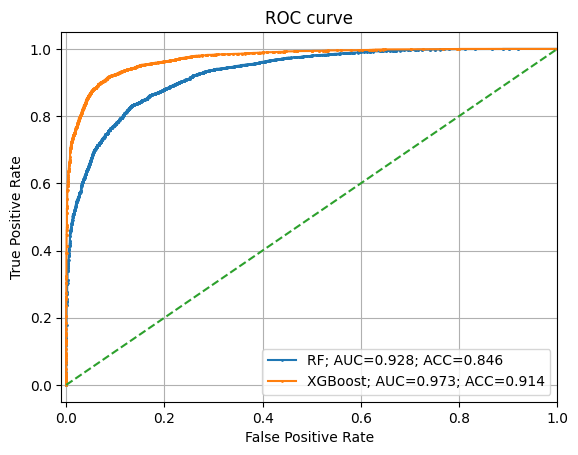

In [26]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb], ['RF', 'XGBoost'])

## NN raw

In [27]:
N_epochs = 5000
stop_criteria = 200

In [28]:
exp_nn_raw = NNRawExperiment(Xs, ys)
exp_nn_raw.set_training_parms(N_epochs, stop_criteria)

In [29]:
study_nn_raw = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name=f"{base_exp_name}-nn_raw-{suffix_exp_name}",
    direction='maximize',
)
study_nn_raw.optimize(exp_nn_raw.objective_(), n_trials=N_trials)

[I 2023-01-27 11:56:57,970] A new study created in RDB with name: electricity-nn_raw-v2
[I 2023-01-27 12:00:08,221] Trial 0 finished with value: 0.8009820912767187 and parameters: {'hidden_dim': 1706, 'dropout': 0.13921574772139633}. Best is trial 0 with value: 0.8009820912767187.


Early stopping at epoch 635 with valid acc 0.801


[I 2023-01-27 12:02:49,442] Trial 1 finished with value: 0.8056036972848065 and parameters: {'hidden_dim': 1694, 'dropout': 0.5106476199669976}. Best is trial 1 with value: 0.8056036972848065.


Early stopping at epoch 563 with valid acc 0.806


[I 2023-01-27 12:08:52,434] Trial 2 finished with value: 0.806470248411323 and parameters: {'hidden_dim': 1947, 'dropout': 0.412711438218377}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 1082 with valid acc 0.806


[I 2023-01-27 12:09:11,044] Trial 3 finished with value: 0.7588099364529174 and parameters: {'hidden_dim': 93, 'dropout': 0.3043342671196019}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 757 with valid acc 0.759


[I 2023-01-27 12:10:29,871] Trial 4 finished with value: 0.7992489890236857 and parameters: {'hidden_dim': 283, 'dropout': 0.23707383521911715}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 1175 with valid acc 0.799


[I 2023-01-27 12:10:37,779] Trial 5 finished with value: 0.7414789139225881 and parameters: {'hidden_dim': 106, 'dropout': 0.4905239583007639}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 286 with valid acc 0.741


[I 2023-01-27 12:10:44,479] Trial 6 finished with value: 0.7146158290005777 and parameters: {'hidden_dim': 14, 'dropout': 0.8709535266235882}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 658 with valid acc 0.715


[I 2023-01-27 12:10:52,134] Trial 7 finished with value: 0.7423454650491046 and parameters: {'hidden_dim': 12, 'dropout': 0.24333819652657204}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 789 with valid acc 0.742


[I 2023-01-27 12:10:59,997] Trial 8 finished with value: 0.7198151357596765 and parameters: {'hidden_dim': 23, 'dropout': 0.8116009718088528}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 650 with valid acc 0.720


[I 2023-01-27 12:12:49,540] Trial 9 finished with value: 0.7758521086077412 and parameters: {'hidden_dim': 1755, 'dropout': 0.7078800729430207}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 360 with valid acc 0.776


[I 2023-01-27 12:13:47,609] Trial 10 finished with value: 0.7876949740034662 and parameters: {'hidden_dim': 391, 'dropout': 0.008268131984350058}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 667 with valid acc 0.788


[I 2023-01-27 12:14:53,627] Trial 11 finished with value: 0.7790294627383015 and parameters: {'hidden_dim': 908, 'dropout': 0.5162072037970312}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 408 with valid acc 0.779


[I 2023-01-27 12:16:01,173] Trial 12 finished with value: 0.7952050837666089 and parameters: {'hidden_dim': 603, 'dropout': 0.4831292269564597}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 617 with valid acc 0.795


[I 2023-01-27 12:18:17,352] Trial 13 finished with value: 0.7813402657423455 and parameters: {'hidden_dim': 1740, 'dropout': 0.6117622574491912}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 462 with valid acc 0.781


[I 2023-01-27 12:18:39,256] Trial 14 finished with value: 0.7328134026574235 and parameters: {'hidden_dim': 277, 'dropout': 0.9739366104610503}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 341 with valid acc 0.733


[I 2023-01-27 12:19:49,499] Trial 15 finished with value: 0.7900057770075101 and parameters: {'hidden_dim': 823, 'dropout': 0.41798699025992286}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 470 with valid acc 0.790


[I 2023-01-27 12:19:51,867] Trial 16 finished with value: 0.7128827267475448 and parameters: {'hidden_dim': 5, 'dropout': 0.37947016706220044}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 314 with valid acc 0.713


[I 2023-01-27 12:20:21,672] Trial 17 finished with value: 0.7530329289428076 and parameters: {'hidden_dim': 182, 'dropout': 0.6583727965493889}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 677 with valid acc 0.753


[I 2023-01-27 12:22:59,705] Trial 18 finished with value: 0.7876949740034662 and parameters: {'hidden_dim': 829, 'dropout': 0.5836473056826279}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 1088 with valid acc 0.788


[I 2023-01-27 12:23:48,267] Trial 19 finished with value: 0.7894280762564991 and parameters: {'hidden_dim': 531, 'dropout': 0.3762911404423149}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 481 with valid acc 0.789


[I 2023-01-27 12:29:46,307] Trial 20 finished with value: 0.8027151935297516 and parameters: {'hidden_dim': 2016, 'dropout': 0.5553057255802913}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 933 with valid acc 0.803


[I 2023-01-27 12:34:05,588] Trial 21 finished with value: 0.8035817446562681 and parameters: {'hidden_dim': 1971, 'dropout': 0.5707297533436683}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 750 with valid acc 0.804


[I 2023-01-27 12:37:14,391] Trial 22 finished with value: 0.8021374927787406 and parameters: {'hidden_dim': 1223, 'dropout': 0.44698395280046627}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 862 with valid acc 0.802


[I 2023-01-27 12:38:47,771] Trial 23 finished with value: 0.7718082033506644 and parameters: {'hidden_dim': 1128, 'dropout': 0.6481016189205053}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 474 with valid acc 0.772


[I 2023-01-27 12:39:50,964] Trial 24 finished with value: 0.78105141536684 and parameters: {'hidden_dim': 613, 'dropout': 0.5475893339912656}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 547 with valid acc 0.781


[I 2023-01-27 12:42:34,137] Trial 25 finished with value: 0.7645869439630272 and parameters: {'hidden_dim': 2002, 'dropout': 0.7207052345127497}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 469 with valid acc 0.765


[I 2023-01-27 12:45:04,736] Trial 26 finished with value: 0.7972270363951474 and parameters: {'hidden_dim': 1271, 'dropout': 0.44312274335955726}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 661 with valid acc 0.797


[I 2023-01-27 12:46:11,126] Trial 27 finished with value: 0.7761409589832466 and parameters: {'hidden_dim': 441, 'dropout': 0.5600256133304562}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 682 with valid acc 0.776


[I 2023-01-27 12:49:21,940] Trial 28 finished with value: 0.8024263431542461 and parameters: {'hidden_dim': 1001, 'dropout': 0.49182702798138017}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 1036 with valid acc 0.802


[I 2023-01-27 12:52:38,864] Trial 29 finished with value: 0.8032928942807626 and parameters: {'hidden_dim': 2048, 'dropout': 0.3315227283890252}. Best is trial 2 with value: 0.806470248411323.


Early stopping at epoch 573 with valid acc 0.803


In [30]:
best_params_nn_raw = study_nn_raw.best_params
best_params_nn_raw

{'dropout': 0.412711438218377, 'hidden_dim': 1947}

In [31]:
train_losses, test_losses, y_hat_raw = exp_nn_raw.get_best_y_test(study_nn_raw.best_trial)

Early stopping at epoch 489 with valid acc 0.792


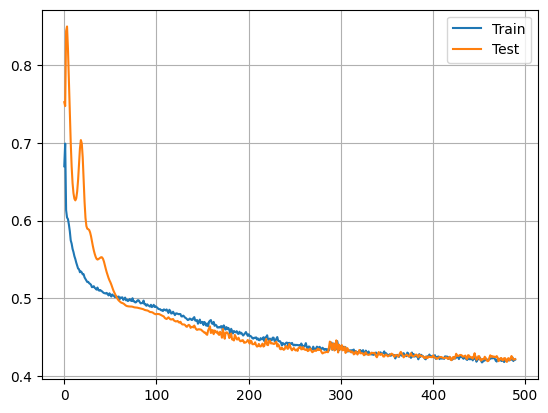

In [32]:
plot_losses(train_losses, test_losses)

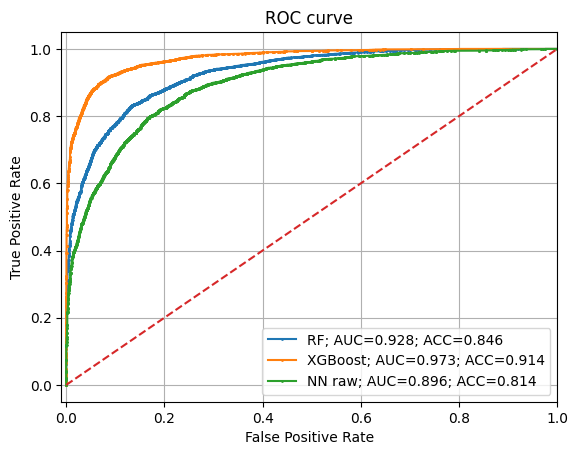

In [33]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw], ['RF', 'XGBoost', 'NN raw'])

### Single-feature DTE

In [34]:
exp_dte = DTEExperiment(Xs, ys)
exp_dte.set_training_parms(N_epochs, stop_criteria)

In [ ]:
study_dte = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name=f"{base_exp_name}-dte-{suffix_exp_name}",
    direction='maximize',
)
study_dte.optimize(exp_dte.objective_(), n_trials=N_trials*20)

[I 2023-01-27 12:55:25,193] A new study created in RDB with name: electricity-dte-v2
[I 2023-01-27 12:57:29,194] Trial 0 finished with value: 0.8942807625649913 and parameters: {'min_impurity_decrease': 1.4918728988524985e-05, 'embed_dim': 21, 'hidden_dim': 576, 'dropout_embed': 0.38501634424466374, 'dropout_ffn': 0.10965917088358695, 'l1_lambda': 6.321786885974775e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 739 with valid acc 0.894


[I 2023-01-27 12:57:58,693] Trial 1 finished with value: 0.842576545349509 and parameters: {'min_impurity_decrease': 2.154277481085877e-06, 'embed_dim': 21, 'hidden_dim': 27, 'dropout_embed': 0.35420505112082634, 'dropout_ffn': 0.33782427339849175, 'l1_lambda': 1.2843583080730651e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 364 with valid acc 0.843


[I 2023-01-27 12:59:05,304] Trial 2 finished with value: 0.8760831889081456 and parameters: {'min_impurity_decrease': 7.63511666409944e-06, 'embed_dim': 12, 'hidden_dim': 349, 'dropout_embed': 0.4160428748865537, 'dropout_ffn': 0.14591473164662988, 'l1_lambda': 7.279720042851916e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 632 with valid acc 0.876


[I 2023-01-27 13:02:53,527] Trial 3 finished with value: 0.8723281340265743 and parameters: {'min_impurity_decrease': 6.44644832877355e-06, 'embed_dim': 25, 'hidden_dim': 1665, 'dropout_embed': 0.48434326275914824, 'dropout_ffn': 0.38974131748034657, 'l1_lambda': 1.353278380488094e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 574 with valid acc 0.872


[I 2023-01-27 13:03:53,527] Trial 4 finished with value: 0.8691507798960139 and parameters: {'min_impurity_decrease': 1.6776431442948433e-06, 'embed_dim': 19, 'hidden_dim': 334, 'dropout_embed': 0.39514736363213143, 'dropout_ffn': 0.13967903855038633, 'l1_lambda': 6.491277826575511e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 460 with valid acc 0.869


[I 2023-01-27 13:05:17,534] Trial 5 finished with value: 0.8292894280762565 and parameters: {'min_impurity_decrease': 2.07022309618874e-06, 'embed_dim': 18, 'hidden_dim': 85, 'dropout_embed': 0.2401904680666464, 'dropout_ffn': 0.2272983072629497, 'l1_lambda': 0.004363907454674145}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 1092 with valid acc 0.829


[I 2023-01-27 13:05:45,000] Trial 6 finished with value: 0.8737723859041017 and parameters: {'min_impurity_decrease': 2.5321236586885513e-05, 'embed_dim': 5, 'hidden_dim': 33, 'dropout_embed': 0.18558319511819943, 'dropout_ffn': 0.2950428905108265, 'l1_lambda': 0.0009129251561487744}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 807 with valid acc 0.874


[I 2023-01-27 13:06:44,780] Trial 7 finished with value: 0.8243789716926632 and parameters: {'min_impurity_decrease': 7.934770151464538e-06, 'embed_dim': 6, 'hidden_dim': 75, 'dropout_embed': 0.320987299384071, 'dropout_ffn': 0.2890282156715364, 'l1_lambda': 0.00942659486488018}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 1277 with valid acc 0.824


[I 2023-01-27 13:07:17,208] Trial 8 finished with value: 0.8082033506643559 and parameters: {'min_impurity_decrease': 1.0359551134571401e-06, 'embed_dim': 8, 'hidden_dim': 65, 'dropout_embed': 0.25505481718764245, 'dropout_ffn': 0.26726543962086147, 'l1_lambda': 0.009254244955089724}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 635 with valid acc 0.808


[I 2023-01-27 13:19:09,901] Trial 9 finished with value: 0.8454650491045639 and parameters: {'min_impurity_decrease': 4.225655089021882e-06, 'embed_dim': 23, 'hidden_dim': 44, 'dropout_embed': 0.1676184867257166, 'dropout_ffn': 0.35195255094789063, 'l1_lambda': 1.2323782079985014e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 711 with valid acc 0.845


[I 2023-01-27 13:20:05,702] Trial 10 finished with value: 0.8622183708838822 and parameters: {'min_impurity_decrease': 7.303303539270936e-05, 'embed_dim': 32, 'hidden_dim': 10, 'dropout_embed': 0.022698359277230684, 'dropout_ffn': 0.0003487957291531951, 'l1_lambda': 0.00031842094446376715}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 550 with valid acc 0.862


[I 2023-01-27 13:21:03,528] Trial 11 finished with value: 0.876372039283651 and parameters: {'min_impurity_decrease': 1.679729000178696e-05, 'embed_dim': 13, 'hidden_dim': 346, 'dropout_embed': 0.47894032585096413, 'dropout_ffn': 0.4950269039802298, 'l1_lambda': 7.42203350995707e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 524 with valid acc 0.876


[I 2023-01-27 13:22:04,075] Trial 12 finished with value: 0.8885037550548815 and parameters: {'min_impurity_decrease': 1.840980298040958e-05, 'embed_dim': 14, 'hidden_dim': 301, 'dropout_embed': 0.4806883505747414, 'dropout_ffn': 0.4611364220530303, 'l1_lambda': 6.910314923713524e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 563 with valid acc 0.889


[I 2023-01-27 13:27:29,452] Trial 13 finished with value: 0.8937030618139804 and parameters: {'min_impurity_decrease': 1.9000422414271372e-05, 'embed_dim': 28, 'hidden_dim': 1277, 'dropout_embed': 0.49953953645374527, 'dropout_ffn': 0.4800157886965602, 'l1_lambda': 0.00018807029606414155}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 967 with valid acc 0.894


[I 2023-01-27 13:33:44,725] Trial 14 finished with value: 0.891681109185442 and parameters: {'min_impurity_decrease': 3.560025848891322e-05, 'embed_dim': 28, 'hidden_dim': 1685, 'dropout_embed': 0.41038285409878233, 'dropout_ffn': 0.4209870851090708, 'l1_lambda': 0.0002401155897288515}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 892 with valid acc 0.892


[I 2023-01-27 13:37:18,743] Trial 15 finished with value: 0.8939919121894858 and parameters: {'min_impurity_decrease': 1.2480128450567446e-05, 'embed_dim': 28, 'hidden_dim': 858, 'dropout_embed': 0.49858080927300996, 'dropout_ffn': 0.44048803326757113, 'l1_lambda': 0.00024397130898610311}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 826 with valid acc 0.894


[I 2023-01-27 13:39:59,185] Trial 16 finished with value: 0.8824378971692663 and parameters: {'min_impurity_decrease': 1.2308231635983286e-05, 'embed_dim': 32, 'hidden_dim': 806, 'dropout_embed': 0.4262555028329053, 'dropout_ffn': 0.4069585598780994, 'l1_lambda': 0.0009086066697832647}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 638 with valid acc 0.882


[I 2023-01-27 13:42:38,681] Trial 17 finished with value: 0.8885037550548815 and parameters: {'min_impurity_decrease': 3.809030259654374e-05, 'embed_dim': 26, 'hidden_dim': 839, 'dropout_embed': 0.3416824029223967, 'dropout_ffn': 0.20180633057581238, 'l1_lambda': 3.736474038234857e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 646 with valid acc 0.889


[I 2023-01-27 13:47:26,776] Trial 18 finished with value: 0.877527440785673 and parameters: {'min_impurity_decrease': 1.1624155384510383e-05, 'embed_dim': 21, 'hidden_dim': 172, 'dropout_embed': 0.43968029540719894, 'dropout_ffn': 0.06847289373190202, 'l1_lambda': 3.3712696655706814e-05}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 420 with valid acc 0.878


[I 2023-01-27 13:48:14,631] Trial 19 finished with value: 0.7605430387059503 and parameters: {'min_impurity_decrease': 4.756953727585393e-06, 'embed_dim': 1, 'hidden_dim': 538, 'dropout_embed': 0.37262577641783445, 'dropout_ffn': 0.18868396590432795, 'l1_lambda': 0.00014161574591278138}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 425 with valid acc 0.761


[I 2023-01-27 13:53:27,723] Trial 20 finished with value: 0.89052570768342 and parameters: {'min_impurity_decrease': 1.0757210408426099e-05, 'embed_dim': 29, 'hidden_dim': 2032, 'dropout_embed': 0.45625666907565016, 'dropout_ffn': 0.3339694364782534, 'l1_lambda': 0.00048685586849094763}. Best is trial 0 with value: 0.8942807625649913.


Early stopping at epoch 655 with valid acc 0.891


[I 2023-01-27 13:57:57,020] Trial 21 finished with value: 0.8965915655690352 and parameters: {'min_impurity_decrease': 1.689957781696524e-05, 'embed_dim': 28, 'hidden_dim': 973, 'dropout_embed': 0.49320635583372396, 'dropout_ffn': 0.4993884439117886, 'l1_lambda': 0.00017076814897090824}. Best is trial 21 with value: 0.8965915655690352.


Early stopping at epoch 977 with valid acc 0.897


[I 2023-01-27 14:00:54,789] Trial 22 finished with value: 0.8989023685730791 and parameters: {'min_impurity_decrease': 2.63633672687039e-05, 'embed_dim': 24, 'hidden_dim': 826, 'dropout_embed': 0.4529213894520001, 'dropout_ffn': 0.4487582140743793, 'l1_lambda': 0.00015229940609780493}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 767 with valid acc 0.899


[I 2023-01-27 14:03:04,001] Trial 23 finished with value: 0.8925476603119584 and parameters: {'min_impurity_decrease': 2.757463598283765e-05, 'embed_dim': 24, 'hidden_dim': 572, 'dropout_embed': 0.4298487588627558, 'dropout_ffn': 0.4549310764421594, 'l1_lambda': 0.00012559441320573125}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 705 with valid acc 0.893


[I 2023-01-27 15:17:17,538] Trial 24 finished with value: 0.889370306181398 and parameters: {'min_impurity_decrease': 4.9598340209920275e-05, 'embed_dim': 21, 'hidden_dim': 1045, 'dropout_embed': 0.45064976008384644, 'dropout_ffn': 0.48399717483307836, 'l1_lambda': 0.000400577591465239}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 823 with valid acc 0.889


[I 2023-01-27 15:18:31,604] Trial 25 finished with value: 0.8772385904101675 and parameters: {'min_impurity_decrease': 5.8168208103926516e-05, 'embed_dim': 17, 'hidden_dim': 183, 'dropout_embed': 0.38042550165321193, 'dropout_ffn': 0.4986971143176867, 'l1_lambda': 0.00012702869939776472}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 786 with valid acc 0.877


[I 2023-01-27 15:21:50,196] Trial 26 finished with value: 0.8740612362796072 and parameters: {'min_impurity_decrease': 7.931469720996627e-05, 'embed_dim': 22, 'hidden_dim': 611, 'dropout_embed': 0.4465028885811822, 'dropout_ffn': 0.37438547345879697, 'l1_lambda': 3.099019726641792e-05}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 1063 with valid acc 0.874


[I 2023-01-27 15:24:46,640] Trial 27 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 2.5711595064695e-05, 'embed_dim': 26, 'hidden_dim': 1269, 'dropout_embed': 0.39368302512627423, 'dropout_ffn': 0.4284467301942846, 'l1_lambda': 0.00013146891196762697}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 542 with valid acc 0.898


[I 2023-01-27 15:29:32,457] Trial 28 finished with value: 0.8567302137492778 and parameters: {'min_impurity_decrease': 9.444234256281579e-05, 'embed_dim': 30, 'hidden_dim': 1251, 'dropout_embed': 0.46105060627014216, 'dropout_ffn': 0.4405178318551473, 'l1_lambda': 0.0005851514803134046}. Best is trial 22 with value: 0.8989023685730791.


Early stopping at epoch 853 with valid acc 0.857


[I 2023-01-27 15:42:32,427] Trial 29 finished with value: 0.902946273830156 and parameters: {'min_impurity_decrease': 2.5479293371657538e-05, 'embed_dim': 26, 'hidden_dim': 1271, 'dropout_embed': 0.3973114620021653, 'dropout_ffn': 0.42313518878816336, 'l1_lambda': 0.00011276648388580447}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 603 with valid acc 0.903


[I 2023-01-27 15:47:02,611] Trial 30 finished with value: 0.8974581166955518 and parameters: {'min_impurity_decrease': 2.9625528991209562e-05, 'embed_dim': 26, 'hidden_dim': 2026, 'dropout_embed': 0.39642423925058046, 'dropout_ffn': 0.4175193210212281, 'l1_lambda': 0.00010329892535573003}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 584 with valid acc 0.897


[I 2023-01-27 15:54:27,593] Trial 31 finished with value: 0.8968804159445407 and parameters: {'min_impurity_decrease': 2.4226282200353622e-05, 'embed_dim': 26, 'hidden_dim': 1913, 'dropout_embed': 0.3949022547397632, 'dropout_ffn': 0.40932718972148713, 'l1_lambda': 9.744598277878465e-05}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 1001 with valid acc 0.897


[I 2023-01-27 16:40:37,795] Trial 32 finished with value: 0.8873483535528596 and parameters: {'min_impurity_decrease': 3.435663017001575e-05, 'embed_dim': 26, 'hidden_dim': 1312, 'dropout_embed': 0.35887626689602775, 'dropout_ffn': 0.37612867203939426, 'l1_lambda': 0.00011055218564038046}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 724 with valid acc 0.887


[I 2023-01-27 16:45:29,923] Trial 33 finished with value: 0.9026574234546505 and parameters: {'min_impurity_decrease': 2.329054727903338e-05, 'embed_dim': 24, 'hidden_dim': 1501, 'dropout_embed': 0.32244909837996527, 'dropout_ffn': 0.4230448509752013, 'l1_lambda': 0.00020837735145410834}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 815 with valid acc 0.903


[I 2023-01-27 16:49:06,051] Trial 34 finished with value: 0.8838821490467937 and parameters: {'min_impurity_decrease': 4.575663345489539e-05, 'embed_dim': 20, 'hidden_dim': 1299, 'dropout_embed': 0.3224646566713011, 'dropout_ffn': 0.4618459133406638, 'l1_lambda': 0.00021535647596281066}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 695 with valid acc 0.884


[I 2023-01-27 16:50:50,850] Trial 35 finished with value: 0.8980358174465627 and parameters: {'min_impurity_decrease': 2.0700091154273723e-05, 'embed_dim': 15, 'hidden_dim': 652, 'dropout_embed': 0.4145754778306662, 'dropout_ffn': 0.3879686424110358, 'l1_lambda': 0.0002892910496373494}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 618 with valid acc 0.898


[I 2023-01-27 16:54:46,174] Trial 36 finished with value: 0.891681109185442 and parameters: {'min_impurity_decrease': 2.386251937226771e-05, 'embed_dim': 23, 'hidden_dim': 1442, 'dropout_embed': 0.35955469523541045, 'dropout_ffn': 0.43647802007113756, 'l1_lambda': 4.4152732694681545e-05}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 662 with valid acc 0.892


[I 2023-01-27 16:57:06,406] Trial 37 finished with value: 0.8919699595609474 and parameters: {'min_impurity_decrease': 1.4329330994415447e-05, 'embed_dim': 24, 'hidden_dim': 437, 'dropout_embed': 0.3319738557502038, 'dropout_ffn': 0.3451283592573783, 'l1_lambda': 0.00016257368375756611}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 843 with valid acc 0.892


[I 2023-01-27 16:59:21,730] Trial 38 finished with value: 0.8913922588099364 and parameters: {'min_impurity_decrease': 4.0234551024998716e-05, 'embed_dim': 19, 'hidden_dim': 1023, 'dropout_embed': 0.3821330986571161, 'dropout_ffn': 0.3201114215985582, 'l1_lambda': 5.887808695885658e-05}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 502 with valid acc 0.891


[I 2023-01-27 17:02:41,443] Trial 39 finished with value: 0.889370306181398 and parameters: {'min_impurity_decrease': 3.260630137864834e-05, 'embed_dim': 30, 'hidden_dim': 1516, 'dropout_embed': 0.30092093431276845, 'dropout_ffn': 0.3651337912221436, 'l1_lambda': 2.254979749229538e-05}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 515 with valid acc 0.889


[I 2023-01-27 17:05:49,361] Trial 40 finished with value: 0.8954361640670133 and parameters: {'min_impurity_decrease': 2.3430868681757062e-05, 'embed_dim': 24, 'hidden_dim': 733, 'dropout_embed': 0.4114512647322657, 'dropout_ffn': 0.39103586419485503, 'l1_lambda': 7.802692312051283e-05}. Best is trial 29 with value: 0.902946273830156.


Early stopping at epoch 868 with valid acc 0.895


[I 2023-01-27 17:08:27,665] Trial 41 finished with value: 0.9038128249566725 and parameters: {'min_impurity_decrease': 1.9972869480387402e-05, 'embed_dim': 15, 'hidden_dim': 721, 'dropout_embed': 0.41020060323825064, 'dropout_ffn': 0.3911935674083837, 'l1_lambda': 0.0002951441255714728}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 866 with valid acc 0.904


[I 2023-01-27 17:11:49,140] Trial 42 finished with value: 0.8807047949162334 and parameters: {'min_impurity_decrease': 2.7533348728986144e-05, 'embed_dim': 9, 'hidden_dim': 1041, 'dropout_embed': 0.36809016760999014, 'dropout_ffn': 0.39883291975064183, 'l1_lambda': 0.0003102581213050505}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 930 with valid acc 0.881


[I 2023-01-27 17:13:55,711] Trial 43 finished with value: 0.8887926054303871 and parameters: {'min_impurity_decrease': 1.4916055899858418e-05, 'embed_dim': 16, 'hidden_dim': 465, 'dropout_embed': 0.42617551765193806, 'dropout_ffn': 0.4284388426273703, 'l1_lambda': 0.0002067575014146474}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 916 with valid acc 0.889


[I 2023-01-27 17:32:09,991] Trial 44 finished with value: 0.8965915655690352 and parameters: {'min_impurity_decrease': 2.148077792629651e-05, 'embed_dim': 18, 'hidden_dim': 722, 'dropout_embed': 0.4669228982971242, 'dropout_ffn': 0.45861730164484643, 'l1_lambda': 0.00015666129439128348}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 949 with valid acc 0.897


[I 2023-01-27 18:40:53,314] Trial 45 finished with value: 0.8879260543038706 and parameters: {'min_impurity_decrease': 2.8946992945082138e-05, 'embed_dim': 10, 'hidden_dim': 1606, 'dropout_embed': 0.40022098501176906, 'dropout_ffn': 0.361246496610026, 'l1_lambda': 9.022569019892714e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 545 with valid acc 0.888


[I 2023-01-27 19:47:25,449] Trial 46 finished with value: 0.8783939919121895 and parameters: {'min_impurity_decrease': 8.948546453566021e-06, 'embed_dim': 13, 'hidden_dim': 1090, 'dropout_embed': 0.34176682321471996, 'dropout_ffn': 0.4128710691126103, 'l1_lambda': 5.384187783688224e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 833 with valid acc 0.878


[I 2023-01-27 20:20:37,862] Trial 47 finished with value: 0.89052570768342 and parameters: {'min_impurity_decrease': 1.843838593005414e-05, 'embed_dim': 22, 'hidden_dim': 404, 'dropout_embed': 0.29314545196412534, 'dropout_ffn': 0.4712840934976679, 'l1_lambda': 0.00042651381621909486}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 653 with valid acc 0.891


[I 2023-01-27 21:28:55,402] Trial 48 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 2.1428141460320432e-05, 'embed_dim': 25, 'hidden_dim': 849, 'dropout_embed': 0.38475521377373345, 'dropout_ffn': 0.3914898014152105, 'l1_lambda': 8.576729123906468e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 762 with valid acc 0.898


[I 2023-01-27 23:11:04,261] Trial 49 finished with value: 0.8821490467937608 and parameters: {'min_impurity_decrease': 1.3663741553557247e-05, 'embed_dim': 19, 'hidden_dim': 1610, 'dropout_embed': 0.46970558086446595, 'dropout_ffn': 0.43463215342068884, 'l1_lambda': 0.0002506664565853662}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 861 with valid acc 0.882


[I 2023-01-27 23:28:25,603] Trial 50 finished with value: 0.8911034084344309 and parameters: {'min_impurity_decrease': 1.630448756855628e-05, 'embed_dim': 31, 'hidden_dim': 287, 'dropout_embed': 0.432450137070454, 'dropout_ffn': 0.4634104906115246, 'l1_lambda': 0.00018294616991307912}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 761 with valid acc 0.891


[I 2023-01-28 00:21:32,054] Trial 51 finished with value: 0.8980358174465627 and parameters: {'min_impurity_decrease': 2.1271990034378477e-05, 'embed_dim': 27, 'hidden_dim': 908, 'dropout_embed': 0.37761855339314976, 'dropout_ffn': 0.3956373810924916, 'l1_lambda': 0.0001273306563069822}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 848 with valid acc 0.898


[I 2023-01-28 01:09:23,814] Trial 52 finished with value: 0.8937030618139804 and parameters: {'min_impurity_decrease': 3.304471552959926e-05, 'embed_dim': 25, 'hidden_dim': 819, 'dropout_embed': 0.4013634268838578, 'dropout_ffn': 0.3764478756898093, 'l1_lambda': 8.25454600596543e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 501 with valid acc 0.894


[I 2023-01-28 02:03:12,515] Trial 53 finished with value: 0.8937030618139804 and parameters: {'min_impurity_decrease': 1.8666317606446287e-05, 'embed_dim': 25, 'hidden_dim': 1182, 'dropout_embed': 0.35444239262528854, 'dropout_ffn': 0.4169834818184963, 'l1_lambda': 0.00010325692598262478}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 537 with valid acc 0.894


[I 2023-01-28 02:20:08,782] Trial 54 finished with value: 0.8939919121894858 and parameters: {'min_impurity_decrease': 2.6130952912781813e-05, 'embed_dim': 11, 'hidden_dim': 654, 'dropout_embed': 0.41617115233047, 'dropout_ffn': 0.3284890659755697, 'l1_lambda': 6.02965587562961e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 494 with valid acc 0.894


[I 2023-01-28 03:11:01,647] Trial 55 finished with value: 0.8887926054303871 and parameters: {'min_impurity_decrease': 3.94304879540757e-05, 'embed_dim': 23, 'hidden_dim': 503, 'dropout_embed': 0.4399776385896018, 'dropout_ffn': 0.44744331862205444, 'l1_lambda': 0.00015472297339104614}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 842 with valid acc 0.889


[I 2023-01-28 04:16:49,772] Trial 56 finished with value: 0.8957250144425187 and parameters: {'min_impurity_decrease': 1.645860003438121e-05, 'embed_dim': 27, 'hidden_dim': 838, 'dropout_embed': 0.38434581850270494, 'dropout_ffn': 0.35358520040733854, 'l1_lambda': 0.00023133967226660046}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 831 with valid acc 0.896


[I 2023-01-28 05:40:49,178] Trial 57 finished with value: 0.8977469670710572 and parameters: {'min_impurity_decrease': 2.0932107371593206e-05, 'embed_dim': 30, 'hidden_dim': 1691, 'dropout_embed': 0.4774092327071071, 'dropout_ffn': 0.4769445703901014, 'l1_lambda': 0.00034833354730822537}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 803 with valid acc 0.898


[I 2023-01-28 07:24:32,781] Trial 58 finished with value: 0.8931253610629694 and parameters: {'min_impurity_decrease': 9.616388423232291e-06, 'embed_dim': 20, 'hidden_dim': 1266, 'dropout_embed': 0.44675817313465965, 'dropout_ffn': 0.4301326615130111, 'l1_lambda': 8.043330045831255e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1055 with valid acc 0.893


[I 2023-01-28 08:15:57,074] Trial 59 finished with value: 0.8925476603119584 and parameters: {'min_impurity_decrease': 1.3557739435755414e-05, 'embed_dim': 22, 'hidden_dim': 549, 'dropout_embed': 0.3431685299592622, 'dropout_ffn': 0.30584474648424465, 'l1_lambda': 0.00020090876010151636}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 664 with valid acc 0.893


[I 2023-01-28 08:49:25,744] Trial 60 finished with value: 0.9015020219526285 and parameters: {'min_impurity_decrease': 2.5762547551980263e-05, 'embed_dim': 29, 'hidden_dim': 979, 'dropout_embed': 0.42031753190793114, 'dropout_ffn': 0.4503025936071955, 'l1_lambda': 0.00011643917395144174}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 486 with valid acc 0.902


[I 2023-01-28 09:57:47,212] Trial 61 finished with value: 0.8977469670710572 and parameters: {'min_impurity_decrease': 2.990937295484827e-05, 'embed_dim': 29, 'hidden_dim': 976, 'dropout_embed': 0.4172682309807545, 'dropout_ffn': 0.40371029610576087, 'l1_lambda': 0.00012704294524760998}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 787 with valid acc 0.898


[I 2023-01-28 10:47:21,075] Trial 62 finished with value: 0.8948584633160023 and parameters: {'min_impurity_decrease': 2.5949798148698326e-05, 'embed_dim': 27, 'hidden_dim': 729, 'dropout_embed': 0.38581420585731596, 'dropout_ffn': 0.4515487310680927, 'l1_lambda': 0.00015105615657785016}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 729 with valid acc 0.895


[I 2023-01-28 12:10:46,727] Trial 63 finished with value: 0.902368573079145 and parameters: {'min_impurity_decrease': 2.2890678731111302e-05, 'embed_dim': 32, 'hidden_dim': 1140, 'dropout_embed': 0.4274111387987228, 'dropout_ffn': 0.48425622319731065, 'l1_lambda': 6.825636548970933e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 846 with valid acc 0.902


[I 2023-01-28 13:17:12,590] Trial 64 finished with value: 0.8968804159445407 and parameters: {'min_impurity_decrease': 3.2436277974988485e-05, 'embed_dim': 32, 'hidden_dim': 1157, 'dropout_embed': 0.4532375689753919, 'dropout_ffn': 0.4778187683869309, 'l1_lambda': 0.00011493366092339931}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 632 with valid acc 0.897


[I 2023-01-28 15:15:40,678] Trial 65 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 3.708433276109072e-05, 'embed_dim': 31, 'hidden_dim': 1718, 'dropout_embed': 0.4868792406700213, 'dropout_ffn': 0.4873864261922322, 'l1_lambda': 0.0002687884729880673}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 887 with valid acc 0.898


[I 2023-01-28 16:38:22,209] Trial 66 finished with value: 0.8971692663200462 and parameters: {'min_impurity_decrease': 4.5397481606571754e-05, 'embed_dim': 29, 'hidden_dim': 1415, 'dropout_embed': 0.43339843938480005, 'dropout_ffn': 0.44843568893357577, 'l1_lambda': 6.858035867585434e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 630 with valid acc 0.897


[I 2023-01-28 18:41:24,807] Trial 67 finished with value: 0.8965915655690352 and parameters: {'min_impurity_decrease': 2.4801095905602838e-05, 'embed_dim': 31, 'hidden_dim': 1932, 'dropout_embed': 0.39930338031017515, 'dropout_ffn': 0.42593013974546146, 'l1_lambda': 0.00018262747991086575}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 872 with valid acc 0.897


[I 2023-01-28 20:38:22,709] Trial 68 finished with value: 0.8908145580589255 and parameters: {'min_impurity_decrease': 1.1609746960055143e-05, 'embed_dim': 28, 'hidden_dim': 1419, 'dropout_embed': 0.46396846439922096, 'dropout_ffn': 0.49912034631097013, 'l1_lambda': 0.00010708681849048773}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1043 with valid acc 0.891


[I 2023-01-28 21:44:33,861] Trial 69 finished with value: 0.8830155979202773 and parameters: {'min_impurity_decrease': 1.7350761081416485e-05, 'embed_dim': 15, 'hidden_dim': 968, 'dropout_embed': 0.4264168734267657, 'dropout_ffn': 0.46853187562477466, 'l1_lambda': 0.00013530534791303137}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 920 with valid acc 0.883


[I 2023-01-28 23:24:04,571] Trial 70 finished with value: 0.8963027151935298 and parameters: {'min_impurity_decrease': 2.8721905373320563e-05, 'embed_dim': 29, 'hidden_dim': 1166, 'dropout_embed': 0.44599719401327315, 'dropout_ffn': 0.43903735287131584, 'l1_lambda': 4.692738547950524e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 944 with valid acc 0.896


[I 2023-01-28 23:58:02,422] Trial 71 finished with value: 0.8954361640670133 and parameters: {'min_impurity_decrease': 2.09782848658003e-05, 'embed_dim': 25, 'hidden_dim': 908, 'dropout_embed': 0.36741176690485233, 'dropout_ffn': 0.4115380854925088, 'l1_lambda': 9.095755402122673e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 809 with valid acc 0.895


[I 2023-01-29 00:49:14,920] Trial 72 finished with value: 0.9026574234546505 and parameters: {'min_impurity_decrease': 2.3154653711239144e-05, 'embed_dim': 27, 'hidden_dim': 643, 'dropout_embed': 0.4082314864558124, 'dropout_ffn': 0.38476024786562407, 'l1_lambda': 7.046921644503105e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 701 with valid acc 0.903


[I 2023-01-29 01:38:20,145] Trial 73 finished with value: 0.8965915655690352 and parameters: {'min_impurity_decrease': 2.4423624396234176e-05, 'embed_dim': 27, 'hidden_dim': 594, 'dropout_embed': 0.40484825378935185, 'dropout_ffn': 0.41942457914633996, 'l1_lambda': 6.559158662786406e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 623 with valid acc 0.897


[I 2023-01-29 02:28:04,690] Trial 74 finished with value: 0.8968804159445407 and parameters: {'min_impurity_decrease': 1.5675504680949458e-05, 'embed_dim': 28, 'hidden_dim': 728, 'dropout_embed': 0.42131647477045314, 'dropout_ffn': 0.45116344979300743, 'l1_lambda': 0.0001805500219890545}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 815 with valid acc 0.897


[I 2023-01-29 03:19:53,488] Trial 75 finished with value: 0.8986135181975736 and parameters: {'min_impurity_decrease': 1.9345194093050353e-05, 'embed_dim': 23, 'hidden_dim': 1097, 'dropout_embed': 0.40928584929972317, 'dropout_ffn': 0.4819137047569215, 'l1_lambda': 7.063083986066977e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 557 with valid acc 0.899


[I 2023-01-29 04:44:22,301] Trial 76 finished with value: 0.8942807625649913 and parameters: {'min_impurity_decrease': 3.1631072631204933e-05, 'embed_dim': 23, 'hidden_dim': 1110, 'dropout_embed': 0.4374297716907396, 'dropout_ffn': 0.48708593573457465, 'l1_lambda': 7.002095405716893e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 902 with valid acc 0.894


[I 2023-01-29 05:17:45,636] Trial 77 finished with value: 0.8954361640670133 and parameters: {'min_impurity_decrease': 1.8695159658142152e-05, 'embed_dim': 32, 'hidden_dim': 660, 'dropout_embed': 0.41090463079802747, 'dropout_ffn': 0.471395186425349, 'l1_lambda': 0.00010343589053088576}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 685 with valid acc 0.895


[I 2023-01-29 05:35:04,618] Trial 78 finished with value: 0.7521663778162911 and parameters: {'min_impurity_decrease': 2.2570546271363707e-05, 'embed_dim': 1, 'hidden_dim': 1370, 'dropout_embed': 0.45762705531300324, 'dropout_ffn': 0.48512748693401325, 'l1_lambda': 5.0565990616594106e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 358 with valid acc 0.752


[I 2023-01-29 06:43:39,318] Trial 79 finished with value: 0.8919699595609474 and parameters: {'min_impurity_decrease': 1.8804921718260176e-05, 'embed_dim': 17, 'hidden_dim': 535, 'dropout_embed': 0.48050180398841447, 'dropout_ffn': 0.4597244632302051, 'l1_lambda': 3.801765154227084e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1243 with valid acc 0.892


[I 2023-01-29 08:08:09,014] Trial 80 finished with value: 0.9000577700751011 and parameters: {'min_impurity_decrease': 2.7566499623093823e-05, 'embed_dim': 24, 'hidden_dim': 986, 'dropout_embed': 0.49824568391183044, 'dropout_ffn': 0.4424009662900414, 'l1_lambda': 6.011746249638316e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 945 with valid acc 0.900


[I 2023-01-29 09:48:09,563] Trial 81 finished with value: 0.8960138648180243 and parameters: {'min_impurity_decrease': 2.733453545887434e-05, 'embed_dim': 24, 'hidden_dim': 994, 'dropout_embed': 0.4958624426654993, 'dropout_ffn': 0.4410310057700098, 'l1_lambda': 7.463394450092325e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1103 with valid acc 0.896


[I 2023-01-29 10:36:22,654] Trial 82 finished with value: 0.8968804159445407 and parameters: {'min_impurity_decrease': 3.453064651524093e-05, 'embed_dim': 21, 'hidden_dim': 784, 'dropout_embed': 0.4634848428671793, 'dropout_ffn': 0.4029673546747107, 'l1_lambda': 5.801897075195291e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 646 with valid acc 0.897


[I 2023-01-29 10:53:45,971] Trial 83 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 2.3575404176401068e-05, 'embed_dim': 24, 'hidden_dim': 1788, 'dropout_embed': 0.424143098682234, 'dropout_ffn': 0.42297949747128955, 'l1_lambda': 4.41238753371917e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 841 with valid acc 0.898


[I 2023-01-29 10:58:00,711] Trial 84 finished with value: 0.8971692663200462 and parameters: {'min_impurity_decrease': 2.9547529397095812e-05, 'embed_dim': 26, 'hidden_dim': 1434, 'dropout_embed': 0.47697423291882163, 'dropout_ffn': 0.4662039421345181, 'l1_lambda': 9.893002726703636e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 718 with valid acc 0.897


[I 2023-01-29 10:59:35,462] Trial 85 finished with value: 0.8258232235701907 and parameters: {'min_impurity_decrease': 1.4958611190831457e-05, 'embed_dim': 4, 'hidden_dim': 1114, 'dropout_embed': 0.443952552855586, 'dropout_ffn': 0.44416086465409704, 'l1_lambda': 0.00014589830667481956}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 423 with valid acc 0.826


[I 2023-01-29 11:05:04,261] Trial 86 finished with value: 0.8887926054303871 and parameters: {'min_impurity_decrease': 3.690709181246565e-05, 'embed_dim': 30, 'hidden_dim': 2046, 'dropout_embed': 0.40661700119040906, 'dropout_ffn': 0.37897815762035997, 'l1_lambda': 8.632055460359964e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 651 with valid acc 0.889


[I 2023-01-29 11:07:21,466] Trial 87 finished with value: 0.8876372039283651 and parameters: {'min_impurity_decrease': 2.6160974203117157e-05, 'embed_dim': 13, 'hidden_dim': 883, 'dropout_embed': 0.49762492615744475, 'dropout_ffn': 0.4999072183946973, 'l1_lambda': 0.00021836321611063515}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 629 with valid acc 0.888


[I 2023-01-29 11:13:09,952] Trial 88 finished with value: 0.902946273830156 and parameters: {'min_impurity_decrease': 1.9997654319537922e-05, 'embed_dim': 23, 'hidden_dim': 1516, 'dropout_embed': 0.39236071313914206, 'dropout_ffn': 0.4547740701953404, 'l1_lambda': 5.9696662019436184e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 962 with valid acc 0.903


[I 2023-01-29 11:17:28,843] Trial 89 finished with value: 0.8965915655690352 and parameters: {'min_impurity_decrease': 2.2254188800428454e-05, 'embed_dim': 28, 'hidden_dim': 1640, 'dropout_embed': 0.39375639336782337, 'dropout_ffn': 0.43187183914240984, 'l1_lambda': 5.3165403310504754e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 635 with valid acc 0.897


[I 2023-01-29 11:52:26,316] Trial 90 finished with value: 0.8902368573079145 and parameters: {'min_impurity_decrease': 1.6332916338185475e-05, 'embed_dim': 22, 'hidden_dim': 1290, 'dropout_embed': 0.3677195508020687, 'dropout_ffn': 0.3867525068802221, 'l1_lambda': 0.00011609710958029527}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 583 with valid acc 0.890


[I 2023-01-29 12:57:26,338] Trial 91 finished with value: 0.9032351242056614 and parameters: {'min_impurity_decrease': 1.991774477699677e-05, 'embed_dim': 24, 'hidden_dim': 1487, 'dropout_embed': 0.43233519257590836, 'dropout_ffn': 0.4592583082438864, 'l1_lambda': 6.488734918844161e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 609 with valid acc 0.903


[I 2023-01-29 14:51:59,622] Trial 92 finished with value: 0.8974581166955518 and parameters: {'min_impurity_decrease': 1.9722272326675796e-05, 'embed_dim': 25, 'hidden_dim': 1640, 'dropout_embed': 0.4528579787042189, 'dropout_ffn': 0.4569922796028731, 'l1_lambda': 5.796276213186532e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 912 with valid acc 0.897


[I 2023-01-29 15:41:43,800] Trial 93 finished with value: 0.9020797227036396 and parameters: {'min_impurity_decrease': 2.357559885401139e-05, 'embed_dim': 20, 'hidden_dim': 930, 'dropout_embed': 0.4361318431864733, 'dropout_ffn': 0.408685617135166, 'l1_lambda': 8.185623231227778e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 727 with valid acc 0.902


[I 2023-01-29 16:31:27,671] Trial 94 finished with value: 0.8870595031773542 and parameters: {'min_impurity_decrease': 1.7520766518552642e-05, 'embed_dim': 20, 'hidden_dim': 1231, 'dropout_embed': 0.4292126959068591, 'dropout_ffn': 0.4084748300752387, 'l1_lambda': 4.196425880525552e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 577 with valid acc 0.887


[I 2023-01-29 18:09:31,851] Trial 95 finished with value: 0.8934142114384749 and parameters: {'min_impurity_decrease': 2.3564291813475043e-05, 'embed_dim': 18, 'hidden_dim': 1433, 'dropout_embed': 0.438473674849098, 'dropout_ffn': 0.41984423920781244, 'l1_lambda': 3.197452505879941e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 828 with valid acc 0.893


[I 2023-01-29 19:16:01,971] Trial 96 finished with value: 0.89052570768342 and parameters: {'min_impurity_decrease': 3.152999804263936e-05, 'embed_dim': 24, 'hidden_dim': 972, 'dropout_embed': 0.392476309077228, 'dropout_ffn': 0.3961710608299622, 'l1_lambda': 6.34116341725162e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 781 with valid acc 0.891


[I 2023-01-29 19:37:10,626] Trial 97 finished with value: 0.8925476603119584 and parameters: {'min_impurity_decrease': 2.097430709661985e-05, 'embed_dim': 26, 'hidden_dim': 1803, 'dropout_embed': 0.41750006846732046, 'dropout_ffn': 0.4306797941722042, 'l1_lambda': 8.008190655262207e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 698 with valid acc 0.893


[I 2023-01-29 19:43:12,654] Trial 98 finished with value: 0.8908145580589255 and parameters: {'min_impurity_decrease': 1.357212528659507e-05, 'embed_dim': 21, 'hidden_dim': 1539, 'dropout_embed': 0.370088499277984, 'dropout_ffn': 0.44143517832180706, 'l1_lambda': 4.896391638975116e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 981 with valid acc 0.891


[I 2023-01-29 19:45:02,922] Trial 99 finished with value: 0.8989023685730791 and parameters: {'min_impurity_decrease': 2.632225075516153e-05, 'embed_dim': 22, 'hidden_dim': 639, 'dropout_embed': 0.46880643867355665, 'dropout_ffn': 0.46737089126393344, 'l1_lambda': 8.906949365119056e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 560 with valid acc 0.899


[I 2023-01-29 19:46:53,891] Trial 100 finished with value: 0.8957250144425187 and parameters: {'min_impurity_decrease': 2.8540790958861045e-05, 'embed_dim': 27, 'hidden_dim': 784, 'dropout_embed': 0.3867702678385899, 'dropout_ffn': 0.41145578550438033, 'l1_lambda': 0.00011634770089608882}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 481 with valid acc 0.896


[I 2023-01-29 19:49:10,753] Trial 101 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 2.3364870566821064e-05, 'embed_dim': 23, 'hidden_dim': 883, 'dropout_embed': 0.45402055793621166, 'dropout_ffn': 0.45577045822703105, 'l1_lambda': 0.000133541009786822}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 541 with valid acc 0.898


[I 2023-01-30 01:40:19,153] Trial 102 finished with value: 0.8957250144425187 and parameters: {'min_impurity_decrease': 2.0075065306645278e-05, 'embed_dim': 15, 'hidden_dim': 1050, 'dropout_embed': 0.43146776429598455, 'dropout_ffn': 0.44558439396289606, 'l1_lambda': 7.395917359005864e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1311 with valid acc 0.896


[I 2023-01-30 06:52:07,081] Trial 103 finished with value: 0.902368573079145 and parameters: {'min_impurity_decrease': 2.5609033997626144e-05, 'embed_dim': 26, 'hidden_dim': 1279, 'dropout_embed': 0.41872870530746537, 'dropout_ffn': 0.4738855822272152, 'l1_lambda': 0.00016245751727241345}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 695 with valid acc 0.902


[I 2023-01-30 18:30:17,631] Trial 104 finished with value: 0.8986135181975736 and parameters: {'min_impurity_decrease': 1.7572083018553234e-05, 'embed_dim': 26, 'hidden_dim': 1307, 'dropout_embed': 0.4032878938782865, 'dropout_ffn': 0.4758711664230623, 'l1_lambda': 0.0001647068529365998}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1247 with valid acc 0.899


[I 2023-01-31 02:30:10,919] Trial 105 finished with value: 0.8980358174465627 and parameters: {'min_impurity_decrease': 3.077557619172355e-05, 'embed_dim': 25, 'hidden_dim': 1493, 'dropout_embed': 0.37529476570338566, 'dropout_ffn': 0.4921470275972165, 'l1_lambda': 0.00010029702333170226}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 633 with valid acc 0.898


[I 2023-01-31 10:23:40,928] Trial 106 finished with value: 0.8968804159445407 and parameters: {'min_impurity_decrease': 3.391563164885821e-05, 'embed_dim': 29, 'hidden_dim': 1144, 'dropout_embed': 0.41926082476363086, 'dropout_ffn': 0.4268589701279142, 'l1_lambda': 0.00025551540988557475}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 759 with valid acc 0.897


[I 2023-01-31 14:38:35,729] Trial 107 finished with value: 0.8986135181975736 and parameters: {'min_impurity_decrease': 2.259100787291882e-05, 'embed_dim': 27, 'hidden_dim': 939, 'dropout_embed': 0.39219243757170913, 'dropout_ffn': 0.45642212595841447, 'l1_lambda': 5.691949725295423e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 596 with valid acc 0.899


[I 2023-01-31 14:41:47,474] Trial 108 finished with value: 0.8957250144425187 and parameters: {'min_impurity_decrease': 2.5343681608515422e-05, 'embed_dim': 16, 'hidden_dim': 1879, 'dropout_embed': 0.4411529740176558, 'dropout_ffn': 0.47131701182993474, 'l1_lambda': 9.062724396753533e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 460 with valid acc 0.896


[I 2023-01-31 14:46:03,258] Trial 109 finished with value: 0.8873483535528596 and parameters: {'min_impurity_decrease': 1.5431053241289326e-05, 'embed_dim': 14, 'hidden_dim': 1231, 'dropout_embed': 0.4106543503337098, 'dropout_ffn': 0.401732175558592, 'l1_lambda': 6.738760190219606e-05}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 936 with valid acc 0.887


[I 2023-01-31 14:51:47,198] Trial 110 finished with value: 0.8954361640670133 and parameters: {'min_impurity_decrease': 1.9759966898626064e-05, 'embed_dim': 24, 'hidden_dim': 1542, 'dropout_embed': 0.4221139112175561, 'dropout_ffn': 0.43791932203801315, 'l1_lambda': 0.000201561225128633}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 897 with valid acc 0.895


[I 2023-01-31 17:05:34,017] Trial 111 finished with value: 0.8974581166955518 and parameters: {'min_impurity_decrease': 2.6854316322590013e-05, 'embed_dim': 25, 'hidden_dim': 775, 'dropout_embed': 0.4329099662251279, 'dropout_ffn': 0.45057585557741964, 'l1_lambda': 0.0001500293089877558}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 816 with valid acc 0.897


[I 2023-01-31 23:05:23,943] Trial 112 finished with value: 0.8948584633160023 and parameters: {'min_impurity_decrease': 2.936888652592108e-05, 'embed_dim': 24, 'hidden_dim': 699, 'dropout_embed': 0.4439169134312432, 'dropout_ffn': 0.4889004894050354, 'l1_lambda': 0.00011177260866524284}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 537 with valid acc 0.895


[I 2023-02-01 11:35:57,356] Trial 113 finished with value: 0.9009243212016176 and parameters: {'min_impurity_decrease': 2.162750481250364e-05, 'embed_dim': 26, 'hidden_dim': 1037, 'dropout_embed': 0.4729064447446976, 'dropout_ffn': 0.41789446184186796, 'l1_lambda': 0.0001818798931556999}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 811 with valid acc 0.901


[I 2023-02-01 20:23:05,409] Trial 114 finished with value: 0.901790872328134 and parameters: {'min_impurity_decrease': 2.225384217721407e-05, 'embed_dim': 28, 'hidden_dim': 1010, 'dropout_embed': 0.48253154267169207, 'dropout_ffn': 0.4220044505741257, 'l1_lambda': 0.00017671648939268658}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 549 with valid acc 0.902


[I 2023-02-02 11:55:18,004] Trial 115 finished with value: 0.8991912189485847 and parameters: {'min_impurity_decrease': 2.1391775468932953e-05, 'embed_dim': 26, 'hidden_dim': 1353, 'dropout_embed': 0.4751081993800178, 'dropout_ffn': 0.36545351630813666, 'l1_lambda': 0.0002959424173137988}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 958 with valid acc 0.899


[I 2023-02-02 21:07:47,227] Trial 116 finished with value: 0.8983246678220682 and parameters: {'min_impurity_decrease': 1.813882159881636e-05, 'embed_dim': 28, 'hidden_dim': 1079, 'dropout_embed': 0.48652760948227824, 'dropout_ffn': 0.4187073475688428, 'l1_lambda': 0.00018201464699388686}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 828 with valid acc 0.898


[I 2023-02-02 21:11:35,695] Trial 117 finished with value: 0.902946273830156 and parameters: {'min_impurity_decrease': 2.4176774822300664e-05, 'embed_dim': 28, 'hidden_dim': 875, 'dropout_embed': 0.4627024155381049, 'dropout_ffn': 0.39239293787785684, 'l1_lambda': 0.00023365860411909942}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 857 with valid acc 0.903


[I 2023-02-02 21:15:34,420] Trial 118 finished with value: 0.901790872328134 and parameters: {'min_impurity_decrease': 2.4401704562637046e-05, 'embed_dim': 31, 'hidden_dim': 879, 'dropout_embed': 0.4614609746199658, 'dropout_ffn': 0.39471778418812836, 'l1_lambda': 0.00023771193146705137}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 865 with valid acc 0.902


[I 2023-02-02 21:18:31,205] Trial 119 finished with value: 0.9020797227036396 and parameters: {'min_impurity_decrease': 1.6752490752957787e-05, 'embed_dim': 30, 'hidden_dim': 595, 'dropout_embed': 0.4639004330638854, 'dropout_ffn': 0.38736987863763267, 'l1_lambda': 0.0003602360549131564}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 821 with valid acc 0.902


[I 2023-02-02 21:22:30,591] Trial 120 finished with value: 0.9006354708261121 and parameters: {'min_impurity_decrease': 1.6912985441206917e-05, 'embed_dim': 30, 'hidden_dim': 603, 'dropout_embed': 0.45204995976278134, 'dropout_ffn': 0.3862291661378805, 'l1_lambda': 0.00022852844145368118}. Best is trial 41 with value: 0.9038128249566725.


Early stopping at epoch 1094 with valid acc 0.901


In [ ]:
best_params_dte = study_dte.best_params
best_params_dte

In [ ]:
train_losses_dte, test_losses_dte, y_hat_dt = exp_dte.get_best_y_test(study_dte.best_trial)

In [ ]:
plot_losses(train_losses_dte, test_losses_dte)

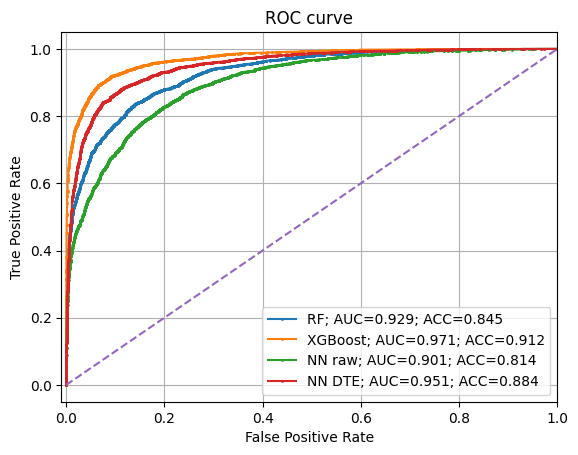

In [84]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])

#### Try manually

In [88]:
from torch import nn

In [85]:
Xs_dt, decision_trees, leaf_encoders = decision_tree_encoding(
    Xs, ys, min_impurity_decrease=1e-5)#, max_splits=20)

In [86]:
n_uniques = (Xs_dt['train'].max(dim=0)[0]+1).numpy()
n_uniques

array([ 664,   34,  961, 1600,  799,  918,  682])

In [255]:
embed_dim = 16
hidden_dim = 2048
dropout = 0.4

model_dt = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat'),
    nn.Linear(n_uniques.shape[0]*embed_dim, hidden_dim),
    nn.ReLU(),
    nn.Dropout(dropout),
#     nn.Linear(hidden_dim, 1),
# #     nn.Linear(n_uniques.shape[0]*embed_dim, hidden_dim),
# #     nn.ReLU(),
# #     nn.Dropout(dropout),
    FeedForwardMLPResidual(
        d_model=hidden_dim, dim_feedforward=hidden_dim, dropout=dropout,
    ),
    nn.Linear(hidden_dim, 1),
)

In [256]:
# model_dt

In [257]:
train_losses_dt, test_losses_dt, y_hat_dt2 = train(
    model_dt, Xs_dt['train'], ys['train'], Xs_dt['valid'], ys['valid'], Xs_dt['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=1e-4, #5e-4, 1e-3,
)

Early stopping at epoch 577 with valid acc 0.875


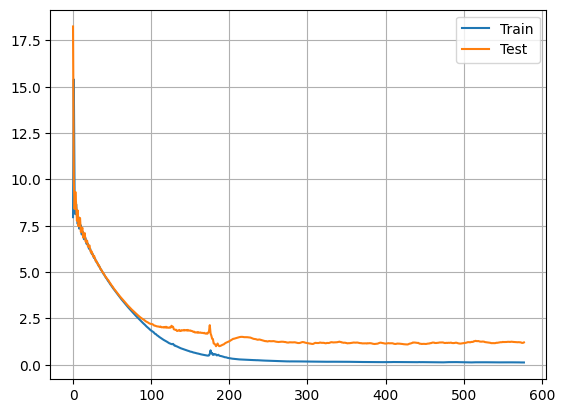

In [258]:
plot_losses(train_losses_dt, test_losses_dt)

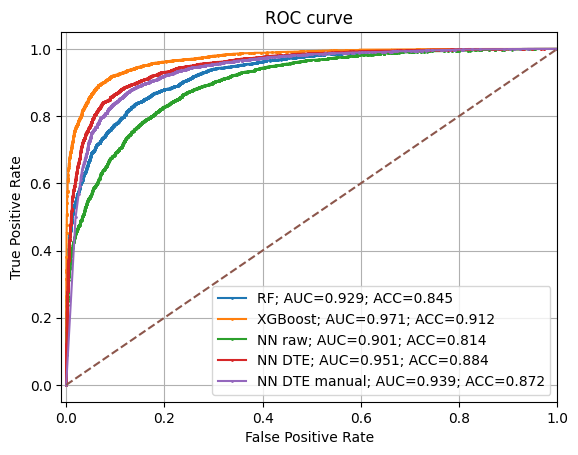

In [259]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dt2], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN DTE manual']
)

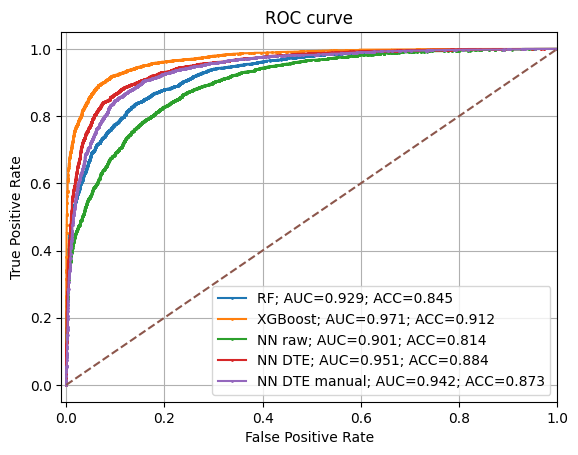

In [114]:
plot_roc(
    ys['test'],
    [y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt, y_hat_dt2], 
    ['RF', 'XGBoost', 'NN raw', 'NN DTE', 'NN DTE manual']
)